<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [LADYB1] - Prediction of a 2D trajectory via RNN
<!-- DESC --> Artificial dataset generation and prediction attempt via a recurrent network
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding the use of a recurrent neural network

## What we're going to do :

 - Generate an artificial dataset
 - dataset preparation
 - Doing our training
 - Making predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
from math import sin,cos,pi
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/LADYBUG1'
datasets_dir = pwk.init('LADYBUG1', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.19
Notebook id          : LADYBUG1
Run time             : Tuesday 09 March 2021, 22:32:46
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/LADYBUG1
Update keras cache   : False
Save figs            : True
Path figs            : ./run/LADYBUG1/figs


### 1.2 - Parameters

In [2]:
# ---- About dataset
#
max_t        = 1000
delta_t      = 0.02
features_len = 2


sequence_len = 20
predict_len  = 5

# ---- About training
#
scale        = 1        # Percentage of dataset to be used (1=all)
train_prop   = .8       # Percentage for train (the rest being for the test)
batch_size   = 32
epochs       = 5

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'train_prop', 'sequence_len', 'predict_len', 'batch_size', 'epochs')

## Step 2 - Generation of a fun dataset
### 2.1 - Virtual trajectory of our ladybug

In [4]:
def ladybug_init(s=122):
    
    if s>0 : random.seed(s)
    ladybug_init.params_x = [ random.gauss(0.,1.) for u in range(8)]
    ladybug_init.params_y = [ random.gauss(0.,1.) for u in range(8)]
    
def ladybug_move(t):
    k=0.5
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = ladybug_init.params_x
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = ladybug_init.params_y
    
    x = ax1*sin(t*(kx1+20)) + ax2*cos(t*(kx2+10)) + ax3*sin(t*(kx3+5)) + ax4*cos(t*(kx4+5))
    y = ay1*cos(t*(ky1+20)) + ay2*sin(t*(ky2+10)) + ay3*cos(t*(ky3+5)) + ay4*sin(t*(ky4+5)) 


    return x,y

### 2.2 - Get some positions, and build a rescaled and normalized dataset

In [5]:
# ---- Get positions
#
ladybug_init(s=16)
x,y = 0,0
positions=[]
for t in np.arange(0., max_t, delta_t):
    positions.append([x,y])
    x,y = ladybug_move(t)
#     (x,y) = (x+dx, y+dy)

# ---- Build rescaled dataset
#
n = int( len(positions)*scale )
dataset = np.array(positions[:n])

k = int(len(dataset)*train_prop)
x_train = dataset[:k]
x_test  = dataset[k:]

# ---- Normalize
#
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

print("Dataset generated.")
print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)


Dataset generated.
Train shape is :  (40000, 2)
Test  shape is :  (10000, 2)


### 2.3 - Have a look
An extract from the data we have: the virtual trajectory of our ladybug   
And what we want to predict (in red), from a segment (in blue)

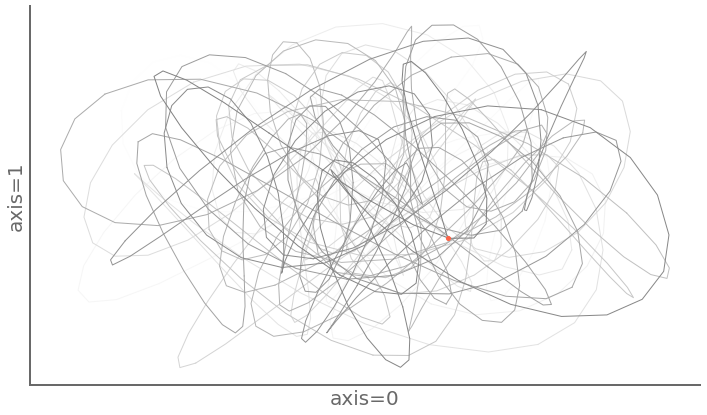

In [6]:
pwk.plot_2d_serie(x_train[:1000], figsize=(12,12), lw=1,ms=4,save_as='01-dataset')

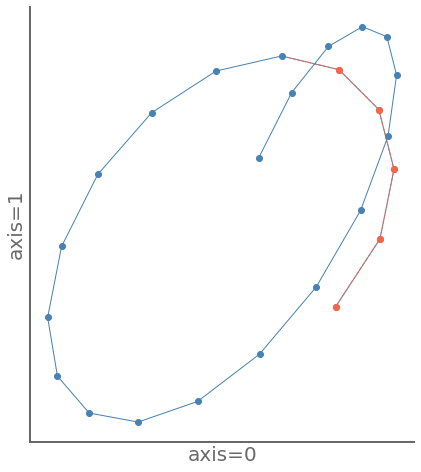

In [7]:
k1,k2 = sequence_len, predict_len
i = random.randint(0,len(x_test)-k1-k2)
j = i+k1

pwk.plot_2d_segment( x_test[i:j+k2], x_test[j:j+k2],ms=6, save_as='02-objectives')

### 2.4 - Prepare some nice data generator

In [8]:
# ---- Train generator
#
train_generator = TimeseriesGenerator(x_train, x_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,  x_test,  length=sequence_len,  batch_size=batch_size)

# ---- About
#
pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Number of batch trains available : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y) :')
pwk.np_print(y[0])

<br>**About the splitting of our dataset :**

Number of batch trains available :  1250
batch x shape :  (32, 20, 2)
batch y shape :  (32, 2)


<br>**What a batch looks like (x) :**

[[ 1.973e-04  1.973e-04]
 [ 1.511e+00  6.019e-01]
 [ 1.097e+00  5.694e-01]
 [ 6.732e-01  4.095e-01]
 [ 2.772e-01  1.534e-01]
 [-6.037e-02 -1.521e-01]
 [-3.214e-01 -4.520e-01]
 [-5.014e-01 -6.919e-01]
 [-6.096e-01 -8.267e-01]
 [-6.663e-01 -8.277e-01]
 [-6.991e-01 -6.870e-01]
 [-7.382e-01 -4.191e-01]
 [-8.108e-01 -5.863e-02]
 [-9.365e-01  3.454e-01]
 [-1.124e+00  7.367e-01]
 [-1.368e+00  1.061e+00]
 [-1.652e+00  1.274e+00]
 [-1.946e+00  1.349e+00]
 [-2.214e+00  1.281e+00]
 [-2.420e+00  1.086e+00]]


<br>**What a batch looks like (y) :**

[-2.528  0.801]


## Step 3 - Create a model

In [9]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
# model.add( keras.layers.GRU(200, dropout=.1, recurrent_dropout=0.5, return_sequences=False, activation='relu') )
model.add( keras.layers.GRU(200, return_sequences=False, activation='relu') )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 200)               122400    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 122,802
Trainable params: 122,802
Non-trainable params: 0
_________________________________________________________________


## Step 4 - Compile and run

### 4.1 - Add callback

In [10]:
pwk.mkdir('./run/models')
save_dir = './run/models/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [11]:
model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
3' with a CPU (laptop)  

In [12]:
pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs=epochs, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/5


   1/1250 [..............................] - ETA: 0s - loss: 0.4516 - mae: 0.5741

   3/1250 [..............................] - ETA: 22s - loss: 0.7420 - mae: 0.7200

   5/1250 [..............................] - ETA: 27s - loss: 0.8147 - mae: 0.7515

   8/1250 [..............................] - ETA: 27s - loss: 0.6896 - mae: 0.6893

  11/1250 [..............................] - ETA: 27s - loss: 0.5986 - mae: 0.6390

  14/1250 [..............................] - ETA: 28s - loss: 0.5289 - mae: 0.5932

  17/1250 [..............................] - ETA: 28s - loss: 0.4960 - mae: 0.5721

  20/1250 [..............................] - ETA: 27s - loss: 0.4573 - mae: 0.5478

  23/1250 [..............................] - ETA: 27s - loss: 0.4339 - mae: 0.5311

  26/1250 [..............................] - ETA: 26s - loss: 0.4073 - mae: 0.5121

  29/1250 [..............................] - ETA: 26s - loss: 0.3909 - mae: 0.5022

  32/1250 [..............................] - ETA: 26s - loss: 0.3733 - mae: 0.4895

  35/1250 [..............................] - ETA: 26s - loss: 0.3552 - mae: 0.4760

  38/1250 [..............................] - ETA: 25s - loss: 0.3430 - mae: 0.4664

  41/1250 [..............................] - ETA: 25s - loss: 0.3279 - mae: 0.4553

  44/1250 [>.............................] - ETA: 25s - loss: 0.3171 - mae: 0.4473

  46/1250 [>.............................] - ETA: 26s - loss: 0.3084 - mae: 0.4405

  48/1250 [>.............................] - ETA: 26s - loss: 0.3081 - mae: 0.4390

  51/1250 [>.............................] - ETA: 26s - loss: 0.3017 - mae: 0.4349

  52/1250 [>.............................] - ETA: 27s - loss: 0.2994 - mae: 0.4335

  54/1250 [>.............................] - ETA: 28s - loss: 0.2958 - mae: 0.4310

  56/1250 [>.............................] - ETA: 28s - loss: 0.2923 - mae: 0.4291

  58/1250 [>.............................] - ETA: 28s - loss: 0.2877 - mae: 0.4257

  60/1250 [>.............................] - ETA: 29s - loss: 0.2830 - mae: 0.4225

  62/1250 [>.............................] - ETA: 30s - loss: 0.2782 - mae: 0.4188

  64/1250 [>.............................] - ETA: 30s - loss: 0.2740 - mae: 0.4154

  66/1250 [>.............................] - ETA: 30s - loss: 0.2689 - mae: 0.4109

  68/1250 [>.............................] - ETA: 30s - loss: 0.2639 - mae: 0.4067

  70/1250 [>.............................] - ETA: 30s - loss: 0.2595 - mae: 0.4028

  72/1250 [>.............................] - ETA: 30s - loss: 0.2553 - mae: 0.3990

  74/1250 [>.............................] - ETA: 30s - loss: 0.2507 - mae: 0.3947

  76/1250 [>.............................] - ETA: 30s - loss: 0.2457 - mae: 0.3899

  79/1250 [>.............................] - ETA: 29s - loss: 0.2726 - mae: 0.3927

  82/1250 [>.............................] - ETA: 29s - loss: 0.2686 - mae: 0.3907

  85/1250 [=>............................] - ETA: 29s - loss: 0.2633 - mae: 0.3870

  88/1250 [=>............................] - ETA: 28s - loss: 0.2589 - mae: 0.3836

  91/1250 [=>............................] - ETA: 28s - loss: 0.2547 - mae: 0.3809

  94/1250 [=>............................] - ETA: 28s - loss: 0.2499 - mae: 0.3775

  97/1250 [=>............................] - ETA: 28s - loss: 0.2458 - mae: 0.3747

 100/1250 [=>............................] - ETA: 27s - loss: 0.2421 - mae: 0.3723

 103/1250 [=>............................] - ETA: 27s - loss: 0.2378 - mae: 0.3688

 106/1250 [=>............................] - ETA: 27s - loss: 0.2333 - mae: 0.3650

 109/1250 [=>............................] - ETA: 27s - loss: 0.2291 - mae: 0.3614

 112/1250 [=>............................] - ETA: 27s - loss: 0.2251 - mae: 0.3580

 115/1250 [=>............................] - ETA: 26s - loss: 0.2212 - mae: 0.3547

 118/1250 [=>............................] - ETA: 26s - loss: 0.2171 - mae: 0.3511

 121/1250 [=>............................] - ETA: 26s - loss: 0.2129 - mae: 0.3467

 124/1250 [=>............................] - ETA: 26s - loss: 0.2087 - mae: 0.3423

 127/1250 [==>...........................] - ETA: 26s - loss: 0.2048 - mae: 0.3383

 130/1250 [==>...........................] - ETA: 26s - loss: 0.2012 - mae: 0.3347

 133/1250 [==>...........................] - ETA: 26s - loss: 0.1985 - mae: 0.3324

 136/1250 [==>...........................] - ETA: 25s - loss: 0.1954 - mae: 0.3296

 139/1250 [==>...........................] - ETA: 25s - loss: 0.1923 - mae: 0.3266

 142/1250 [==>...........................] - ETA: 25s - loss: 0.1891 - mae: 0.3232

 145/1250 [==>...........................] - ETA: 25s - loss: 0.1860 - mae: 0.3199

 148/1250 [==>...........................] - ETA: 25s - loss: 0.1834 - mae: 0.3176

 151/1250 [==>...........................] - ETA: 25s - loss: 0.1808 - mae: 0.3150

 154/1250 [==>...........................] - ETA: 25s - loss: 0.1784 - mae: 0.3128

 156/1250 [==>...........................] - ETA: 25s - loss: 0.1770 - mae: 0.3116

 158/1250 [==>...........................] - ETA: 25s - loss: 0.1754 - mae: 0.3101

 160/1250 [==>...........................] - ETA: 25s - loss: 0.1739 - mae: 0.3086

 162/1250 [==>...........................] - ETA: 25s - loss: 0.1720 - mae: 0.3062

 165/1250 [==>...........................] - ETA: 24s - loss: 0.1697 - mae: 0.3039

 168/1250 [===>..........................] - ETA: 24s - loss: 0.1673 - mae: 0.3011

 171/1250 [===>..........................] - ETA: 24s - loss: 0.1652 - mae: 0.2991

 174/1250 [===>..........................] - ETA: 24s - loss: 0.1633 - mae: 0.2972

 177/1250 [===>..........................] - ETA: 24s - loss: 0.1611 - mae: 0.2948

 180/1250 [===>..........................] - ETA: 24s - loss: 0.1590 - mae: 0.2923

 183/1250 [===>..........................] - ETA: 24s - loss: 0.1570 - mae: 0.2900

 186/1250 [===>..........................] - ETA: 24s - loss: 0.1550 - mae: 0.2878

 189/1250 [===>..........................] - ETA: 24s - loss: 0.1532 - mae: 0.2859

 192/1250 [===>..........................] - ETA: 23s - loss: 0.1512 - mae: 0.2834

 195/1250 [===>..........................] - ETA: 23s - loss: 0.1497 - mae: 0.2820

 198/1250 [===>..........................] - ETA: 23s - loss: 0.1482 - mae: 0.2804

 201/1250 [===>..........................] - ETA: 23s - loss: 0.1462 - mae: 0.2779

 204/1250 [===>..........................] - ETA: 23s - loss: 0.1444 - mae: 0.2756

 207/1250 [===>..........................] - ETA: 23s - loss: 0.1429 - mae: 0.2739

 210/1250 [====>.........................] - ETA: 23s - loss: 0.1411 - mae: 0.2717

 213/1250 [====>.........................] - ETA: 23s - loss: 0.1396 - mae: 0.2701

 216/1250 [====>.........................] - ETA: 23s - loss: 0.1383 - mae: 0.2688

 219/1250 [====>.........................] - ETA: 22s - loss: 0.1366 - mae: 0.2665

 222/1250 [====>.........................] - ETA: 22s - loss: 0.1358 - mae: 0.2658

 225/1250 [====>.........................] - ETA: 22s - loss: 0.1345 - mae: 0.2643

 228/1250 [====>.........................] - ETA: 22s - loss: 0.1330 - mae: 0.2624

 231/1250 [====>.........................] - ETA: 22s - loss: 0.1315 - mae: 0.2603

 234/1250 [====>.........................] - ETA: 22s - loss: 0.1301 - mae: 0.2587

 237/1250 [====>.........................] - ETA: 22s - loss: 0.1286 - mae: 0.2566

 240/1250 [====>.........................] - ETA: 22s - loss: 0.1275 - mae: 0.2553

 243/1250 [====>.........................] - ETA: 22s - loss: 0.1261 - mae: 0.2536

 246/1250 [====>.........................] - ETA: 22s - loss: 0.1250 - mae: 0.2524

 249/1250 [====>.........................] - ETA: 22s - loss: 0.1237 - mae: 0.2505

 252/1250 [=====>........................] - ETA: 22s - loss: 0.1225 - mae: 0.2488

 255/1250 [=====>........................] - ETA: 21s - loss: 0.1214 - mae: 0.2477

 258/1250 [=====>........................] - ETA: 21s - loss: 0.1202 - mae: 0.2459

 261/1250 [=====>........................] - ETA: 21s - loss: 0.1191 - mae: 0.2444

 264/1250 [=====>........................] - ETA: 21s - loss: 0.1180 - mae: 0.2431

 267/1250 [=====>........................] - ETA: 21s - loss: 0.1168 - mae: 0.2415

 270/1250 [=====>........................] - ETA: 21s - loss: 0.1159 - mae: 0.2405

 273/1250 [=====>........................] - ETA: 21s - loss: 0.1149 - mae: 0.2393

 276/1250 [=====>........................] - ETA: 21s - loss: 0.1138 - mae: 0.2377

 279/1250 [=====>........................] - ETA: 21s - loss: 0.1129 - mae: 0.2365

 282/1250 [=====>........................] - ETA: 21s - loss: 0.1118 - mae: 0.2349

 285/1250 [=====>........................] - ETA: 21s - loss: 0.1107 - mae: 0.2333

 288/1250 [=====>........................] - ETA: 21s - loss: 0.1097 - mae: 0.2316

 291/1250 [=====>........................] - ETA: 20s - loss: 0.1088 - mae: 0.2307

 294/1250 [======>.......................] - ETA: 20s - loss: 0.1079 - mae: 0.2294

 297/1250 [======>.......................] - ETA: 20s - loss: 0.1070 - mae: 0.2281

 300/1250 [======>.......................] - ETA: 20s - loss: 0.1061 - mae: 0.2270

 303/1250 [======>.......................] - ETA: 20s - loss: 0.1051 - mae: 0.2255

 306/1250 [======>.......................] - ETA: 20s - loss: 0.1043 - mae: 0.2242

 309/1250 [======>.......................] - ETA: 20s - loss: 0.1035 - mae: 0.2231

 312/1250 [======>.......................] - ETA: 20s - loss: 0.1026 - mae: 0.2219

 315/1250 [======>.......................] - ETA: 20s - loss: 0.1017 - mae: 0.2206

 318/1250 [======>.......................] - ETA: 20s - loss: 0.1010 - mae: 0.2197

 321/1250 [======>.......................] - ETA: 20s - loss: 0.1001 - mae: 0.2183

 324/1250 [======>.......................] - ETA: 20s - loss: 0.0994 - mae: 0.2173

 327/1250 [======>.......................] - ETA: 19s - loss: 0.0986 - mae: 0.2163

 330/1250 [======>.......................] - ETA: 19s - loss: 0.0979 - mae: 0.2152

 333/1250 [======>.......................] - ETA: 19s - loss: 0.0971 - mae: 0.2143

 336/1250 [=======>......................] - ETA: 19s - loss: 0.0964 - mae: 0.2133

 339/1250 [=======>......................] - ETA: 19s - loss: 0.0957 - mae: 0.2121

 342/1250 [=======>......................] - ETA: 19s - loss: 0.0949 - mae: 0.2108

 344/1250 [=======>......................] - ETA: 19s - loss: 0.0944 - mae: 0.2101

 347/1250 [=======>......................] - ETA: 19s - loss: 0.0937 - mae: 0.2092

 350/1250 [=======>......................] - ETA: 19s - loss: 0.0930 - mae: 0.2082

 353/1250 [=======>......................] - ETA: 19s - loss: 0.0923 - mae: 0.2070

 356/1250 [=======>......................] - ETA: 19s - loss: 0.0917 - mae: 0.2061

 359/1250 [=======>......................] - ETA: 19s - loss: 0.0910 - mae: 0.2051

 362/1250 [=======>......................] - ETA: 19s - loss: 0.0903 - mae: 0.2039

 365/1250 [=======>......................] - ETA: 19s - loss: 0.0897 - mae: 0.2032

 368/1250 [=======>......................] - ETA: 19s - loss: 0.0891 - mae: 0.2024

 371/1250 [=======>......................] - ETA: 18s - loss: 0.0885 - mae: 0.2014

 374/1250 [=======>......................] - ETA: 18s - loss: 0.0878 - mae: 0.2002

 377/1250 [========>.....................] - ETA: 18s - loss: 0.0871 - mae: 0.1990

 380/1250 [========>.....................] - ETA: 18s - loss: 0.0867 - mae: 0.1985

 383/1250 [========>.....................] - ETA: 18s - loss: 0.0860 - mae: 0.1974

 386/1250 [========>.....................] - ETA: 18s - loss: 0.0854 - mae: 0.1962

 389/1250 [========>.....................] - ETA: 18s - loss: 0.0848 - mae: 0.1954

 392/1250 [========>.....................] - ETA: 18s - loss: 0.0842 - mae: 0.1945

 395/1250 [========>.....................] - ETA: 18s - loss: 0.0837 - mae: 0.1937

 398/1250 [========>.....................] - ETA: 18s - loss: 0.0831 - mae: 0.1928

 401/1250 [========>.....................] - ETA: 18s - loss: 0.0826 - mae: 0.1921

 404/1250 [========>.....................] - ETA: 18s - loss: 0.0821 - mae: 0.1914

 407/1250 [========>.....................] - ETA: 18s - loss: 0.0816 - mae: 0.1905

 410/1250 [========>.....................] - ETA: 17s - loss: 0.0811 - mae: 0.1897

 413/1250 [========>.....................] - ETA: 17s - loss: 0.0805 - mae: 0.1887

 416/1250 [========>.....................] - ETA: 17s - loss: 0.0801 - mae: 0.1882

 419/1250 [=========>....................] - ETA: 17s - loss: 0.0795 - mae: 0.1873

 422/1250 [=========>....................] - ETA: 17s - loss: 0.0791 - mae: 0.1867

 425/1250 [=========>....................] - ETA: 17s - loss: 0.0786 - mae: 0.1859

 428/1250 [=========>....................] - ETA: 17s - loss: 0.0781 - mae: 0.1850

 431/1250 [=========>....................] - ETA: 17s - loss: 0.0776 - mae: 0.1841

 434/1250 [=========>....................] - ETA: 17s - loss: 0.0771 - mae: 0.1833

 437/1250 [=========>....................] - ETA: 17s - loss: 0.0767 - mae: 0.1828

 440/1250 [=========>....................] - ETA: 17s - loss: 0.0762 - mae: 0.1820

 443/1250 [=========>....................] - ETA: 17s - loss: 0.0758 - mae: 0.1812

 446/1250 [=========>....................] - ETA: 17s - loss: 0.0753 - mae: 0.1804

 449/1250 [=========>....................] - ETA: 16s - loss: 0.0748 - mae: 0.1796

 452/1250 [=========>....................] - ETA: 16s - loss: 0.0744 - mae: 0.1790

 455/1250 [=========>....................] - ETA: 16s - loss: 0.0739 - mae: 0.1781

 458/1250 [=========>....................] - ETA: 16s - loss: 0.0736 - mae: 0.1776

 461/1250 [==========>...................] - ETA: 16s - loss: 0.0731 - mae: 0.1769

 464/1250 [==========>...................] - ETA: 16s - loss: 0.0727 - mae: 0.1761

 467/1250 [==========>...................] - ETA: 16s - loss: 0.0723 - mae: 0.1754

 470/1250 [==========>...................] - ETA: 16s - loss: 0.0719 - mae: 0.1747

 473/1250 [==========>...................] - ETA: 16s - loss: 0.0715 - mae: 0.1741

 476/1250 [==========>...................] - ETA: 16s - loss: 0.0711 - mae: 0.1735

 479/1250 [==========>...................] - ETA: 16s - loss: 0.0707 - mae: 0.1729

 482/1250 [==========>...................] - ETA: 16s - loss: 0.0703 - mae: 0.1724

 485/1250 [==========>...................] - ETA: 16s - loss: 0.0699 - mae: 0.1717

 488/1250 [==========>...................] - ETA: 16s - loss: 0.0695 - mae: 0.1711

 491/1250 [==========>...................] - ETA: 15s - loss: 0.0692 - mae: 0.1705

 494/1250 [==========>...................] - ETA: 15s - loss: 0.0688 - mae: 0.1701

 497/1250 [==========>...................] - ETA: 15s - loss: 0.0684 - mae: 0.1694

 500/1250 [===========>..................] - ETA: 15s - loss: 0.0681 - mae: 0.1686

 503/1250 [===========>..................] - ETA: 15s - loss: 0.0678 - mae: 0.1684

 506/1250 [===========>..................] - ETA: 15s - loss: 0.0674 - mae: 0.1678

 509/1250 [===========>..................] - ETA: 15s - loss: 0.0670 - mae: 0.1672

 512/1250 [===========>..................] - ETA: 15s - loss: 0.0667 - mae: 0.1665

 515/1250 [===========>..................] - ETA: 15s - loss: 0.0664 - mae: 0.1660

 518/1250 [===========>..................] - ETA: 15s - loss: 0.0660 - mae: 0.1655

 521/1250 [===========>..................] - ETA: 15s - loss: 0.0657 - mae: 0.1648

 524/1250 [===========>..................] - ETA: 15s - loss: 0.0653 - mae: 0.1641

 527/1250 [===========>..................] - ETA: 15s - loss: 0.0650 - mae: 0.1634

 530/1250 [===========>..................] - ETA: 15s - loss: 0.0647 - mae: 0.1630

 533/1250 [===========>..................] - ETA: 15s - loss: 0.0644 - mae: 0.1625

 536/1250 [===========>..................] - ETA: 14s - loss: 0.0640 - mae: 0.1620

 539/1250 [===========>..................] - ETA: 14s - loss: 0.0637 - mae: 0.1614

 542/1250 [============>.................] - ETA: 14s - loss: 0.0634 - mae: 0.1609

 545/1250 [============>.................] - ETA: 14s - loss: 0.0631 - mae: 0.1604

 548/1250 [============>.................] - ETA: 14s - loss: 0.0628 - mae: 0.1599

 551/1250 [============>.................] - ETA: 14s - loss: 0.0625 - mae: 0.1593

 554/1250 [============>.................] - ETA: 14s - loss: 0.0622 - mae: 0.1588

 557/1250 [============>.................] - ETA: 14s - loss: 0.0619 - mae: 0.1582

 560/1250 [============>.................] - ETA: 14s - loss: 0.0616 - mae: 0.1578

 563/1250 [============>.................] - ETA: 14s - loss: 0.0613 - mae: 0.1572

 566/1250 [============>.................] - ETA: 14s - loss: 0.0610 - mae: 0.1566

 569/1250 [============>.................] - ETA: 14s - loss: 0.0607 - mae: 0.1562

 572/1250 [============>.................] - ETA: 14s - loss: 0.0604 - mae: 0.1557

 575/1250 [============>.................] - ETA: 14s - loss: 0.0601 - mae: 0.1552

 578/1250 [============>.................] - ETA: 13s - loss: 0.0598 - mae: 0.1546

 581/1250 [============>.................] - ETA: 13s - loss: 0.0596 - mae: 0.1543

 584/1250 [=============>................] - ETA: 13s - loss: 0.0593 - mae: 0.1540

 587/1250 [=============>................] - ETA: 13s - loss: 0.0591 - mae: 0.1535

 590/1250 [=============>................] - ETA: 13s - loss: 0.0588 - mae: 0.1529

 593/1250 [=============>................] - ETA: 13s - loss: 0.0585 - mae: 0.1524

 596/1250 [=============>................] - ETA: 13s - loss: 0.0582 - mae: 0.1520

 599/1250 [=============>................] - ETA: 13s - loss: 0.0580 - mae: 0.1514

 602/1250 [=============>................] - ETA: 13s - loss: 0.0577 - mae: 0.1510

 605/1250 [=============>................] - ETA: 13s - loss: 0.0575 - mae: 0.1505

 608/1250 [=============>................] - ETA: 13s - loss: 0.0572 - mae: 0.1500

 611/1250 [=============>................] - ETA: 13s - loss: 0.0569 - mae: 0.1495

 614/1250 [=============>................] - ETA: 13s - loss: 0.0567 - mae: 0.1492

 617/1250 [=============>................] - ETA: 13s - loss: 0.0564 - mae: 0.1487

 620/1250 [=============>................] - ETA: 13s - loss: 0.0562 - mae: 0.1484

 623/1250 [=============>................] - ETA: 13s - loss: 0.0560 - mae: 0.1480

 626/1250 [==============>...............] - ETA: 12s - loss: 0.0557 - mae: 0.1476

 629/1250 [==============>...............] - ETA: 12s - loss: 0.0555 - mae: 0.1471

 632/1250 [==============>...............] - ETA: 12s - loss: 0.0552 - mae: 0.1466

 635/1250 [==============>...............] - ETA: 12s - loss: 0.0550 - mae: 0.1462

 638/1250 [==============>...............] - ETA: 12s - loss: 0.0548 - mae: 0.1458

 641/1250 [==============>...............] - ETA: 12s - loss: 0.0545 - mae: 0.1454

 644/1250 [==============>...............] - ETA: 12s - loss: 0.0543 - mae: 0.1451

 647/1250 [==============>...............] - ETA: 12s - loss: 0.0541 - mae: 0.1447

 650/1250 [==============>...............] - ETA: 12s - loss: 0.0539 - mae: 0.1444

 653/1250 [==============>...............] - ETA: 12s - loss: 0.0537 - mae: 0.1440

 656/1250 [==============>...............] - ETA: 12s - loss: 0.0535 - mae: 0.1436

 659/1250 [==============>...............] - ETA: 12s - loss: 0.0532 - mae: 0.1431

 662/1250 [==============>...............] - ETA: 12s - loss: 0.0530 - mae: 0.1428

 665/1250 [==============>...............] - ETA: 12s - loss: 0.0528 - mae: 0.1425

 668/1250 [===============>..............] - ETA: 12s - loss: 0.0526 - mae: 0.1421

 671/1250 [===============>..............] - ETA: 11s - loss: 0.0524 - mae: 0.1417

 674/1250 [===============>..............] - ETA: 11s - loss: 0.0522 - mae: 0.1413

 677/1250 [===============>..............] - ETA: 11s - loss: 0.0520 - mae: 0.1409

 680/1250 [===============>..............] - ETA: 11s - loss: 0.0518 - mae: 0.1405

 683/1250 [===============>..............] - ETA: 11s - loss: 0.0516 - mae: 0.1401

 686/1250 [===============>..............] - ETA: 11s - loss: 0.0514 - mae: 0.1398

 689/1250 [===============>..............] - ETA: 11s - loss: 0.0512 - mae: 0.1395

 692/1250 [===============>..............] - ETA: 11s - loss: 0.0510 - mae: 0.1391

 695/1250 [===============>..............] - ETA: 11s - loss: 0.0508 - mae: 0.1387

 698/1250 [===============>..............] - ETA: 11s - loss: 0.0506 - mae: 0.1385

 701/1250 [===============>..............] - ETA: 11s - loss: 0.0504 - mae: 0.1381

 704/1250 [===============>..............] - ETA: 11s - loss: 0.0502 - mae: 0.1377

 707/1250 [===============>..............] - ETA: 11s - loss: 0.0500 - mae: 0.1373

 710/1250 [================>.............] - ETA: 11s - loss: 0.0498 - mae: 0.1370

 713/1250 [================>.............] - ETA: 11s - loss: 0.0497 - mae: 0.1367

 716/1250 [================>.............] - ETA: 10s - loss: 0.0495 - mae: 0.1364

 719/1250 [================>.............] - ETA: 10s - loss: 0.0493 - mae: 0.1360

 722/1250 [================>.............] - ETA: 10s - loss: 0.0491 - mae: 0.1357

 725/1250 [================>.............] - ETA: 10s - loss: 0.0489 - mae: 0.1354

 728/1250 [================>.............] - ETA: 10s - loss: 0.0487 - mae: 0.1351

 730/1250 [================>.............] - ETA: 10s - loss: 0.0486 - mae: 0.1349

 732/1250 [================>.............] - ETA: 10s - loss: 0.0485 - mae: 0.1347

 734/1250 [================>.............] - ETA: 10s - loss: 0.0484 - mae: 0.1345

 737/1250 [================>.............] - ETA: 10s - loss: 0.0482 - mae: 0.1342

 740/1250 [================>.............] - ETA: 10s - loss: 0.0480 - mae: 0.1339

 743/1250 [================>.............] - ETA: 10s - loss: 0.0479 - mae: 0.1335

 746/1250 [================>.............] - ETA: 10s - loss: 0.0477 - mae: 0.1332

 749/1250 [================>.............] - ETA: 10s - loss: 0.0475 - mae: 0.1328

 752/1250 [=================>............] - ETA: 10s - loss: 0.0473 - mae: 0.1324

 755/1250 [=================>............] - ETA: 10s - loss: 0.0472 - mae: 0.1322

 758/1250 [=================>............] - ETA: 10s - loss: 0.0470 - mae: 0.1318

 761/1250 [=================>............] - ETA: 10s - loss: 0.0468 - mae: 0.1315

 764/1250 [=================>............] - ETA: 10s - loss: 0.0467 - mae: 0.1313

 767/1250 [=================>............] - ETA: 10s - loss: 0.0465 - mae: 0.1310

 770/1250 [=================>............] - ETA: 9s - loss: 0.0463 - mae: 0.1307 

 773/1250 [=================>............] - ETA: 9s - loss: 0.0462 - mae: 0.1304

 776/1250 [=================>............] - ETA: 9s - loss: 0.0460 - mae: 0.1300

 779/1250 [=================>............] - ETA: 9s - loss: 0.0458 - mae: 0.1297

 782/1250 [=================>............] - ETA: 9s - loss: 0.0457 - mae: 0.1294

 785/1250 [=================>............] - ETA: 9s - loss: 0.0455 - mae: 0.1291

 788/1250 [=================>............] - ETA: 9s - loss: 0.0454 - mae: 0.1288

 791/1250 [=================>............] - ETA: 9s - loss: 0.0452 - mae: 0.1286

 794/1250 [==================>...........] - ETA: 9s - loss: 0.0451 - mae: 0.1283

 797/1250 [==================>...........] - ETA: 9s - loss: 0.0449 - mae: 0.1280

 800/1250 [==================>...........] - ETA: 9s - loss: 0.0448 - mae: 0.1277

 803/1250 [==================>...........] - ETA: 9s - loss: 0.0446 - mae: 0.1274

 806/1250 [==================>...........] - ETA: 9s - loss: 0.0445 - mae: 0.1272

 808/1250 [==================>...........] - ETA: 9s - loss: 0.0444 - mae: 0.1270

 811/1250 [==================>...........] - ETA: 9s - loss: 0.0442 - mae: 0.1267

 814/1250 [==================>...........] - ETA: 9s - loss: 0.0441 - mae: 0.1264

 817/1250 [==================>...........] - ETA: 8s - loss: 0.0439 - mae: 0.1260

 820/1250 [==================>...........] - ETA: 8s - loss: 0.0438 - mae: 0.1258

 823/1250 [==================>...........] - ETA: 8s - loss: 0.0436 - mae: 0.1256

 826/1250 [==================>...........] - ETA: 8s - loss: 0.0435 - mae: 0.1253

 829/1250 [==================>...........] - ETA: 8s - loss: 0.0434 - mae: 0.1250

 832/1250 [==================>...........] - ETA: 8s - loss: 0.0432 - mae: 0.1247

 835/1250 [===================>..........] - ETA: 8s - loss: 0.0431 - mae: 0.1244

 838/1250 [===================>..........] - ETA: 8s - loss: 0.0429 - mae: 0.1242

 841/1250 [===================>..........] - ETA: 8s - loss: 0.0428 - mae: 0.1239

 844/1250 [===================>..........] - ETA: 8s - loss: 0.0426 - mae: 0.1237

 847/1250 [===================>..........] - ETA: 8s - loss: 0.0425 - mae: 0.1234

 850/1250 [===================>..........] - ETA: 8s - loss: 0.0424 - mae: 0.1231

 853/1250 [===================>..........] - ETA: 8s - loss: 0.0422 - mae: 0.1229

 856/1250 [===================>..........] - ETA: 8s - loss: 0.0421 - mae: 0.1226

 859/1250 [===================>..........] - ETA: 8s - loss: 0.0420 - mae: 0.1223

 862/1250 [===================>..........] - ETA: 8s - loss: 0.0418 - mae: 0.1221

 865/1250 [===================>..........] - ETA: 7s - loss: 0.0417 - mae: 0.1218

 868/1250 [===================>..........] - ETA: 7s - loss: 0.0416 - mae: 0.1216

 871/1250 [===================>..........] - ETA: 7s - loss: 0.0414 - mae: 0.1213

 874/1250 [===================>..........] - ETA: 7s - loss: 0.0413 - mae: 0.1211

 877/1250 [====================>.........] - ETA: 7s - loss: 0.0412 - mae: 0.1209

 880/1250 [====================>.........] - ETA: 7s - loss: 0.0411 - mae: 0.1207

 883/1250 [====================>.........] - ETA: 7s - loss: 0.0410 - mae: 0.1206

 885/1250 [====================>.........] - ETA: 7s - loss: 0.0409 - mae: 0.1204

 888/1250 [====================>.........] - ETA: 7s - loss: 0.0407 - mae: 0.1201

 891/1250 [====================>.........] - ETA: 7s - loss: 0.0406 - mae: 0.1198

 894/1250 [====================>.........] - ETA: 7s - loss: 0.0405 - mae: 0.1196

 897/1250 [====================>.........] - ETA: 7s - loss: 0.0404 - mae: 0.1193

 900/1250 [====================>.........] - ETA: 7s - loss: 0.0402 - mae: 0.1191

 903/1250 [====================>.........] - ETA: 7s - loss: 0.0401 - mae: 0.1188

 906/1250 [====================>.........] - ETA: 7s - loss: 0.0400 - mae: 0.1186

 909/1250 [====================>.........] - ETA: 7s - loss: 0.0399 - mae: 0.1184

 912/1250 [====================>.........] - ETA: 6s - loss: 0.0398 - mae: 0.1181

 915/1250 [====================>.........] - ETA: 6s - loss: 0.0396 - mae: 0.1178

 918/1250 [=====================>........] - ETA: 6s - loss: 0.0395 - mae: 0.1176

 921/1250 [=====================>........] - ETA: 6s - loss: 0.0394 - mae: 0.1174

 924/1250 [=====================>........] - ETA: 6s - loss: 0.0393 - mae: 0.1172

 927/1250 [=====================>........] - ETA: 6s - loss: 0.0392 - mae: 0.1169

 930/1250 [=====================>........] - ETA: 6s - loss: 0.0391 - mae: 0.1167

 933/1250 [=====================>........] - ETA: 6s - loss: 0.0389 - mae: 0.1164

 936/1250 [=====================>........] - ETA: 6s - loss: 0.0388 - mae: 0.1162

 939/1250 [=====================>........] - ETA: 6s - loss: 0.0387 - mae: 0.1161

 942/1250 [=====================>........] - ETA: 6s - loss: 0.0386 - mae: 0.1158

 945/1250 [=====================>........] - ETA: 6s - loss: 0.0385 - mae: 0.1156

 948/1250 [=====================>........] - ETA: 6s - loss: 0.0384 - mae: 0.1154

 951/1250 [=====================>........] - ETA: 6s - loss: 0.0383 - mae: 0.1152

 954/1250 [=====================>........] - ETA: 6s - loss: 0.0382 - mae: 0.1150

 957/1250 [=====================>........] - ETA: 6s - loss: 0.0381 - mae: 0.1147

 960/1250 [======================>.......] - ETA: 5s - loss: 0.0379 - mae: 0.1145

 963/1250 [======================>.......] - ETA: 5s - loss: 0.0378 - mae: 0.1142

 966/1250 [======================>.......] - ETA: 5s - loss: 0.0377 - mae: 0.1140

 969/1250 [======================>.......] - ETA: 5s - loss: 0.0376 - mae: 0.1139

 972/1250 [======================>.......] - ETA: 5s - loss: 0.0375 - mae: 0.1136

 975/1250 [======================>.......] - ETA: 5s - loss: 0.0374 - mae: 0.1134

 978/1250 [======================>.......] - ETA: 5s - loss: 0.0373 - mae: 0.1132

 981/1250 [======================>.......] - ETA: 5s - loss: 0.0372 - mae: 0.1130

 984/1250 [======================>.......] - ETA: 5s - loss: 0.0371 - mae: 0.1127

 987/1250 [======================>.......] - ETA: 5s - loss: 0.0370 - mae: 0.1125

 990/1250 [======================>.......] - ETA: 5s - loss: 0.0369 - mae: 0.1124

 993/1250 [======================>.......] - ETA: 5s - loss: 0.0368 - mae: 0.1121

 996/1250 [======================>.......] - ETA: 5s - loss: 0.0367 - mae: 0.1119

 999/1250 [======================>.......] - ETA: 5s - loss: 0.0366 - mae: 0.1117

1002/1250 [=======================>......] - ETA: 5s - loss: 0.0365 - mae: 0.1116

1005/1250 [=======================>......] - ETA: 5s - loss: 0.0364 - mae: 0.1113

1008/1250 [=======================>......] - ETA: 4s - loss: 0.0363 - mae: 0.1111

1011/1250 [=======================>......] - ETA: 4s - loss: 0.0362 - mae: 0.1109

1014/1250 [=======================>......] - ETA: 4s - loss: 0.0361 - mae: 0.1107

1017/1250 [=======================>......] - ETA: 4s - loss: 0.0360 - mae: 0.1105

1020/1250 [=======================>......] - ETA: 4s - loss: 0.0359 - mae: 0.1102

1023/1250 [=======================>......] - ETA: 4s - loss: 0.0358 - mae: 0.1101

1026/1250 [=======================>......] - ETA: 4s - loss: 0.0357 - mae: 0.1099

1029/1250 [=======================>......] - ETA: 4s - loss: 0.0356 - mae: 0.1097

1032/1250 [=======================>......] - ETA: 4s - loss: 0.0355 - mae: 0.1095

1035/1250 [=======================>......] - ETA: 4s - loss: 0.0354 - mae: 0.1093

1038/1250 [=======================>......] - ETA: 4s - loss: 0.0353 - mae: 0.1091

1041/1250 [=======================>......] - ETA: 4s - loss: 0.0352 - mae: 0.1089

1044/1250 [========================>.....] - ETA: 4s - loss: 0.0352 - mae: 0.1087

1047/1250 [========================>.....] - ETA: 4s - loss: 0.0351 - mae: 0.1085

1050/1250 [========================>.....] - ETA: 4s - loss: 0.0350 - mae: 0.1083

1053/1250 [========================>.....] - ETA: 4s - loss: 0.0349 - mae: 0.1081

1056/1250 [========================>.....] - ETA: 3s - loss: 0.0348 - mae: 0.1080

1059/1250 [========================>.....] - ETA: 3s - loss: 0.0347 - mae: 0.1078

1062/1250 [========================>.....] - ETA: 3s - loss: 0.0346 - mae: 0.1076

1065/1250 [========================>.....] - ETA: 3s - loss: 0.0345 - mae: 0.1073

1068/1250 [========================>.....] - ETA: 3s - loss: 0.0344 - mae: 0.1071

1071/1250 [========================>.....] - ETA: 3s - loss: 0.0343 - mae: 0.1070

1074/1250 [========================>.....] - ETA: 3s - loss: 0.0342 - mae: 0.1068

1077/1250 [========================>.....] - ETA: 3s - loss: 0.0342 - mae: 0.1067

1080/1250 [========================>.....] - ETA: 3s - loss: 0.0341 - mae: 0.1065

1083/1250 [========================>.....] - ETA: 3s - loss: 0.0340 - mae: 0.1064

1086/1250 [=========================>....] - ETA: 3s - loss: 0.0339 - mae: 0.1062

1089/1250 [=========================>....] - ETA: 3s - loss: 0.0338 - mae: 0.1059

1092/1250 [=========================>....] - ETA: 3s - loss: 0.0337 - mae: 0.1058

1095/1250 [=========================>....] - ETA: 3s - loss: 0.0337 - mae: 0.1056

1098/1250 [=========================>....] - ETA: 3s - loss: 0.0336 - mae: 0.1054

1101/1250 [=========================>....] - ETA: 3s - loss: 0.0335 - mae: 0.1053

1104/1250 [=========================>....] - ETA: 2s - loss: 0.0334 - mae: 0.1051

1107/1250 [=========================>....] - ETA: 2s - loss: 0.0333 - mae: 0.1050

1110/1250 [=========================>....] - ETA: 2s - loss: 0.0333 - mae: 0.1048

1113/1250 [=========================>....] - ETA: 2s - loss: 0.0332 - mae: 0.1046

1116/1250 [=========================>....] - ETA: 2s - loss: 0.0331 - mae: 0.1044

1119/1250 [=========================>....] - ETA: 2s - loss: 0.0330 - mae: 0.1042

1122/1250 [=========================>....] - ETA: 2s - loss: 0.0329 - mae: 0.1041

1125/1250 [==========================>...] - ETA: 2s - loss: 0.0328 - mae: 0.1039

1128/1250 [==========================>...] - ETA: 2s - loss: 0.0328 - mae: 0.1038

1131/1250 [==========================>...] - ETA: 2s - loss: 0.0327 - mae: 0.1036

1134/1250 [==========================>...] - ETA: 2s - loss: 0.0326 - mae: 0.1034

1137/1250 [==========================>...] - ETA: 2s - loss: 0.0325 - mae: 0.1033

1140/1250 [==========================>...] - ETA: 2s - loss: 0.0325 - mae: 0.1031

1143/1250 [==========================>...] - ETA: 2s - loss: 0.0324 - mae: 0.1030

1146/1250 [==========================>...] - ETA: 2s - loss: 0.0323 - mae: 0.1028

1149/1250 [==========================>...] - ETA: 2s - loss: 0.0322 - mae: 0.1026

1152/1250 [==========================>...] - ETA: 2s - loss: 0.0321 - mae: 0.1025

1155/1250 [==========================>...] - ETA: 1s - loss: 0.0321 - mae: 0.1023

1158/1250 [==========================>...] - ETA: 1s - loss: 0.0320 - mae: 0.1021

1161/1250 [==========================>...] - ETA: 1s - loss: 0.0319 - mae: 0.1020

1164/1250 [==========================>...] - ETA: 1s - loss: 0.0318 - mae: 0.1019

1167/1250 [===========================>..] - ETA: 1s - loss: 0.0318 - mae: 0.1017

1170/1250 [===========================>..] - ETA: 1s - loss: 0.0317 - mae: 0.1015

1173/1250 [===========================>..] - ETA: 1s - loss: 0.0316 - mae: 0.1013

1176/1250 [===========================>..] - ETA: 1s - loss: 0.0315 - mae: 0.1011

1179/1250 [===========================>..] - ETA: 1s - loss: 0.0315 - mae: 0.1010

1182/1250 [===========================>..] - ETA: 1s - loss: 0.0314 - mae: 0.1008

1185/1250 [===========================>..] - ETA: 1s - loss: 0.0313 - mae: 0.1007

1188/1250 [===========================>..] - ETA: 1s - loss: 0.0313 - mae: 0.1006

1191/1250 [===========================>..] - ETA: 1s - loss: 0.0312 - mae: 0.1004

1194/1250 [===========================>..] - ETA: 1s - loss: 0.0311 - mae: 0.1002

1197/1250 [===========================>..] - ETA: 1s - loss: 0.0310 - mae: 0.1000

1200/1250 [===========================>..] - ETA: 1s - loss: 0.0310 - mae: 0.0999

1203/1250 [===========================>..] - ETA: 0s - loss: 0.0309 - mae: 0.0998

1206/1250 [===========================>..] - ETA: 0s - loss: 0.0308 - mae: 0.0996

1209/1250 [============================>.] - ETA: 0s - loss: 0.0308 - mae: 0.0994

1212/1250 [============================>.] - ETA: 0s - loss: 0.0307 - mae: 0.0993

1215/1250 [============================>.] - ETA: 0s - loss: 0.0306 - mae: 0.0992

1218/1250 [============================>.] - ETA: 0s - loss: 0.0306 - mae: 0.0990

1221/1250 [============================>.] - ETA: 0s - loss: 0.0305 - mae: 0.0989

1224/1250 [============================>.] - ETA: 0s - loss: 0.0304 - mae: 0.0988

1227/1250 [============================>.] - ETA: 0s - loss: 0.0303 - mae: 0.0986

1230/1250 [============================>.] - ETA: 0s - loss: 0.0303 - mae: 0.0984

1233/1250 [============================>.] - ETA: 0s - loss: 0.0302 - mae: 0.0983

1236/1250 [============================>.] - ETA: 0s - loss: 0.0301 - mae: 0.0981

1239/1250 [============================>.] - ETA: 0s - loss: 0.0301 - mae: 0.0980

1242/1250 [============================>.] - ETA: 0s - loss: 0.0300 - mae: 0.0979

1245/1250 [============================>.] - ETA: 0s - loss: 0.0299 - mae: 0.0977

1248/1250 [============================>.] - ETA: 0s - loss: 0.0299 - mae: 0.0976

1250/1250 [==============================] - 28s 22ms/step - loss: 0.0298 - mae: 0.0975 - val_loss: 7.1813e-04 - val_mae: 0.0207


Epoch 2/5
   1/1250 [..............................] - ETA: 0s - loss: 5.6774e-04 - mae: 0.0206

   4/1250 [..............................] - ETA: 21s - loss: 0.0011 - mae: 0.0266   

   7/1250 [..............................] - ETA: 22s - loss: 0.0017 - mae: 0.0327

  10/1250 [..............................] - ETA: 23s - loss: 0.0021 - mae: 0.0377

  13/1250 [..............................] - ETA: 23s - loss: 0.0020 - mae: 0.0365

  16/1250 [..............................] - ETA: 23s - loss: 0.0021 - mae: 0.0377

  19/1250 [..............................] - ETA: 23s - loss: 0.0021 - mae: 0.0383

  22/1250 [..............................] - ETA: 23s - loss: 0.0021 - mae: 0.0382

  25/1250 [..............................] - ETA: 23s - loss: 0.0022 - mae: 0.0383

  28/1250 [..............................] - ETA: 23s - loss: 0.0021 - mae: 0.0377

  31/1250 [..............................] - ETA: 23s - loss: 0.0023 - mae: 0.0386

  34/1250 [..............................] - ETA: 23s - loss: 0.0023 - mae: 0.0385

  37/1250 [..............................] - ETA: 23s - loss: 0.0022 - mae: 0.0374

  40/1250 [..............................] - ETA: 23s - loss: 0.0023 - mae: 0.0387

  43/1250 [>.............................] - ETA: 23s - loss: 0.0024 - mae: 0.0394

  46/1250 [>.............................] - ETA: 23s - loss: 0.0024 - mae: 0.0391

  49/1250 [>.............................] - ETA: 23s - loss: 0.0023 - mae: 0.0384

  52/1250 [>.............................] - ETA: 23s - loss: 0.0024 - mae: 0.0387

  55/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0389

  58/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0385

  61/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0386

  64/1250 [>.............................] - ETA: 22s - loss: 0.0023 - mae: 0.0384

  67/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0388

  70/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0390

  73/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0389

  76/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0384

  79/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0385

  82/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0387

  85/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0385

  88/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0385

  91/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0384

  94/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0384

  97/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0386

 100/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0385

 103/1250 [=>............................] - ETA: 22s - loss: 0.0023 - mae: 0.0382

 106/1250 [=>............................] - ETA: 22s - loss: 0.0023 - mae: 0.0379

 109/1250 [=>............................] - ETA: 22s - loss: 0.0023 - mae: 0.0382

 112/1250 [=>............................] - ETA: 22s - loss: 0.0023 - mae: 0.0384

 115/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0385

 118/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0385

 121/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0386

 124/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0387

 126/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0385

 129/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0382

 132/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0381

 135/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0382

 138/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0381

 141/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0379

 144/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0379

 147/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0381

 150/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0383

 153/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0382

 156/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0381

 159/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0383

 162/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0381

 164/1250 [==>...........................] - ETA: 22s - loss: 0.0024 - mae: 0.0378

 167/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0376

 170/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0375

 173/1250 [===>..........................] - ETA: 22s - loss: 0.0024 - mae: 0.0377

 176/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0376

 179/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0377

 182/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0376

 185/1250 [===>..........................] - ETA: 22s - loss: 0.0024 - mae: 0.0379

 187/1250 [===>..........................] - ETA: 22s - loss: 0.0024 - mae: 0.0378

 190/1250 [===>..........................] - ETA: 22s - loss: 0.0024 - mae: 0.0376

 192/1250 [===>..........................] - ETA: 22s - loss: 0.0024 - mae: 0.0377

 195/1250 [===>..........................] - ETA: 22s - loss: 0.0024 - mae: 0.0377

 197/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0375

 199/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 201/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0375

 203/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0376

 205/1250 [===>..........................] - ETA: 22s - loss: 0.0023 - mae: 0.0375

 207/1250 [===>..........................] - ETA: 22s - loss: 0.0024 - mae: 0.0376

 209/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 211/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 213/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 215/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0373

 217/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 220/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0372

 222/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0372

 225/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 227/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 230/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0372

 233/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0373

 235/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0373

 237/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 239/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0375

 241/1250 [====>.........................] - ETA: 22s - loss: 0.0024 - mae: 0.0377

 243/1250 [====>.........................] - ETA: 22s - loss: 0.0024 - mae: 0.0376

 245/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0375

 247/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 249/1250 [====>.........................] - ETA: 22s - loss: 0.0023 - mae: 0.0374

 251/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0373

 253/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0373

 255/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0373

 257/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0373

 259/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0372

 262/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0370

 264/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0370

 266/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0369

 268/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0370

 270/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0370

 273/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0369

 276/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0369

 278/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0368

 281/1250 [=====>........................] - ETA: 22s - loss: 0.0023 - mae: 0.0366

 283/1250 [=====>........................] - ETA: 21s - loss: 0.0023 - mae: 0.0365

 285/1250 [=====>........................] - ETA: 21s - loss: 0.0023 - mae: 0.0364

 287/1250 [=====>........................] - ETA: 21s - loss: 0.0023 - mae: 0.0365

 289/1250 [=====>........................] - ETA: 21s - loss: 0.0023 - mae: 0.0364

 292/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0366

 294/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0366

 297/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0365

 300/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0364

 303/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0366

 306/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0366

 309/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0365

 312/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0364

 315/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0364

 317/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0363

 319/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0364

 321/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0364

 323/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0364

 325/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0363

 327/1250 [======>.......................] - ETA: 21s - loss: 0.0023 - mae: 0.0363

 329/1250 [======>.......................] - ETA: 21s - loss: 0.0022 - mae: 0.0362

 331/1250 [======>.......................] - ETA: 21s - loss: 0.0022 - mae: 0.0362

 333/1250 [======>.......................] - ETA: 21s - loss: 0.0022 - mae: 0.0362

 335/1250 [=======>......................] - ETA: 21s - loss: 0.0023 - mae: 0.0363

 338/1250 [=======>......................] - ETA: 21s - loss: 0.0023 - mae: 0.0363

 340/1250 [=======>......................] - ETA: 21s - loss: 0.0023 - mae: 0.0362

 342/1250 [=======>......................] - ETA: 21s - loss: 0.0023 - mae: 0.0363

 344/1250 [=======>......................] - ETA: 21s - loss: 0.0022 - mae: 0.0362

 346/1250 [=======>......................] - ETA: 21s - loss: 0.0022 - mae: 0.0361

 348/1250 [=======>......................] - ETA: 21s - loss: 0.0022 - mae: 0.0360

 350/1250 [=======>......................] - ETA: 21s - loss: 0.0022 - mae: 0.0360

 352/1250 [=======>......................] - ETA: 21s - loss: 0.0022 - mae: 0.0360

 354/1250 [=======>......................] - ETA: 20s - loss: 0.0022 - mae: 0.0361

 357/1250 [=======>......................] - ETA: 20s - loss: 0.0022 - mae: 0.0362

 359/1250 [=======>......................] - ETA: 20s - loss: 0.0022 - mae: 0.0362

 362/1250 [=======>......................] - ETA: 20s - loss: 0.0022 - mae: 0.0361

 364/1250 [=======>......................] - ETA: 20s - loss: 0.0022 - mae: 0.0361

 366/1250 [=======>......................] - ETA: 20s - loss: 0.0022 - mae: 0.0361

 369/1250 [=======>......................] - ETA: 20s - loss: 0.0022 - mae: 0.0361

 372/1250 [=======>......................] - ETA: 20s - loss: 0.0022 - mae: 0.0360

 375/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0360

 378/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0360

 381/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0359

 384/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0358

 386/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0358

 388/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0357

 391/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0356

 394/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0356

 397/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0356

 400/1250 [========>.....................] - ETA: 20s - loss: 0.0022 - mae: 0.0357

 402/1250 [========>.....................] - ETA: 19s - loss: 0.0022 - mae: 0.0357

 405/1250 [========>.....................] - ETA: 19s - loss: 0.0022 - mae: 0.0356

 407/1250 [========>.....................] - ETA: 19s - loss: 0.0022 - mae: 0.0356

 409/1250 [========>.....................] - ETA: 19s - loss: 0.0022 - mae: 0.0357

 412/1250 [========>.....................] - ETA: 19s - loss: 0.0022 - mae: 0.0356

 415/1250 [========>.....................] - ETA: 19s - loss: 0.0022 - mae: 0.0355

 417/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0356

 420/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0357

 423/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0356

 425/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0356

 428/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0355

 431/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0355

 434/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0354

 437/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0355

 440/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0355

 443/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0355

 446/1250 [=========>....................] - ETA: 19s - loss: 0.0022 - mae: 0.0354

 449/1250 [=========>....................] - ETA: 18s - loss: 0.0021 - mae: 0.0353

 451/1250 [=========>....................] - ETA: 18s - loss: 0.0021 - mae: 0.0353

 453/1250 [=========>....................] - ETA: 18s - loss: 0.0021 - mae: 0.0352

 456/1250 [=========>....................] - ETA: 18s - loss: 0.0021 - mae: 0.0353

 459/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0353

 461/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0353

 464/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0353

 467/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0352

 470/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0351

 473/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0351

 476/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0350

 479/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0350

 481/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0350

 483/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0351

 486/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0350

 489/1250 [==========>...................] - ETA: 18s - loss: 0.0021 - mae: 0.0350

 492/1250 [==========>...................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 495/1250 [==========>...................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 498/1250 [==========>...................] - ETA: 17s - loss: 0.0021 - mae: 0.0349

 501/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0348

 503/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0348

 506/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0349

 509/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 512/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 515/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 518/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 521/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 524/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 527/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 529/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 531/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0349

 534/1250 [===========>..................] - ETA: 17s - loss: 0.0021 - mae: 0.0350

 537/1250 [===========>..................] - ETA: 16s - loss: 0.0021 - mae: 0.0349

 540/1250 [===========>..................] - ETA: 16s - loss: 0.0021 - mae: 0.0349

 543/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0349

 545/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0349

 548/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0348

 551/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0349

 554/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0348

 557/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0348

 560/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0348

 562/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0348

 565/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0347

 568/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0348

 571/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0348

 574/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0348

 577/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0347

 579/1250 [============>.................] - ETA: 16s - loss: 0.0021 - mae: 0.0347

 582/1250 [============>.................] - ETA: 15s - loss: 0.0021 - mae: 0.0347

 585/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0347

 588/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0347

 591/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0346

 594/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0346

 597/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0346

 600/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0347

 603/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0346

 606/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0346

 609/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0345

 611/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0345

 614/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0345

 617/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0345

 620/1250 [=============>................] - ETA: 15s - loss: 0.0021 - mae: 0.0345

 623/1250 [=============>................] - ETA: 14s - loss: 0.0020 - mae: 0.0345

 626/1250 [==============>...............] - ETA: 14s - loss: 0.0021 - mae: 0.0346

 629/1250 [==============>...............] - ETA: 14s - loss: 0.0021 - mae: 0.0346

 632/1250 [==============>...............] - ETA: 14s - loss: 0.0021 - mae: 0.0346

 635/1250 [==============>...............] - ETA: 14s - loss: 0.0021 - mae: 0.0345

 638/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0344

 641/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0343

 644/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0343

 647/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0343

 650/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0343

 653/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0343

 655/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0343

 658/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0343

 661/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0342

 664/1250 [==============>...............] - ETA: 14s - loss: 0.0020 - mae: 0.0342

 667/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 670/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 673/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0341

 676/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0341

 679/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0341

 682/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 685/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 688/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 691/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 694/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 697/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 700/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 703/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0342

 706/1250 [===============>..............] - ETA: 13s - loss: 0.0020 - mae: 0.0341

 709/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 712/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 715/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 718/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 721/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 724/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 727/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 730/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 732/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0339

 735/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0339

 738/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0339

 741/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0339

 744/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0339

 747/1250 [================>.............] - ETA: 12s - loss: 0.0020 - mae: 0.0339

 750/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 752/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 754/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 756/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 759/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 762/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 765/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 768/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 771/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 773/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 776/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 778/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 781/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 784/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 787/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 790/1250 [=================>............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 793/1250 [==================>...........] - ETA: 10s - loss: 0.0020 - mae: 0.0337

 796/1250 [==================>...........] - ETA: 10s - loss: 0.0020 - mae: 0.0337

 799/1250 [==================>...........] - ETA: 10s - loss: 0.0019 - mae: 0.0336

 802/1250 [==================>...........] - ETA: 10s - loss: 0.0019 - mae: 0.0336

 805/1250 [==================>...........] - ETA: 10s - loss: 0.0020 - mae: 0.0336

 808/1250 [==================>...........] - ETA: 10s - loss: 0.0020 - mae: 0.0337

 811/1250 [==================>...........] - ETA: 10s - loss: 0.0020 - mae: 0.0337

 814/1250 [==================>...........] - ETA: 10s - loss: 0.0020 - mae: 0.0337

 817/1250 [==================>...........] - ETA: 10s - loss: 0.0020 - mae: 0.0337

 819/1250 [==================>...........] - ETA: 10s - loss: 0.0019 - mae: 0.0336

 822/1250 [==================>...........] - ETA: 10s - loss: 0.0019 - mae: 0.0336



 825/1250 [==================>...........] - ETA: 10s - loss: 0.0019 - mae: 0.0335

 828/1250 [==================>...........] - ETA: 10s - loss: 0.0019 - mae: 0.0335

 831/1250 [==================>...........] - ETA: 10s - loss: 0.0019 - mae: 0.0335

 834/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0335 

 836/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0335

 839/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0335

 842/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0335

 844/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0335

 847/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0334

 850/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0334

 853/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0334

 856/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0334

 859/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0334

 862/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0333

 865/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0333

 867/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0333

 869/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0333

 872/1250 [===================>..........] - ETA: 9s - loss: 0.0019 - mae: 0.0333

 875/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 877/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 880/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 882/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0332

 885/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0332

 888/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 890/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 892/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 894/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 897/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 899/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 901/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0333

 904/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0332

 906/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0331

 909/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0331

 912/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 915/1250 [====================>.........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 917/1250 [=====================>........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 920/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0331

 923/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0331

 926/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0331

 929/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0330

 931/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0330

 934/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0330

 936/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0330

 938/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0330

 940/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0330

 942/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0330

 945/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0330

 947/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0329

 950/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0329

 953/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0329

 956/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0330

 958/1250 [=====================>........] - ETA: 7s - loss: 0.0019 - mae: 0.0329

 960/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0329

 962/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0329

 965/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0329

 968/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0329

 971/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0329

 973/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0328

 975/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0328

 977/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0328

 979/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0328

 981/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0328

 984/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0327

 987/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0327

 990/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0327

 993/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 995/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 997/1250 [======================>.......] - ETA: 6s - loss: 0.0019 - mae: 0.0327

1000/1250 [=======================>......] - ETA: 6s - loss: 0.0019 - mae: 0.0327

1002/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0327

1004/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0327

1006/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0327

1008/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0327

1011/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0327

1013/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0326

1016/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0326

1019/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0326

1022/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0326

1024/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0326

1027/1250 [=======================>......] - ETA: 5s - loss: 0.0019 - mae: 0.0326

1030/1250 [=======================>......] - ETA: 5s - loss: 0.0018 - mae: 0.0326

1032/1250 [=======================>......] - ETA: 5s - loss: 0.0018 - mae: 0.0326

1034/1250 [=======================>......] - ETA: 5s - loss: 0.0018 - mae: 0.0326

1036/1250 [=======================>......] - ETA: 5s - loss: 0.0018 - mae: 0.0325

1039/1250 [=======================>......] - ETA: 5s - loss: 0.0018 - mae: 0.0325

1041/1250 [=======================>......] - ETA: 5s - loss: 0.0018 - mae: 0.0325

1044/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0326

1047/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0325

1049/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0325

1052/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0325

1054/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0325

1056/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0325

1058/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0325

1060/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0324

1063/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0325

1065/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0325



1068/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0325

1070/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0324



1073/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0324

1076/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0324

1079/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0324

1082/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0324

1085/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0324

1087/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0324

1090/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0324

1093/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0323

1096/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0323

1099/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0323

1102/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0324

1104/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0324

1107/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0323

1110/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0323

1113/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0323

1116/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0322

1118/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0322

1121/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0323

1124/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0323

1127/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0322

1130/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0322

1133/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0322

1135/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0322

1137/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0322

1140/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0322

1143/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0322

1146/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0321

1149/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0321

1152/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0320

1154/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0321

1157/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0321

1160/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0321

1163/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0321

1166/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0320

1168/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0320

1171/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0320



1174/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0320

1176/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0319

1178/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0319

1181/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0319

1184/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0320

1187/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0320

1190/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0320

1193/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0319

1196/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0319

1199/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0319

1202/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0318

1205/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0318

1208/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0318

1211/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1214/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1217/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1220/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1223/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1226/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1229/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1232/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1235/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1238/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1241/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0318

1244/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0317

1247/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0317

1250/1250 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0317

1250/1250 [==============================] - 33s 26ms/step - loss: 0.0018 - mae: 0.0317 - val_loss: 0.0012 - val_mae: 0.0284


Epoch 3/5
   1/1250 [..............................] - ETA: 0s - loss: 0.0013 - mae: 0.0310

   4/1250 [..............................] - ETA: 21s - loss: 0.0022 - mae: 0.0390

   7/1250 [..............................] - ETA: 24s - loss: 0.0016 - mae: 0.0318

  10/1250 [..............................] - ETA: 26s - loss: 0.0018 - mae: 0.0343

  13/1250 [..............................] - ETA: 26s - loss: 0.0019 - mae: 0.0339

  16/1250 [..............................] - ETA: 27s - loss: 0.0021 - mae: 0.0353

  19/1250 [..............................] - ETA: 27s - loss: 0.0020 - mae: 0.0337

  22/1250 [..............................] - ETA: 27s - loss: 0.0019 - mae: 0.0338

  25/1250 [..............................] - ETA: 27s - loss: 0.0018 - mae: 0.0325

  27/1250 [..............................] - ETA: 28s - loss: 0.0017 - mae: 0.0311

  29/1250 [..............................] - ETA: 28s - loss: 0.0016 - mae: 0.0301

  31/1250 [..............................] - ETA: 28s - loss: 0.0015 - mae: 0.0295

  33/1250 [..............................] - ETA: 28s - loss: 0.0015 - mae: 0.0287

  36/1250 [..............................] - ETA: 28s - loss: 0.0014 - mae: 0.0279

  39/1250 [..............................] - ETA: 28s - loss: 0.0015 - mae: 0.0286

  42/1250 [>.............................] - ETA: 28s - loss: 0.0015 - mae: 0.0284

  45/1250 [>.............................] - ETA: 28s - loss: 0.0015 - mae: 0.0282

  48/1250 [>.............................] - ETA: 28s - loss: 0.0015 - mae: 0.0286

  51/1250 [>.............................] - ETA: 28s - loss: 0.0015 - mae: 0.0282

  54/1250 [>.............................] - ETA: 28s - loss: 0.0015 - mae: 0.0279

  57/1250 [>.............................] - ETA: 28s - loss: 0.0015 - mae: 0.0279

  59/1250 [>.............................] - ETA: 28s - loss: 0.0015 - mae: 0.0280

  61/1250 [>.............................] - ETA: 28s - loss: 0.0015 - mae: 0.0278

  63/1250 [>.............................] - ETA: 28s - loss: 0.0014 - mae: 0.0275

  66/1250 [>.............................] - ETA: 28s - loss: 0.0014 - mae: 0.0273

  69/1250 [>.............................] - ETA: 28s - loss: 0.0014 - mae: 0.0270

  72/1250 [>.............................] - ETA: 28s - loss: 0.0015 - mae: 0.0278

  75/1250 [>.............................] - ETA: 28s - loss: 0.0014 - mae: 0.0275

  77/1250 [>.............................] - ETA: 28s - loss: 0.0014 - mae: 0.0275

  79/1250 [>.............................] - ETA: 28s - loss: 0.0014 - mae: 0.0271

  81/1250 [>.............................] - ETA: 28s - loss: 0.0014 - mae: 0.0269

  83/1250 [>.............................] - ETA: 28s - loss: 0.0014 - mae: 0.0271

  85/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0271

  87/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0274

  89/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0275

  92/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0276

  95/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0273

  97/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0273

  99/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0276

 101/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0278

 103/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0276

 105/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0274

 107/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0274

 109/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0271

 111/1250 [=>............................] - ETA: 28s - loss: 0.0013 - mae: 0.0270

 113/1250 [=>............................] - ETA: 28s - loss: 0.0013 - mae: 0.0270

 115/1250 [=>............................] - ETA: 28s - loss: 0.0014 - mae: 0.0271

 117/1250 [=>............................] - ETA: 28s - loss: 0.0013 - mae: 0.0270

 120/1250 [=>............................] - ETA: 28s - loss: 0.0013 - mae: 0.0270

 123/1250 [=>............................] - ETA: 28s - loss: 0.0013 - mae: 0.0267

 126/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0270

 129/1250 [==>...........................] - ETA: 27s - loss: 0.0014 - mae: 0.0271

 132/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0270

 135/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0270

 138/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0272

 141/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0271

 144/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0270

 146/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0270

 149/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0272

 151/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0271

 154/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0269

 157/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0266

 159/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0267

 161/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0270

 163/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0269

 165/1250 [==>...........................] - ETA: 27s - loss: 0.0013 - mae: 0.0269

 167/1250 [===>..........................] - ETA: 27s - loss: 0.0013 - mae: 0.0271

 169/1250 [===>..........................] - ETA: 27s - loss: 0.0013 - mae: 0.0270

 171/1250 [===>..........................] - ETA: 27s - loss: 0.0013 - mae: 0.0269

 173/1250 [===>..........................] - ETA: 27s - loss: 0.0013 - mae: 0.0269

 175/1250 [===>..........................] - ETA: 27s - loss: 0.0013 - mae: 0.0269

 177/1250 [===>..........................] - ETA: 27s - loss: 0.0013 - mae: 0.0268

 179/1250 [===>..........................] - ETA: 27s - loss: 0.0013 - mae: 0.0267

 182/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0268

 185/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0269

 188/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0270

 190/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0270

 193/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0269

 196/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0268

 199/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0267

 201/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 203/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0264

 205/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0263

 207/1250 [===>..........................] - ETA: 26s - loss: 0.0013 - mae: 0.0263

 209/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 211/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 213/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 215/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0267

 217/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0267

 219/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0267

 221/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 223/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 225/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 227/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 229/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0268

 231/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0267

 233/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 236/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0266

 238/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0265

 240/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0264

 242/1250 [====>.........................] - ETA: 26s - loss: 0.0013 - mae: 0.0264

 244/1250 [====>.........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 246/1250 [====>.........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 248/1250 [====>.........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 250/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 253/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0265

 256/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0265

 258/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 260/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 262/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0265

 264/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0265

 266/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 268/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 270/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 272/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0264

 274/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0263

 276/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0262

 278/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0262

 280/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0261

 282/1250 [=====>........................] - ETA: 25s - loss: 0.0012 - mae: 0.0261

 284/1250 [=====>........................] - ETA: 25s - loss: 0.0012 - mae: 0.0261

 286/1250 [=====>........................] - ETA: 25s - loss: 0.0012 - mae: 0.0261

 288/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0262

 290/1250 [=====>........................] - ETA: 25s - loss: 0.0013 - mae: 0.0262

 293/1250 [======>.......................] - ETA: 25s - loss: 0.0012 - mae: 0.0260

 295/1250 [======>.......................] - ETA: 25s - loss: 0.0012 - mae: 0.0260

 298/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0260

 300/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0259

 302/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0259

 305/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0260

 307/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0260

 310/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0260

 313/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0259

 316/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0259

 319/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0260

 322/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0259

 325/1250 [======>.......................] - ETA: 24s - loss: 0.0012 - mae: 0.0261

 328/1250 [======>.......................] - ETA: 23s - loss: 0.0012 - mae: 0.0260

 331/1250 [======>.......................] - ETA: 23s - loss: 0.0012 - mae: 0.0258

 334/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0257

 337/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0258

 339/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0259

 341/1250 [=======>......................] - ETA: 23s - loss: 0.0013 - mae: 0.0260

 343/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0260

 345/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0259

 347/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0260

 349/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0260

 351/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0260

 353/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0260

 355/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0260

 357/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0260

 359/1250 [=======>......................] - ETA: 23s - loss: 0.0013 - mae: 0.0260

 361/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0260

 363/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0259

 365/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0259

 367/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0258

 369/1250 [=======>......................] - ETA: 23s - loss: 0.0012 - mae: 0.0257

 371/1250 [=======>......................] - ETA: 22s - loss: 0.0012 - mae: 0.0257

 374/1250 [=======>......................] - ETA: 22s - loss: 0.0012 - mae: 0.0258

 376/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0258

 378/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0259

 380/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0260

 382/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0260

 384/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0260

 386/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0260

 389/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0260

 392/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0260

 395/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0259

 398/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0258

 401/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0258

 404/1250 [========>.....................] - ETA: 22s - loss: 0.0012 - mae: 0.0259

 406/1250 [========>.....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 409/1250 [========>.....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 412/1250 [========>.....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 414/1250 [========>.....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 416/1250 [========>.....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 418/1250 [=========>....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 420/1250 [=========>....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 423/1250 [=========>....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 426/1250 [=========>....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 429/1250 [=========>....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 432/1250 [=========>....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 435/1250 [=========>....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 438/1250 [=========>....................] - ETA: 21s - loss: 0.0012 - mae: 0.0259

 440/1250 [=========>....................] - ETA: 21s - loss: 0.0012 - mae: 0.0258

 443/1250 [=========>....................] - ETA: 20s - loss: 0.0012 - mae: 0.0258

 446/1250 [=========>....................] - ETA: 20s - loss: 0.0012 - mae: 0.0258

 448/1250 [=========>....................] - ETA: 20s - loss: 0.0012 - mae: 0.0258

 450/1250 [=========>....................] - ETA: 20s - loss: 0.0012 - mae: 0.0259

 452/1250 [=========>....................] - ETA: 20s - loss: 0.0012 - mae: 0.0260

 454/1250 [=========>....................] - ETA: 20s - loss: 0.0012 - mae: 0.0259

 456/1250 [=========>....................] - ETA: 20s - loss: 0.0012 - mae: 0.0259

 458/1250 [=========>....................] - ETA: 20s - loss: 0.0012 - mae: 0.0259

 460/1250 [==========>...................] - ETA: 20s - loss: 0.0012 - mae: 0.0258

 463/1250 [==========>...................] - ETA: 20s - loss: 0.0012 - mae: 0.0258



 466/1250 [==========>...................] - ETA: 20s - loss: 0.0012 - mae: 0.0258

 468/1250 [==========>...................] - ETA: 20s - loss: 0.0012 - mae: 0.0258

 470/1250 [==========>...................] - ETA: 20s - loss: 0.0012 - mae: 0.0258

 472/1250 [==========>...................] - ETA: 20s - loss: 0.0012 - mae: 0.0258

 474/1250 [==========>...................] - ETA: 20s - loss: 0.0012 - mae: 0.0258

 477/1250 [==========>...................] - ETA: 20s - loss: 0.0012 - mae: 0.0259

 480/1250 [==========>...................] - ETA: 19s - loss: 0.0012 - mae: 0.0259

 483/1250 [==========>...................] - ETA: 19s - loss: 0.0012 - mae: 0.0259

 486/1250 [==========>...................] - ETA: 19s - loss: 0.0012 - mae: 0.0258

 489/1250 [==========>...................] - ETA: 19s - loss: 0.0012 - mae: 0.0258

 492/1250 [==========>...................] - ETA: 19s - loss: 0.0012 - mae: 0.0258

 495/1250 [==========>...................] - ETA: 19s - loss: 0.0012 - mae: 0.0258

 497/1250 [==========>...................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 500/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 502/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 504/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 506/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 508/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 510/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 512/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 514/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 516/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0256

 518/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0256

 520/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 522/1250 [===========>..................] - ETA: 19s - loss: 0.0012 - mae: 0.0257

 524/1250 [===========>..................] - ETA: 18s - loss: 0.0012 - mae: 0.0257

 526/1250 [===========>..................] - ETA: 18s - loss: 0.0012 - mae: 0.0257

 528/1250 [===========>..................] - ETA: 18s - loss: 0.0012 - mae: 0.0257

 530/1250 [===========>..................] - ETA: 18s - loss: 0.0012 - mae: 0.0257

 532/1250 [===========>..................] - ETA: 18s - loss: 0.0012 - mae: 0.0257

 534/1250 [===========>..................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 536/1250 [===========>..................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 538/1250 [===========>..................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 540/1250 [===========>..................] - ETA: 18s - loss: 0.0012 - mae: 0.0255

 542/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 544/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 546/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 548/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 551/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 554/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 557/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 559/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 561/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 563/1250 [============>.................] - ETA: 18s - loss: 0.0012 - mae: 0.0256

 565/1250 [============>.................] - ETA: 17s - loss: 0.0012 - mae: 0.0256

 567/1250 [============>.................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 570/1250 [============>.................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 573/1250 [============>.................] - ETA: 17s - loss: 0.0012 - mae: 0.0256

 576/1250 [============>.................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 579/1250 [============>.................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 582/1250 [============>.................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 585/1250 [=============>................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 588/1250 [=============>................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 591/1250 [=============>................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 594/1250 [=============>................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 597/1250 [=============>................] - ETA: 17s - loss: 0.0012 - mae: 0.0255

 600/1250 [=============>................] - ETA: 16s - loss: 0.0012 - mae: 0.0256

 603/1250 [=============>................] - ETA: 16s - loss: 0.0012 - mae: 0.0255

 606/1250 [=============>................] - ETA: 16s - loss: 0.0012 - mae: 0.0255

 609/1250 [=============>................] - ETA: 16s - loss: 0.0012 - mae: 0.0254

 612/1250 [=============>................] - ETA: 16s - loss: 0.0012 - mae: 0.0255

 614/1250 [=============>................] - ETA: 16s - loss: 0.0012 - mae: 0.0255

 617/1250 [=============>................] - ETA: 16s - loss: 0.0012 - mae: 0.0254

 620/1250 [=============>................] - ETA: 16s - loss: 0.0012 - mae: 0.0254

 623/1250 [=============>................] - ETA: 16s - loss: 0.0012 - mae: 0.0254

 626/1250 [==============>...............] - ETA: 16s - loss: 0.0012 - mae: 0.0254

 629/1250 [==============>...............] - ETA: 16s - loss: 0.0012 - mae: 0.0254

 632/1250 [==============>...............] - ETA: 16s - loss: 0.0012 - mae: 0.0255

 635/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0255

 638/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0255

 641/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0254

 644/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0254

 646/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0254

 649/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0254

 652/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0254

 655/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0254

 658/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0254

 660/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0254

 662/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0253

 664/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0253

 666/1250 [==============>...............] - ETA: 15s - loss: 0.0012 - mae: 0.0253

 668/1250 [===============>..............] - ETA: 15s - loss: 0.0012 - mae: 0.0253

 670/1250 [===============>..............] - ETA: 15s - loss: 0.0012 - mae: 0.0253

 672/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0254

 674/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 676/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0254

 678/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0254

 680/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0254

 682/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0254

 684/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 686/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 688/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 691/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 693/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 695/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 697/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 699/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 702/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 705/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0253

 707/1250 [===============>..............] - ETA: 14s - loss: 0.0012 - mae: 0.0252

 709/1250 [================>.............] - ETA: 14s - loss: 0.0012 - mae: 0.0252

 711/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 713/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 715/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0251

 717/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 720/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 723/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252



 725/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 727/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 729/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 731/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0253

 733/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 736/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 739/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 741/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 743/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 745/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 746/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 748/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 749/1250 [================>.............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 751/1250 [=================>............] - ETA: 13s - loss: 0.0012 - mae: 0.0252

 753/1250 [=================>............] - ETA: 13s - loss: 0.0012 - mae: 0.0251

 755/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 757/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 759/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 761/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 763/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0252

 765/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0252

 767/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0252

 769/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0252

 771/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0252

 773/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 775/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 777/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 779/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0250

 781/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 783/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 785/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 787/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0251

 789/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0250

 791/1250 [=================>............] - ETA: 12s - loss: 0.0012 - mae: 0.0250

 793/1250 [==================>...........] - ETA: 12s - loss: 0.0012 - mae: 0.0250

 795/1250 [==================>...........] - ETA: 12s - loss: 0.0012 - mae: 0.0250

 797/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0251

 799/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0251

 801/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 803/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 805/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0251

 807/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0251

 809/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0251

 811/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 813/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 815/1250 [==================>...........] - ETA: 11s - loss: 0.0011 - mae: 0.0250

 817/1250 [==================>...........] - ETA: 11s - loss: 0.0011 - mae: 0.0250

 819/1250 [==================>...........] - ETA: 11s - loss: 0.0011 - mae: 0.0250

 821/1250 [==================>...........] - ETA: 11s - loss: 0.0011 - mae: 0.0250

 823/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 825/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 827/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 829/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 831/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 833/1250 [==================>...........] - ETA: 11s - loss: 0.0012 - mae: 0.0250

 835/1250 [===================>..........] - ETA: 11s - loss: 0.0011 - mae: 0.0250

 837/1250 [===================>..........] - ETA: 11s - loss: 0.0011 - mae: 0.0250

 839/1250 [===================>..........] - ETA: 11s - loss: 0.0011 - mae: 0.0250

 840/1250 [===================>..........] - ETA: 11s - loss: 0.0011 - mae: 0.0250

 842/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 844/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 846/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 848/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 850/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 852/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 854/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 856/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 858/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 860/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 862/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0249

 864/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 866/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 868/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0250

 870/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0249

 872/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0249

 874/1250 [===================>..........] - ETA: 10s - loss: 0.0011 - mae: 0.0249

 876/1250 [====================>.........] - ETA: 10s - loss: 0.0011 - mae: 0.0249

 878/1250 [====================>.........] - ETA: 10s - loss: 0.0011 - mae: 0.0249

 880/1250 [====================>.........] - ETA: 10s - loss: 0.0011 - mae: 0.0249

 882/1250 [====================>.........] - ETA: 10s - loss: 0.0011 - mae: 0.0249

 884/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249 

 886/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 888/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 890/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 892/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 894/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 896/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 898/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 900/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 902/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 904/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 906/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 908/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 911/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 913/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 915/1250 [====================>.........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 917/1250 [=====================>........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 919/1250 [=====================>........] - ETA: 9s - loss: 0.0011 - mae: 0.0249

 922/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 924/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 926/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 929/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 932/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 935/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 937/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 939/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 942/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 944/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 946/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0249

 948/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0248

 950/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0248

 952/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0248

 954/1250 [=====================>........] - ETA: 8s - loss: 0.0011 - mae: 0.0248

 956/1250 [=====================>........] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 958/1250 [=====================>........] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 960/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 963/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 965/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 968/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 971/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 974/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 976/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 979/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 982/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 984/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 986/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 988/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 990/1250 [======================>.......] - ETA: 7s - loss: 0.0011 - mae: 0.0248

 992/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0248

 995/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0248

 997/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0247

 999/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0247

1002/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0247

1005/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0248

1008/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0248

1011/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0248

1014/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0248

1017/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0247

1019/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0247

1021/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0247

1024/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0247

1027/1250 [=======================>......] - ETA: 6s - loss: 0.0011 - mae: 0.0247

1030/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1033/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1036/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1038/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1041/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0248

1043/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1045/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1047/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1049/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1051/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1053/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1055/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1057/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1059/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1061/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1063/1250 [========================>.....] - ETA: 5s - loss: 0.0011 - mae: 0.0247

1065/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1067/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1069/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1071/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1073/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1075/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1077/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1079/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1081/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1083/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1085/1250 [=========================>....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1087/1250 [=========================>....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1089/1250 [=========================>....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1091/1250 [=========================>....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1093/1250 [=========================>....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1095/1250 [=========================>....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1097/1250 [=========================>....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1099/1250 [=========================>....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1101/1250 [=========================>....] - ETA: 4s - loss: 0.0011 - mae: 0.0247

1103/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1105/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1107/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1109/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1111/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0246

1114/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0246

1116/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1118/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1121/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1123/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1125/1250 [==========================>...] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1127/1250 [==========================>...] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1129/1250 [==========================>...] - ETA: 3s - loss: 0.0011 - mae: 0.0247

1131/1250 [==========================>...] - ETA: 3s - loss: 0.0011 - mae: 0.0246

1133/1250 [==========================>...] - ETA: 3s - loss: 0.0011 - mae: 0.0246

1135/1250 [==========================>...] - ETA: 3s - loss: 0.0011 - mae: 0.0246

1137/1250 [==========================>...] - ETA: 3s - loss: 0.0011 - mae: 0.0246

1139/1250 [==========================>...] - ETA: 3s - loss: 0.0011 - mae: 0.0246

1141/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0246

1143/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0246

1145/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0246

1147/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0246

1149/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0246

1151/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0246

1154/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0246

1156/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0246

1159/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0246

1162/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0247

1164/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0247

1166/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0247

1168/1250 [===========================>..] - ETA: 2s - loss: 0.0011 - mae: 0.0247

1171/1250 [===========================>..] - ETA: 2s - loss: 0.0011 - mae: 0.0247

1174/1250 [===========================>..] - ETA: 2s - loss: 0.0011 - mae: 0.0247

1177/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1180/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1182/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1184/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0245

1187/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1189/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0245

1191/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1193/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1195/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1198/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1200/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1203/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1205/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1207/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1210/1250 [============================>.] - ETA: 1s - loss: 0.0011 - mae: 0.0246

1213/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0246

1216/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0246

1218/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0246

1221/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1223/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1226/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1229/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1232/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1234/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0246

1237/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1239/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1241/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1243/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1245/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1247/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0245

1249/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0244

1250/1250 [==============================] - 37s 30ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 5.8311e-04 - val_mae: 0.0196


Epoch 4/5
   1/1250 [..............................] - ETA: 0s - loss: 7.2268e-04 - mae: 0.0226

   3/1250 [..............................] - ETA: 33s - loss: 0.0018 - mae: 0.0332   

   5/1250 [..............................] - ETA: 41s - loss: 0.0016 - mae: 0.0331

   7/1250 [..............................] - ETA: 41s - loss: 0.0017 - mae: 0.0337

   9/1250 [..............................] - ETA: 41s - loss: 0.0015 - mae: 0.0312

  11/1250 [..............................] - ETA: 41s - loss: 0.0013 - mae: 0.0286

  13/1250 [..............................] - ETA: 41s - loss: 0.0012 - mae: 0.0269



  15/1250 [..............................] - ETA: 41s - loss: 0.0012 - mae: 0.0267

  17/1250 [..............................] - ETA: 41s - loss: 0.0011 - mae: 0.0248

  19/1250 [..............................] - ETA: 40s - loss: 0.0010 - mae: 0.0242

  21/1250 [..............................] - ETA: 40s - loss: 9.7585e-04 - mae: 0.0238

  23/1250 [..............................] - ETA: 40s - loss: 9.2596e-04 - mae: 0.0232

  25/1250 [..............................] - ETA: 40s - loss: 9.4341e-04 - mae: 0.0236

  27/1250 [..............................] - ETA: 39s - loss: 9.3361e-04 - mae: 0.0237

  29/1250 [..............................] - ETA: 39s - loss: 9.1106e-04 - mae: 0.0236

  31/1250 [..............................] - ETA: 39s - loss: 9.0877e-04 - mae: 0.0237

  33/1250 [..............................] - ETA: 39s - loss: 9.4473e-04 - mae: 0.0244

  35/1250 [..............................] - ETA: 39s - loss: 9.1711e-04 - mae: 0.0240

  37/1250 [..............................] - ETA: 38s - loss: 9.0584e-04 - mae: 0.0238

  39/1250 [..............................] - ETA: 38s - loss: 0.0010 - mae: 0.0252    

  41/1250 [..............................] - ETA: 38s - loss: 0.0010 - mae: 0.0248

  43/1250 [>.............................] - ETA: 37s - loss: 9.7052e-04 - mae: 0.0242

  45/1250 [>.............................] - ETA: 37s - loss: 9.6401e-04 - mae: 0.0242

  47/1250 [>.............................] - ETA: 37s - loss: 9.9794e-04 - mae: 0.0245

  49/1250 [>.............................] - ETA: 37s - loss: 0.0010 - mae: 0.0246    

  51/1250 [>.............................] - ETA: 37s - loss: 9.9942e-04 - mae: 0.0246

  53/1250 [>.............................] - ETA: 36s - loss: 9.9470e-04 - mae: 0.0245

  55/1250 [>.............................] - ETA: 36s - loss: 0.0010 - mae: 0.0250    

  57/1250 [>.............................] - ETA: 36s - loss: 0.0011 - mae: 0.0251

  60/1250 [>.............................] - ETA: 35s - loss: 0.0010 - mae: 0.0245

  63/1250 [>.............................] - ETA: 35s - loss: 9.7392e-04 - mae: 0.0239

  66/1250 [>.............................] - ETA: 34s - loss: 9.4735e-04 - mae: 0.0235

  69/1250 [>.............................] - ETA: 34s - loss: 9.7334e-04 - mae: 0.0238

  72/1250 [>.............................] - ETA: 34s - loss: 9.6127e-04 - mae: 0.0237

  75/1250 [>.............................] - ETA: 33s - loss: 9.4905e-04 - mae: 0.0236

  78/1250 [>.............................] - ETA: 33s - loss: 9.2232e-04 - mae: 0.0231

  81/1250 [>.............................] - ETA: 33s - loss: 9.0066e-04 - mae: 0.0228

  84/1250 [=>............................] - ETA: 33s - loss: 8.8496e-04 - mae: 0.0226

  86/1250 [=>............................] - ETA: 32s - loss: 8.9851e-04 - mae: 0.0228

  88/1250 [=>............................] - ETA: 32s - loss: 8.9861e-04 - mae: 0.0228

  91/1250 [=>............................] - ETA: 32s - loss: 8.8114e-04 - mae: 0.0225

  93/1250 [=>............................] - ETA: 32s - loss: 8.7896e-04 - mae: 0.0225

  95/1250 [=>............................] - ETA: 32s - loss: 8.8818e-04 - mae: 0.0226

  97/1250 [=>............................] - ETA: 32s - loss: 8.8266e-04 - mae: 0.0225

  99/1250 [=>............................] - ETA: 32s - loss: 8.7890e-04 - mae: 0.0225

 101/1250 [=>............................] - ETA: 32s - loss: 9.0109e-04 - mae: 0.0228

 103/1250 [=>............................] - ETA: 32s - loss: 9.2063e-04 - mae: 0.0230

 105/1250 [=>............................] - ETA: 32s - loss: 9.0745e-04 - mae: 0.0228

 107/1250 [=>............................] - ETA: 32s - loss: 8.9594e-04 - mae: 0.0227

 109/1250 [=>............................] - ETA: 32s - loss: 8.9091e-04 - mae: 0.0225

 111/1250 [=>............................] - ETA: 32s - loss: 8.8849e-04 - mae: 0.0225

 113/1250 [=>............................] - ETA: 31s - loss: 8.9628e-04 - mae: 0.0226

 115/1250 [=>............................] - ETA: 31s - loss: 8.9337e-04 - mae: 0.0225

 117/1250 [=>............................] - ETA: 31s - loss: 8.9041e-04 - mae: 0.0225

 119/1250 [=>............................] - ETA: 31s - loss: 8.8846e-04 - mae: 0.0225

 121/1250 [=>............................] - ETA: 31s - loss: 8.8471e-04 - mae: 0.0224

 123/1250 [=>............................] - ETA: 31s - loss: 8.8631e-04 - mae: 0.0225

 125/1250 [==>...........................] - ETA: 31s - loss: 8.8456e-04 - mae: 0.0225

 127/1250 [==>...........................] - ETA: 31s - loss: 8.9343e-04 - mae: 0.0226

 129/1250 [==>...........................] - ETA: 31s - loss: 8.9569e-04 - mae: 0.0227

 131/1250 [==>...........................] - ETA: 31s - loss: 8.8837e-04 - mae: 0.0226

 133/1250 [==>...........................] - ETA: 31s - loss: 8.8248e-04 - mae: 0.0225

 135/1250 [==>...........................] - ETA: 31s - loss: 8.7642e-04 - mae: 0.0224

 137/1250 [==>...........................] - ETA: 31s - loss: 8.6873e-04 - mae: 0.0223

 139/1250 [==>...........................] - ETA: 31s - loss: 8.6498e-04 - mae: 0.0223

 141/1250 [==>...........................] - ETA: 31s - loss: 8.6406e-04 - mae: 0.0223

 143/1250 [==>...........................] - ETA: 31s - loss: 8.6682e-04 - mae: 0.0224

 145/1250 [==>...........................] - ETA: 31s - loss: 8.6908e-04 - mae: 0.0224

 147/1250 [==>...........................] - ETA: 31s - loss: 8.7900e-04 - mae: 0.0225

 149/1250 [==>...........................] - ETA: 31s - loss: 8.8402e-04 - mae: 0.0226

 151/1250 [==>...........................] - ETA: 31s - loss: 8.7800e-04 - mae: 0.0225

 153/1250 [==>...........................] - ETA: 31s - loss: 8.7371e-04 - mae: 0.0225

 155/1250 [==>...........................] - ETA: 31s - loss: 8.6835e-04 - mae: 0.0224

 157/1250 [==>...........................] - ETA: 31s - loss: 8.6429e-04 - mae: 0.0223

 159/1250 [==>...........................] - ETA: 31s - loss: 8.6800e-04 - mae: 0.0223

 161/1250 [==>...........................] - ETA: 31s - loss: 8.7116e-04 - mae: 0.0224

 163/1250 [==>...........................] - ETA: 31s - loss: 8.7454e-04 - mae: 0.0224

 165/1250 [==>...........................] - ETA: 31s - loss: 8.7991e-04 - mae: 0.0225

 167/1250 [===>..........................] - ETA: 31s - loss: 8.7714e-04 - mae: 0.0224

 169/1250 [===>..........................] - ETA: 31s - loss: 8.7455e-04 - mae: 0.0224

 171/1250 [===>..........................] - ETA: 31s - loss: 8.7913e-04 - mae: 0.0225

 173/1250 [===>..........................] - ETA: 31s - loss: 8.7965e-04 - mae: 0.0225

 175/1250 [===>..........................] - ETA: 31s - loss: 8.7213e-04 - mae: 0.0224

 177/1250 [===>..........................] - ETA: 31s - loss: 8.6475e-04 - mae: 0.0222

 179/1250 [===>..........................] - ETA: 31s - loss: 8.5931e-04 - mae: 0.0222

 181/1250 [===>..........................] - ETA: 31s - loss: 8.5956e-04 - mae: 0.0222

 183/1250 [===>..........................] - ETA: 31s - loss: 8.7000e-04 - mae: 0.0223

 185/1250 [===>..........................] - ETA: 31s - loss: 8.7224e-04 - mae: 0.0223

 187/1250 [===>..........................] - ETA: 31s - loss: 8.7211e-04 - mae: 0.0223

 189/1250 [===>..........................] - ETA: 31s - loss: 8.8389e-04 - mae: 0.0225

 191/1250 [===>..........................] - ETA: 31s - loss: 8.8346e-04 - mae: 0.0225

 193/1250 [===>..........................] - ETA: 31s - loss: 8.7876e-04 - mae: 0.0224

 195/1250 [===>..........................] - ETA: 31s - loss: 8.7734e-04 - mae: 0.0224

 197/1250 [===>..........................] - ETA: 31s - loss: 8.7908e-04 - mae: 0.0224

 199/1250 [===>..........................] - ETA: 31s - loss: 8.8130e-04 - mae: 0.0225

 201/1250 [===>..........................] - ETA: 31s - loss: 8.7779e-04 - mae: 0.0224

 203/1250 [===>..........................] - ETA: 31s - loss: 8.7431e-04 - mae: 0.0224

 205/1250 [===>..........................] - ETA: 30s - loss: 8.7151e-04 - mae: 0.0224

 207/1250 [===>..........................] - ETA: 30s - loss: 8.7154e-04 - mae: 0.0224

 209/1250 [====>.........................] - ETA: 30s - loss: 8.6553e-04 - mae: 0.0223

 211/1250 [====>.........................] - ETA: 30s - loss: 8.6393e-04 - mae: 0.0223

 214/1250 [====>.........................] - ETA: 30s - loss: 8.6719e-04 - mae: 0.0223

 217/1250 [====>.........................] - ETA: 30s - loss: 8.7037e-04 - mae: 0.0224

 220/1250 [====>.........................] - ETA: 30s - loss: 8.6387e-04 - mae: 0.0223

 223/1250 [====>.........................] - ETA: 30s - loss: 8.6264e-04 - mae: 0.0223

 225/1250 [====>.........................] - ETA: 29s - loss: 8.6548e-04 - mae: 0.0223

 228/1250 [====>.........................] - ETA: 29s - loss: 8.6664e-04 - mae: 0.0224

 231/1250 [====>.........................] - ETA: 29s - loss: 8.7108e-04 - mae: 0.0224

 234/1250 [====>.........................] - ETA: 29s - loss: 8.7496e-04 - mae: 0.0225

 237/1250 [====>.........................] - ETA: 29s - loss: 8.7115e-04 - mae: 0.0225

 240/1250 [====>.........................] - ETA: 29s - loss: 8.6549e-04 - mae: 0.0224

 243/1250 [====>.........................] - ETA: 28s - loss: 8.5734e-04 - mae: 0.0222

 246/1250 [====>.........................] - ETA: 28s - loss: 8.5503e-04 - mae: 0.0222

 249/1250 [====>.........................] - ETA: 28s - loss: 8.5437e-04 - mae: 0.0222

 251/1250 [=====>........................] - ETA: 28s - loss: 8.6010e-04 - mae: 0.0223

 253/1250 [=====>........................] - ETA: 28s - loss: 8.6663e-04 - mae: 0.0224

 256/1250 [=====>........................] - ETA: 28s - loss: 8.6330e-04 - mae: 0.0223

 259/1250 [=====>........................] - ETA: 28s - loss: 8.5990e-04 - mae: 0.0223

 262/1250 [=====>........................] - ETA: 28s - loss: 8.5351e-04 - mae: 0.0222

 265/1250 [=====>........................] - ETA: 27s - loss: 8.5938e-04 - mae: 0.0223

 267/1250 [=====>........................] - ETA: 27s - loss: 8.5994e-04 - mae: 0.0223

 270/1250 [=====>........................] - ETA: 27s - loss: 8.5531e-04 - mae: 0.0222

 273/1250 [=====>........................] - ETA: 27s - loss: 8.5190e-04 - mae: 0.0222

 276/1250 [=====>........................] - ETA: 27s - loss: 8.6295e-04 - mae: 0.0222

 278/1250 [=====>........................] - ETA: 27s - loss: 8.5956e-04 - mae: 0.0222

 280/1250 [=====>........................] - ETA: 27s - loss: 8.5643e-04 - mae: 0.0222

 283/1250 [=====>........................] - ETA: 27s - loss: 8.5237e-04 - mae: 0.0221

 286/1250 [=====>........................] - ETA: 27s - loss: 8.5973e-04 - mae: 0.0222

 288/1250 [=====>........................] - ETA: 26s - loss: 8.5882e-04 - mae: 0.0222

 290/1250 [=====>........................] - ETA: 26s - loss: 8.5649e-04 - mae: 0.0222

 292/1250 [======>.......................] - ETA: 26s - loss: 8.5792e-04 - mae: 0.0222

 294/1250 [======>.......................] - ETA: 26s - loss: 8.5929e-04 - mae: 0.0222

 297/1250 [======>.......................] - ETA: 26s - loss: 8.6682e-04 - mae: 0.0222

 300/1250 [======>.......................] - ETA: 26s - loss: 8.6411e-04 - mae: 0.0222

 302/1250 [======>.......................] - ETA: 26s - loss: 8.5995e-04 - mae: 0.0221

 304/1250 [======>.......................] - ETA: 26s - loss: 8.5545e-04 - mae: 0.0221

 306/1250 [======>.......................] - ETA: 26s - loss: 8.5779e-04 - mae: 0.0221

 309/1250 [======>.......................] - ETA: 26s - loss: 8.6461e-04 - mae: 0.0222

 312/1250 [======>.......................] - ETA: 26s - loss: 8.8054e-04 - mae: 0.0223

 315/1250 [======>.......................] - ETA: 26s - loss: 8.7853e-04 - mae: 0.0223

 318/1250 [======>.......................] - ETA: 25s - loss: 8.7269e-04 - mae: 0.0222

 320/1250 [======>.......................] - ETA: 25s - loss: 8.7086e-04 - mae: 0.0222

 322/1250 [======>.......................] - ETA: 25s - loss: 8.6718e-04 - mae: 0.0221

 325/1250 [======>.......................] - ETA: 25s - loss: 8.6771e-04 - mae: 0.0221

 327/1250 [======>.......................] - ETA: 25s - loss: 8.7010e-04 - mae: 0.0221

 329/1250 [======>.......................] - ETA: 25s - loss: 8.6893e-04 - mae: 0.0221

 331/1250 [======>.......................] - ETA: 25s - loss: 8.6545e-04 - mae: 0.0221

 333/1250 [======>.......................] - ETA: 25s - loss: 8.6318e-04 - mae: 0.0221

 335/1250 [=======>......................] - ETA: 25s - loss: 8.6185e-04 - mae: 0.0220

 337/1250 [=======>......................] - ETA: 25s - loss: 8.5815e-04 - mae: 0.0220

 339/1250 [=======>......................] - ETA: 25s - loss: 8.6102e-04 - mae: 0.0220

 341/1250 [=======>......................] - ETA: 25s - loss: 8.6291e-04 - mae: 0.0220

 343/1250 [=======>......................] - ETA: 25s - loss: 8.6286e-04 - mae: 0.0220

 345/1250 [=======>......................] - ETA: 25s - loss: 8.6373e-04 - mae: 0.0221

 347/1250 [=======>......................] - ETA: 25s - loss: 8.6857e-04 - mae: 0.0221

 349/1250 [=======>......................] - ETA: 25s - loss: 8.7098e-04 - mae: 0.0221

 351/1250 [=======>......................] - ETA: 25s - loss: 8.6777e-04 - mae: 0.0221

 353/1250 [=======>......................] - ETA: 25s - loss: 8.6437e-04 - mae: 0.0220

 355/1250 [=======>......................] - ETA: 25s - loss: 8.6144e-04 - mae: 0.0220

 357/1250 [=======>......................] - ETA: 25s - loss: 8.5865e-04 - mae: 0.0220

 359/1250 [=======>......................] - ETA: 25s - loss: 8.5858e-04 - mae: 0.0219

 361/1250 [=======>......................] - ETA: 25s - loss: 8.5908e-04 - mae: 0.0220

 363/1250 [=======>......................] - ETA: 25s - loss: 8.5648e-04 - mae: 0.0219

 365/1250 [=======>......................] - ETA: 25s - loss: 8.5483e-04 - mae: 0.0219

 367/1250 [=======>......................] - ETA: 25s - loss: 8.5441e-04 - mae: 0.0219

 370/1250 [=======>......................] - ETA: 24s - loss: 8.5989e-04 - mae: 0.0220

 372/1250 [=======>......................] - ETA: 24s - loss: 8.5746e-04 - mae: 0.0219

 375/1250 [========>.....................] - ETA: 24s - loss: 8.5794e-04 - mae: 0.0220

 378/1250 [========>.....................] - ETA: 24s - loss: 8.6143e-04 - mae: 0.0220

 381/1250 [========>.....................] - ETA: 24s - loss: 8.5823e-04 - mae: 0.0219



 383/1250 [========>.....................] - ETA: 24s - loss: 8.5561e-04 - mae: 0.0219

 385/1250 [========>.....................] - ETA: 24s - loss: 8.5680e-04 - mae: 0.0219

 388/1250 [========>.....................] - ETA: 24s - loss: 8.5575e-04 - mae: 0.0219

 391/1250 [========>.....................] - ETA: 24s - loss: 8.5472e-04 - mae: 0.0219

 394/1250 [========>.....................] - ETA: 24s - loss: 8.5616e-04 - mae: 0.0220

 397/1250 [========>.....................] - ETA: 23s - loss: 8.5570e-04 - mae: 0.0220

 399/1250 [========>.....................] - ETA: 23s - loss: 8.5826e-04 - mae: 0.0220

 402/1250 [========>.....................] - ETA: 23s - loss: 8.5796e-04 - mae: 0.0220

 405/1250 [========>.....................] - ETA: 23s - loss: 8.5855e-04 - mae: 0.0220

 408/1250 [========>.....................] - ETA: 23s - loss: 8.5704e-04 - mae: 0.0220

 411/1250 [========>.....................] - ETA: 23s - loss: 8.5633e-04 - mae: 0.0220

 414/1250 [========>.....................] - ETA: 23s - loss: 8.5756e-04 - mae: 0.0220

 416/1250 [========>.....................] - ETA: 23s - loss: 8.5801e-04 - mae: 0.0221

 418/1250 [=========>....................] - ETA: 23s - loss: 8.5943e-04 - mae: 0.0221

 421/1250 [=========>....................] - ETA: 23s - loss: 8.5963e-04 - mae: 0.0221

 424/1250 [=========>....................] - ETA: 23s - loss: 8.5654e-04 - mae: 0.0221

 427/1250 [=========>....................] - ETA: 22s - loss: 8.5290e-04 - mae: 0.0220

 430/1250 [=========>....................] - ETA: 22s - loss: 8.4924e-04 - mae: 0.0219

 433/1250 [=========>....................] - ETA: 22s - loss: 8.5046e-04 - mae: 0.0220

 436/1250 [=========>....................] - ETA: 22s - loss: 8.4750e-04 - mae: 0.0219

 439/1250 [=========>....................] - ETA: 22s - loss: 8.5346e-04 - mae: 0.0220

 441/1250 [=========>....................] - ETA: 22s - loss: 8.5498e-04 - mae: 0.0220

 443/1250 [=========>....................] - ETA: 22s - loss: 8.5660e-04 - mae: 0.0220

 446/1250 [=========>....................] - ETA: 22s - loss: 8.5657e-04 - mae: 0.0220

 449/1250 [=========>....................] - ETA: 22s - loss: 8.5242e-04 - mae: 0.0220

 452/1250 [=========>....................] - ETA: 22s - loss: 8.4891e-04 - mae: 0.0219

 454/1250 [=========>....................] - ETA: 21s - loss: 8.4736e-04 - mae: 0.0219

 457/1250 [=========>....................] - ETA: 21s - loss: 8.5317e-04 - mae: 0.0220

 460/1250 [==========>...................] - ETA: 21s - loss: 8.5067e-04 - mae: 0.0220

 462/1250 [==========>...................] - ETA: 21s - loss: 8.4845e-04 - mae: 0.0219

 465/1250 [==========>...................] - ETA: 21s - loss: 8.4884e-04 - mae: 0.0219

 467/1250 [==========>...................] - ETA: 21s - loss: 8.4899e-04 - mae: 0.0220

 469/1250 [==========>...................] - ETA: 21s - loss: 8.4852e-04 - mae: 0.0219

 472/1250 [==========>...................] - ETA: 21s - loss: 8.5002e-04 - mae: 0.0220

 475/1250 [==========>...................] - ETA: 21s - loss: 8.4845e-04 - mae: 0.0220

 477/1250 [==========>...................] - ETA: 21s - loss: 8.5649e-04 - mae: 0.0220



 480/1250 [==========>...................] - ETA: 21s - loss: 8.5729e-04 - mae: 0.0220



 483/1250 [==========>...................] - ETA: 21s - loss: 8.5347e-04 - mae: 0.0220

 485/1250 [==========>...................] - ETA: 20s - loss: 8.5118e-04 - mae: 0.0219

 488/1250 [==========>...................] - ETA: 20s - loss: 8.5004e-04 - mae: 0.0219

 491/1250 [==========>...................] - ETA: 20s - loss: 8.4695e-04 - mae: 0.0219

 494/1250 [==========>...................] - ETA: 20s - loss: 8.4278e-04 - mae: 0.0218

 497/1250 [==========>...................] - ETA: 20s - loss: 8.4086e-04 - mae: 0.0218

 499/1250 [==========>...................] - ETA: 20s - loss: 8.4424e-04 - mae: 0.0218

 501/1250 [===========>..................] - ETA: 20s - loss: 8.4304e-04 - mae: 0.0218

 504/1250 [===========>..................] - ETA: 20s - loss: 8.4277e-04 - mae: 0.0218

 507/1250 [===========>..................] - ETA: 20s - loss: 8.4434e-04 - mae: 0.0218

 509/1250 [===========>..................] - ETA: 20s - loss: 8.4774e-04 - mae: 0.0219

 511/1250 [===========>..................] - ETA: 20s - loss: 8.4859e-04 - mae: 0.0219

 513/1250 [===========>..................] - ETA: 20s - loss: 8.4945e-04 - mae: 0.0219

 516/1250 [===========>..................] - ETA: 19s - loss: 8.4690e-04 - mae: 0.0219

 519/1250 [===========>..................] - ETA: 19s - loss: 8.5093e-04 - mae: 0.0219

 521/1250 [===========>..................] - ETA: 19s - loss: 8.5636e-04 - mae: 0.0220

 523/1250 [===========>..................] - ETA: 19s - loss: 8.5491e-04 - mae: 0.0219

 525/1250 [===========>..................] - ETA: 19s - loss: 8.5288e-04 - mae: 0.0219

 527/1250 [===========>..................] - ETA: 19s - loss: 8.5082e-04 - mae: 0.0219

 529/1250 [===========>..................] - ETA: 19s - loss: 8.4848e-04 - mae: 0.0219

 531/1250 [===========>..................] - ETA: 19s - loss: 8.4786e-04 - mae: 0.0218

 533/1250 [===========>..................] - ETA: 19s - loss: 8.4926e-04 - mae: 0.0219

 535/1250 [===========>..................] - ETA: 19s - loss: 8.4879e-04 - mae: 0.0219

 537/1250 [===========>..................] - ETA: 19s - loss: 8.4716e-04 - mae: 0.0218

 539/1250 [===========>..................] - ETA: 19s - loss: 8.4505e-04 - mae: 0.0218

 541/1250 [===========>..................] - ETA: 19s - loss: 8.4366e-04 - mae: 0.0218

 543/1250 [============>.................] - ETA: 19s - loss: 8.4905e-04 - mae: 0.0219

 545/1250 [============>.................] - ETA: 19s - loss: 8.4970e-04 - mae: 0.0219

 547/1250 [============>.................] - ETA: 19s - loss: 8.4789e-04 - mae: 0.0218

 549/1250 [============>.................] - ETA: 19s - loss: 8.4555e-04 - mae: 0.0218

 551/1250 [============>.................] - ETA: 19s - loss: 8.4284e-04 - mae: 0.0218

 553/1250 [============>.................] - ETA: 19s - loss: 8.4185e-04 - mae: 0.0218

 555/1250 [============>.................] - ETA: 19s - loss: 8.4418e-04 - mae: 0.0218

 557/1250 [============>.................] - ETA: 19s - loss: 8.4524e-04 - mae: 0.0218

 559/1250 [============>.................] - ETA: 18s - loss: 8.4643e-04 - mae: 0.0218

 561/1250 [============>.................] - ETA: 18s - loss: 8.4639e-04 - mae: 0.0218

 563/1250 [============>.................] - ETA: 18s - loss: 8.4583e-04 - mae: 0.0218

 565/1250 [============>.................] - ETA: 18s - loss: 8.4661e-04 - mae: 0.0218

 567/1250 [============>.................] - ETA: 18s - loss: 8.4782e-04 - mae: 0.0219

 569/1250 [============>.................] - ETA: 18s - loss: 8.4991e-04 - mae: 0.0219

 571/1250 [============>.................] - ETA: 18s - loss: 8.4935e-04 - mae: 0.0219

 573/1250 [============>.................] - ETA: 18s - loss: 8.4923e-04 - mae: 0.0219

 575/1250 [============>.................] - ETA: 18s - loss: 8.4797e-04 - mae: 0.0219

 577/1250 [============>.................] - ETA: 18s - loss: 8.4749e-04 - mae: 0.0219

 579/1250 [============>.................] - ETA: 18s - loss: 8.4712e-04 - mae: 0.0219

 581/1250 [============>.................] - ETA: 18s - loss: 8.4672e-04 - mae: 0.0219

 583/1250 [============>.................] - ETA: 18s - loss: 8.4587e-04 - mae: 0.0218

 585/1250 [=============>................] - ETA: 18s - loss: 8.4697e-04 - mae: 0.0218

 587/1250 [=============>................] - ETA: 18s - loss: 8.4615e-04 - mae: 0.0218

 589/1250 [=============>................] - ETA: 18s - loss: 8.4699e-04 - mae: 0.0219

 591/1250 [=============>................] - ETA: 18s - loss: 8.4986e-04 - mae: 0.0219

 593/1250 [=============>................] - ETA: 18s - loss: 8.5194e-04 - mae: 0.0219

 595/1250 [=============>................] - ETA: 18s - loss: 8.5634e-04 - mae: 0.0220

 597/1250 [=============>................] - ETA: 18s - loss: 8.5497e-04 - mae: 0.0219

 599/1250 [=============>................] - ETA: 18s - loss: 8.5387e-04 - mae: 0.0219

 601/1250 [=============>................] - ETA: 17s - loss: 8.5277e-04 - mae: 0.0219

 603/1250 [=============>................] - ETA: 17s - loss: 8.5168e-04 - mae: 0.0219

 605/1250 [=============>................] - ETA: 17s - loss: 8.5093e-04 - mae: 0.0219

 607/1250 [=============>................] - ETA: 17s - loss: 8.5005e-04 - mae: 0.0219

 609/1250 [=============>................] - ETA: 17s - loss: 8.4911e-04 - mae: 0.0219

 611/1250 [=============>................] - ETA: 17s - loss: 8.4870e-04 - mae: 0.0219

 613/1250 [=============>................] - ETA: 17s - loss: 8.5512e-04 - mae: 0.0219

 615/1250 [=============>................] - ETA: 17s - loss: 8.5337e-04 - mae: 0.0219

 617/1250 [=============>................] - ETA: 17s - loss: 8.5233e-04 - mae: 0.0219

 619/1250 [=============>................] - ETA: 17s - loss: 8.5243e-04 - mae: 0.0219

 621/1250 [=============>................] - ETA: 17s - loss: 8.5094e-04 - mae: 0.0219

 623/1250 [=============>................] - ETA: 17s - loss: 8.4900e-04 - mae: 0.0218

 625/1250 [==============>...............] - ETA: 17s - loss: 8.4775e-04 - mae: 0.0218

 627/1250 [==============>...............] - ETA: 17s - loss: 8.4800e-04 - mae: 0.0218

 630/1250 [==============>...............] - ETA: 17s - loss: 8.5180e-04 - mae: 0.0219

 633/1250 [==============>...............] - ETA: 17s - loss: 8.5514e-04 - mae: 0.0219

 635/1250 [==============>...............] - ETA: 17s - loss: 8.5414e-04 - mae: 0.0219

 637/1250 [==============>...............] - ETA: 16s - loss: 8.5558e-04 - mae: 0.0219

 639/1250 [==============>...............] - ETA: 16s - loss: 8.5420e-04 - mae: 0.0219

 641/1250 [==============>...............] - ETA: 16s - loss: 8.5279e-04 - mae: 0.0219

 643/1250 [==============>...............] - ETA: 16s - loss: 8.5193e-04 - mae: 0.0219

 645/1250 [==============>...............] - ETA: 16s - loss: 8.5004e-04 - mae: 0.0218

 647/1250 [==============>...............] - ETA: 16s - loss: 8.4949e-04 - mae: 0.0218

 650/1250 [==============>...............] - ETA: 16s - loss: 8.4677e-04 - mae: 0.0218

 653/1250 [==============>...............] - ETA: 16s - loss: 8.4743e-04 - mae: 0.0218

 656/1250 [==============>...............] - ETA: 16s - loss: 8.4923e-04 - mae: 0.0218

 659/1250 [==============>...............] - ETA: 16s - loss: 8.4973e-04 - mae: 0.0218

 662/1250 [==============>...............] - ETA: 16s - loss: 8.5180e-04 - mae: 0.0218

 665/1250 [==============>...............] - ETA: 16s - loss: 8.4959e-04 - mae: 0.0218

 668/1250 [===============>..............] - ETA: 16s - loss: 8.5030e-04 - mae: 0.0218

 671/1250 [===============>..............] - ETA: 15s - loss: 8.4975e-04 - mae: 0.0218

 674/1250 [===============>..............] - ETA: 15s - loss: 8.4834e-04 - mae: 0.0218

 677/1250 [===============>..............] - ETA: 15s - loss: 8.4598e-04 - mae: 0.0218

 680/1250 [===============>..............] - ETA: 15s - loss: 8.4309e-04 - mae: 0.0217

 683/1250 [===============>..............] - ETA: 15s - loss: 8.4238e-04 - mae: 0.0217

 686/1250 [===============>..............] - ETA: 15s - loss: 8.5017e-04 - mae: 0.0218

 689/1250 [===============>..............] - ETA: 15s - loss: 8.4973e-04 - mae: 0.0218

 692/1250 [===============>..............] - ETA: 15s - loss: 8.4979e-04 - mae: 0.0218

 695/1250 [===============>..............] - ETA: 15s - loss: 8.4883e-04 - mae: 0.0218

 697/1250 [===============>..............] - ETA: 15s - loss: 8.4781e-04 - mae: 0.0218

 700/1250 [===============>..............] - ETA: 15s - loss: 8.4881e-04 - mae: 0.0218

 703/1250 [===============>..............] - ETA: 14s - loss: 8.4797e-04 - mae: 0.0218

 706/1250 [===============>..............] - ETA: 14s - loss: 8.4605e-04 - mae: 0.0218

 708/1250 [===============>..............] - ETA: 14s - loss: 8.4884e-04 - mae: 0.0218

 710/1250 [================>.............] - ETA: 14s - loss: 8.5201e-04 - mae: 0.0218

 713/1250 [================>.............] - ETA: 14s - loss: 8.4994e-04 - mae: 0.0218

 716/1250 [================>.............] - ETA: 14s - loss: 8.5061e-04 - mae: 0.0218

 719/1250 [================>.............] - ETA: 14s - loss: 8.4858e-04 - mae: 0.0218

 722/1250 [================>.............] - ETA: 14s - loss: 8.4673e-04 - mae: 0.0217

 725/1250 [================>.............] - ETA: 14s - loss: 8.4817e-04 - mae: 0.0218

 728/1250 [================>.............] - ETA: 14s - loss: 8.4720e-04 - mae: 0.0218

 731/1250 [================>.............] - ETA: 14s - loss: 8.4510e-04 - mae: 0.0217

 734/1250 [================>.............] - ETA: 14s - loss: 8.4541e-04 - mae: 0.0217

 737/1250 [================>.............] - ETA: 13s - loss: 8.4671e-04 - mae: 0.0218

 740/1250 [================>.............] - ETA: 13s - loss: 8.4661e-04 - mae: 0.0218

 743/1250 [================>.............] - ETA: 13s - loss: 8.4433e-04 - mae: 0.0217

 746/1250 [================>.............] - ETA: 13s - loss: 8.4293e-04 - mae: 0.0217

 749/1250 [================>.............] - ETA: 13s - loss: 8.4525e-04 - mae: 0.0217

 752/1250 [=================>............] - ETA: 13s - loss: 8.4584e-04 - mae: 0.0217

 755/1250 [=================>............] - ETA: 13s - loss: 8.4381e-04 - mae: 0.0217

 758/1250 [=================>............] - ETA: 13s - loss: 8.4190e-04 - mae: 0.0217

 761/1250 [=================>............] - ETA: 13s - loss: 8.3927e-04 - mae: 0.0216

 764/1250 [=================>............] - ETA: 13s - loss: 8.3726e-04 - mae: 0.0216

 767/1250 [=================>............] - ETA: 13s - loss: 8.3793e-04 - mae: 0.0216

 770/1250 [=================>............] - ETA: 12s - loss: 8.3634e-04 - mae: 0.0216

 772/1250 [=================>............] - ETA: 12s - loss: 8.3451e-04 - mae: 0.0216

 774/1250 [=================>............] - ETA: 12s - loss: 8.3275e-04 - mae: 0.0215

 777/1250 [=================>............] - ETA: 12s - loss: 8.3535e-04 - mae: 0.0216

 780/1250 [=================>............] - ETA: 12s - loss: 8.3712e-04 - mae: 0.0216

 783/1250 [=================>............] - ETA: 12s - loss: 8.3859e-04 - mae: 0.0216

 786/1250 [=================>............] - ETA: 12s - loss: 8.3931e-04 - mae: 0.0216

 789/1250 [=================>............] - ETA: 12s - loss: 8.3741e-04 - mae: 0.0216

 791/1250 [=================>............] - ETA: 12s - loss: 8.3588e-04 - mae: 0.0216

 793/1250 [==================>...........] - ETA: 12s - loss: 8.3593e-04 - mae: 0.0216

 795/1250 [==================>...........] - ETA: 12s - loss: 8.3442e-04 - mae: 0.0215

 797/1250 [==================>...........] - ETA: 12s - loss: 8.3357e-04 - mae: 0.0215

 799/1250 [==================>...........] - ETA: 12s - loss: 8.3323e-04 - mae: 0.0215

 801/1250 [==================>...........] - ETA: 12s - loss: 8.3339e-04 - mae: 0.0215

 803/1250 [==================>...........] - ETA: 12s - loss: 8.3379e-04 - mae: 0.0215

 805/1250 [==================>...........] - ETA: 12s - loss: 8.3332e-04 - mae: 0.0215

 807/1250 [==================>...........] - ETA: 11s - loss: 8.3445e-04 - mae: 0.0216

 809/1250 [==================>...........] - ETA: 11s - loss: 8.3508e-04 - mae: 0.0216

 811/1250 [==================>...........] - ETA: 11s - loss: 8.3627e-04 - mae: 0.0216

 813/1250 [==================>...........] - ETA: 11s - loss: 8.3543e-04 - mae: 0.0216

 815/1250 [==================>...........] - ETA: 11s - loss: 8.3555e-04 - mae: 0.0216

 817/1250 [==================>...........] - ETA: 11s - loss: 8.3557e-04 - mae: 0.0216

 819/1250 [==================>...........] - ETA: 11s - loss: 8.3437e-04 - mae: 0.0216

 821/1250 [==================>...........] - ETA: 11s - loss: 8.3302e-04 - mae: 0.0215

 823/1250 [==================>...........] - ETA: 11s - loss: 8.3391e-04 - mae: 0.0215

 825/1250 [==================>...........] - ETA: 11s - loss: 8.3443e-04 - mae: 0.0216

 827/1250 [==================>...........] - ETA: 11s - loss: 8.3484e-04 - mae: 0.0216

 829/1250 [==================>...........] - ETA: 11s - loss: 8.3492e-04 - mae: 0.0216

 831/1250 [==================>...........] - ETA: 11s - loss: 8.3527e-04 - mae: 0.0216

 833/1250 [==================>...........] - ETA: 11s - loss: 8.3545e-04 - mae: 0.0216

 835/1250 [===================>..........] - ETA: 11s - loss: 8.3455e-04 - mae: 0.0216

 837/1250 [===================>..........] - ETA: 11s - loss: 8.3492e-04 - mae: 0.0216

 839/1250 [===================>..........] - ETA: 11s - loss: 8.3503e-04 - mae: 0.0216

 841/1250 [===================>..........] - ETA: 11s - loss: 8.3433e-04 - mae: 0.0216

 843/1250 [===================>..........] - ETA: 11s - loss: 8.3374e-04 - mae: 0.0216

 845/1250 [===================>..........] - ETA: 10s - loss: 8.3304e-04 - mae: 0.0216

 848/1250 [===================>..........] - ETA: 10s - loss: 8.3218e-04 - mae: 0.0215

 850/1250 [===================>..........] - ETA: 10s - loss: 8.3183e-04 - mae: 0.0215

 852/1250 [===================>..........] - ETA: 10s - loss: 8.3113e-04 - mae: 0.0215

 854/1250 [===================>..........] - ETA: 10s - loss: 8.3038e-04 - mae: 0.0215

 857/1250 [===================>..........] - ETA: 10s - loss: 8.3039e-04 - mae: 0.0215

 859/1250 [===================>..........] - ETA: 10s - loss: 8.3296e-04 - mae: 0.0216

 861/1250 [===================>..........] - ETA: 10s - loss: 8.3272e-04 - mae: 0.0216

 863/1250 [===================>..........] - ETA: 10s - loss: 8.3184e-04 - mae: 0.0215

 865/1250 [===================>..........] - ETA: 10s - loss: 8.3053e-04 - mae: 0.0215

 867/1250 [===================>..........] - ETA: 10s - loss: 8.2900e-04 - mae: 0.0215

 869/1250 [===================>..........] - ETA: 10s - loss: 8.2869e-04 - mae: 0.0215

 871/1250 [===================>..........] - ETA: 10s - loss: 8.2920e-04 - mae: 0.0215

 873/1250 [===================>..........] - ETA: 10s - loss: 8.2819e-04 - mae: 0.0215

 875/1250 [====================>.........] - ETA: 10s - loss: 8.2874e-04 - mae: 0.0215

 877/1250 [====================>.........] - ETA: 10s - loss: 8.2820e-04 - mae: 0.0215

 879/1250 [====================>.........] - ETA: 10s - loss: 8.2812e-04 - mae: 0.0215

 881/1250 [====================>.........] - ETA: 9s - loss: 8.3221e-04 - mae: 0.0215 

 883/1250 [====================>.........] - ETA: 9s - loss: 8.3300e-04 - mae: 0.0215

 885/1250 [====================>.........] - ETA: 9s - loss: 8.3257e-04 - mae: 0.0215

 887/1250 [====================>.........] - ETA: 9s - loss: 8.3186e-04 - mae: 0.0215

 889/1250 [====================>.........] - ETA: 9s - loss: 8.3370e-04 - mae: 0.0215

 891/1250 [====================>.........] - ETA: 9s - loss: 8.3767e-04 - mae: 0.0216

 893/1250 [====================>.........] - ETA: 9s - loss: 8.3700e-04 - mae: 0.0216

 895/1250 [====================>.........] - ETA: 9s - loss: 8.3647e-04 - mae: 0.0216

 897/1250 [====================>.........] - ETA: 9s - loss: 8.3669e-04 - mae: 0.0216

 899/1250 [====================>.........] - ETA: 9s - loss: 8.3549e-04 - mae: 0.0216

 901/1250 [====================>.........] - ETA: 9s - loss: 8.3399e-04 - mae: 0.0215

 903/1250 [====================>.........] - ETA: 9s - loss: 8.3339e-04 - mae: 0.0215

 905/1250 [====================>.........] - ETA: 9s - loss: 8.3293e-04 - mae: 0.0215

 907/1250 [====================>.........] - ETA: 9s - loss: 8.3224e-04 - mae: 0.0215

 909/1250 [====================>.........] - ETA: 9s - loss: 8.3198e-04 - mae: 0.0215

 911/1250 [====================>.........] - ETA: 9s - loss: 8.3084e-04 - mae: 0.0215

 913/1250 [====================>.........] - ETA: 9s - loss: 8.3066e-04 - mae: 0.0215

 915/1250 [====================>.........] - ETA: 9s - loss: 8.3013e-04 - mae: 0.0215

 917/1250 [=====================>........] - ETA: 8s - loss: 8.3036e-04 - mae: 0.0215

 919/1250 [=====================>........] - ETA: 8s - loss: 8.3051e-04 - mae: 0.0215

 921/1250 [=====================>........] - ETA: 8s - loss: 8.2986e-04 - mae: 0.0215

 923/1250 [=====================>........] - ETA: 8s - loss: 8.2947e-04 - mae: 0.0215

 925/1250 [=====================>........] - ETA: 8s - loss: 8.3228e-04 - mae: 0.0215

 927/1250 [=====================>........] - ETA: 8s - loss: 8.3158e-04 - mae: 0.0215

 929/1250 [=====================>........] - ETA: 8s - loss: 8.3254e-04 - mae: 0.0215

 931/1250 [=====================>........] - ETA: 8s - loss: 8.3273e-04 - mae: 0.0215

 933/1250 [=====================>........] - ETA: 8s - loss: 8.3137e-04 - mae: 0.0215

 935/1250 [=====================>........] - ETA: 8s - loss: 8.2996e-04 - mae: 0.0215

 937/1250 [=====================>........] - ETA: 8s - loss: 8.3155e-04 - mae: 0.0215

 939/1250 [=====================>........] - ETA: 8s - loss: 8.3328e-04 - mae: 0.0215

 941/1250 [=====================>........] - ETA: 8s - loss: 8.3603e-04 - mae: 0.0216

 943/1250 [=====================>........] - ETA: 8s - loss: 8.3600e-04 - mae: 0.0216

 945/1250 [=====================>........] - ETA: 8s - loss: 8.3651e-04 - mae: 0.0216

 947/1250 [=====================>........] - ETA: 8s - loss: 8.3558e-04 - mae: 0.0216

 949/1250 [=====================>........] - ETA: 8s - loss: 8.3477e-04 - mae: 0.0216

 951/1250 [=====================>........] - ETA: 8s - loss: 8.3412e-04 - mae: 0.0215

 954/1250 [=====================>........] - ETA: 8s - loss: 8.3330e-04 - mae: 0.0215

 957/1250 [=====================>........] - ETA: 7s - loss: 8.3140e-04 - mae: 0.0215

 959/1250 [======================>.......] - ETA: 7s - loss: 8.3009e-04 - mae: 0.0215

 962/1250 [======================>.......] - ETA: 7s - loss: 8.3145e-04 - mae: 0.0215

 965/1250 [======================>.......] - ETA: 7s - loss: 8.3049e-04 - mae: 0.0215

 967/1250 [======================>.......] - ETA: 7s - loss: 8.2970e-04 - mae: 0.0215

 969/1250 [======================>.......] - ETA: 7s - loss: 8.3209e-04 - mae: 0.0215

 972/1250 [======================>.......] - ETA: 7s - loss: 8.3081e-04 - mae: 0.0215

 975/1250 [======================>.......] - ETA: 7s - loss: 8.2945e-04 - mae: 0.0215

 978/1250 [======================>.......] - ETA: 7s - loss: 8.2784e-04 - mae: 0.0214

 981/1250 [======================>.......] - ETA: 7s - loss: 8.2581e-04 - mae: 0.0214

 983/1250 [======================>.......] - ETA: 7s - loss: 8.2510e-04 - mae: 0.0214

 985/1250 [======================>.......] - ETA: 7s - loss: 8.2666e-04 - mae: 0.0214

 987/1250 [======================>.......] - ETA: 7s - loss: 8.3047e-04 - mae: 0.0215

 989/1250 [======================>.......] - ETA: 7s - loss: 8.2970e-04 - mae: 0.0215

 991/1250 [======================>.......] - ETA: 6s - loss: 8.3007e-04 - mae: 0.0215

 993/1250 [======================>.......] - ETA: 6s - loss: 8.3122e-04 - mae: 0.0215

 995/1250 [======================>.......] - ETA: 6s - loss: 8.3025e-04 - mae: 0.0215

 997/1250 [======================>.......] - ETA: 6s - loss: 8.2930e-04 - mae: 0.0214

 999/1250 [======================>.......] - ETA: 6s - loss: 8.2868e-04 - mae: 0.0214

1001/1250 [=======================>......] - ETA: 6s - loss: 8.2848e-04 - mae: 0.0214

1003/1250 [=======================>......] - ETA: 6s - loss: 8.2889e-04 - mae: 0.0214

1005/1250 [=======================>......] - ETA: 6s - loss: 8.2826e-04 - mae: 0.0214

1007/1250 [=======================>......] - ETA: 6s - loss: 8.2791e-04 - mae: 0.0214

1009/1250 [=======================>......] - ETA: 6s - loss: 8.2719e-04 - mae: 0.0214

1011/1250 [=======================>......] - ETA: 6s - loss: 8.2730e-04 - mae: 0.0214

1013/1250 [=======================>......] - ETA: 6s - loss: 8.2754e-04 - mae: 0.0214

1015/1250 [=======================>......] - ETA: 6s - loss: 8.2674e-04 - mae: 0.0214

1017/1250 [=======================>......] - ETA: 6s - loss: 8.2582e-04 - mae: 0.0214

1019/1250 [=======================>......] - ETA: 6s - loss: 8.2502e-04 - mae: 0.0214

1021/1250 [=======================>......] - ETA: 6s - loss: 8.2547e-04 - mae: 0.0214

1023/1250 [=======================>......] - ETA: 6s - loss: 8.2493e-04 - mae: 0.0214

1025/1250 [=======================>......] - ETA: 6s - loss: 8.2439e-04 - mae: 0.0214

1027/1250 [=======================>......] - ETA: 6s - loss: 8.2530e-04 - mae: 0.0214

1029/1250 [=======================>......] - ETA: 5s - loss: 8.2846e-04 - mae: 0.0215

1031/1250 [=======================>......] - ETA: 5s - loss: 8.2731e-04 - mae: 0.0214

1033/1250 [=======================>......] - ETA: 5s - loss: 8.2607e-04 - mae: 0.0214

1035/1250 [=======================>......] - ETA: 5s - loss: 8.2523e-04 - mae: 0.0214

1037/1250 [=======================>......] - ETA: 5s - loss: 8.2421e-04 - mae: 0.0214

1039/1250 [=======================>......] - ETA: 5s - loss: 8.2386e-04 - mae: 0.0214

1041/1250 [=======================>......] - ETA: 5s - loss: 8.2351e-04 - mae: 0.0214

1043/1250 [========================>.....] - ETA: 5s - loss: 8.2863e-04 - mae: 0.0214

1045/1250 [========================>.....] - ETA: 5s - loss: 8.2996e-04 - mae: 0.0215

1047/1250 [========================>.....] - ETA: 5s - loss: 8.2873e-04 - mae: 0.0214

1049/1250 [========================>.....] - ETA: 5s - loss: 8.2811e-04 - mae: 0.0214

1051/1250 [========================>.....] - ETA: 5s - loss: 8.2776e-04 - mae: 0.0214

1053/1250 [========================>.....] - ETA: 5s - loss: 8.2747e-04 - mae: 0.0214

1055/1250 [========================>.....] - ETA: 5s - loss: 8.2783e-04 - mae: 0.0214

1057/1250 [========================>.....] - ETA: 5s - loss: 8.2896e-04 - mae: 0.0214

1059/1250 [========================>.....] - ETA: 5s - loss: 8.2789e-04 - mae: 0.0214

1061/1250 [========================>.....] - ETA: 5s - loss: 8.2664e-04 - mae: 0.0214

1063/1250 [========================>.....] - ETA: 5s - loss: 8.2752e-04 - mae: 0.0214

1065/1250 [========================>.....] - ETA: 5s - loss: 8.3247e-04 - mae: 0.0215

1067/1250 [========================>.....] - ETA: 4s - loss: 8.3166e-04 - mae: 0.0214

1069/1250 [========================>.....] - ETA: 4s - loss: 8.3244e-04 - mae: 0.0215

1071/1250 [========================>.....] - ETA: 4s - loss: 8.3226e-04 - mae: 0.0215

1073/1250 [========================>.....] - ETA: 4s - loss: 8.3219e-04 - mae: 0.0215

1075/1250 [========================>.....] - ETA: 4s - loss: 8.3137e-04 - mae: 0.0214

1077/1250 [========================>.....] - ETA: 4s - loss: 8.3025e-04 - mae: 0.0214

1079/1250 [========================>.....] - ETA: 4s - loss: 8.2895e-04 - mae: 0.0214

1081/1250 [========================>.....] - ETA: 4s - loss: 8.2887e-04 - mae: 0.0214

1083/1250 [========================>.....] - ETA: 4s - loss: 8.2833e-04 - mae: 0.0214

1085/1250 [=========================>....] - ETA: 4s - loss: 8.2722e-04 - mae: 0.0214

1087/1250 [=========================>....] - ETA: 4s - loss: 8.2671e-04 - mae: 0.0214

1089/1250 [=========================>....] - ETA: 4s - loss: 8.2911e-04 - mae: 0.0214

1091/1250 [=========================>....] - ETA: 4s - loss: 8.3249e-04 - mae: 0.0215

1093/1250 [=========================>....] - ETA: 4s - loss: 8.3280e-04 - mae: 0.0215

1095/1250 [=========================>....] - ETA: 4s - loss: 8.3194e-04 - mae: 0.0215

1097/1250 [=========================>....] - ETA: 4s - loss: 8.3133e-04 - mae: 0.0214

1099/1250 [=========================>....] - ETA: 4s - loss: 8.3076e-04 - mae: 0.0214

1101/1250 [=========================>....] - ETA: 4s - loss: 8.3114e-04 - mae: 0.0214

1103/1250 [=========================>....] - ETA: 4s - loss: 8.3339e-04 - mae: 0.0215

1105/1250 [=========================>....] - ETA: 3s - loss: 8.3263e-04 - mae: 0.0215

1107/1250 [=========================>....] - ETA: 3s - loss: 8.3175e-04 - mae: 0.0214

1109/1250 [=========================>....] - ETA: 3s - loss: 8.3072e-04 - mae: 0.0214

1111/1250 [=========================>....] - ETA: 3s - loss: 8.2984e-04 - mae: 0.0214

1113/1250 [=========================>....] - ETA: 3s - loss: 8.2937e-04 - mae: 0.0214

1115/1250 [=========================>....] - ETA: 3s - loss: 8.2829e-04 - mae: 0.0214

1117/1250 [=========================>....] - ETA: 3s - loss: 8.2745e-04 - mae: 0.0214

1119/1250 [=========================>....] - ETA: 3s - loss: 8.2659e-04 - mae: 0.0214

1121/1250 [=========================>....] - ETA: 3s - loss: 8.2677e-04 - mae: 0.0214

1123/1250 [=========================>....] - ETA: 3s - loss: 8.2855e-04 - mae: 0.0214

1125/1250 [==========================>...] - ETA: 3s - loss: 8.2822e-04 - mae: 0.0214

1127/1250 [==========================>...] - ETA: 3s - loss: 8.2816e-04 - mae: 0.0214

1129/1250 [==========================>...] - ETA: 3s - loss: 8.2801e-04 - mae: 0.0214

1131/1250 [==========================>...] - ETA: 3s - loss: 8.2722e-04 - mae: 0.0214

1133/1250 [==========================>...] - ETA: 3s - loss: 8.2711e-04 - mae: 0.0214

1135/1250 [==========================>...] - ETA: 3s - loss: 8.2806e-04 - mae: 0.0214

1137/1250 [==========================>...] - ETA: 3s - loss: 8.2829e-04 - mae: 0.0214

1139/1250 [==========================>...] - ETA: 3s - loss: 8.2757e-04 - mae: 0.0214

1141/1250 [==========================>...] - ETA: 2s - loss: 8.2654e-04 - mae: 0.0214

1143/1250 [==========================>...] - ETA: 2s - loss: 8.2548e-04 - mae: 0.0214

1145/1250 [==========================>...] - ETA: 2s - loss: 8.2513e-04 - mae: 0.0214

1147/1250 [==========================>...] - ETA: 2s - loss: 8.2457e-04 - mae: 0.0214

1149/1250 [==========================>...] - ETA: 2s - loss: 8.2443e-04 - mae: 0.0214

1151/1250 [==========================>...] - ETA: 2s - loss: 8.2503e-04 - mae: 0.0214

1153/1250 [==========================>...] - ETA: 2s - loss: 8.2502e-04 - mae: 0.0214

1155/1250 [==========================>...] - ETA: 2s - loss: 8.2516e-04 - mae: 0.0214

1157/1250 [==========================>...] - ETA: 2s - loss: 8.2459e-04 - mae: 0.0214

1159/1250 [==========================>...] - ETA: 2s - loss: 8.2480e-04 - mae: 0.0214

1161/1250 [==========================>...] - ETA: 2s - loss: 8.2408e-04 - mae: 0.0213

1163/1250 [==========================>...] - ETA: 2s - loss: 8.2379e-04 - mae: 0.0213

1165/1250 [==========================>...] - ETA: 2s - loss: 8.2285e-04 - mae: 0.0213

1167/1250 [===========================>..] - ETA: 2s - loss: 8.2202e-04 - mae: 0.0213

1169/1250 [===========================>..] - ETA: 2s - loss: 8.2171e-04 - mae: 0.0213

1171/1250 [===========================>..] - ETA: 2s - loss: 8.2198e-04 - mae: 0.0213

1173/1250 [===========================>..] - ETA: 2s - loss: 8.2203e-04 - mae: 0.0213

1175/1250 [===========================>..] - ETA: 2s - loss: 8.2139e-04 - mae: 0.0213

1177/1250 [===========================>..] - ETA: 1s - loss: 8.2015e-04 - mae: 0.0213

1179/1250 [===========================>..] - ETA: 1s - loss: 8.1895e-04 - mae: 0.0213

1181/1250 [===========================>..] - ETA: 1s - loss: 8.1930e-04 - mae: 0.0213

1183/1250 [===========================>..] - ETA: 1s - loss: 8.2075e-04 - mae: 0.0213

1185/1250 [===========================>..] - ETA: 1s - loss: 8.2026e-04 - mae: 0.0213

1187/1250 [===========================>..] - ETA: 1s - loss: 8.1946e-04 - mae: 0.0213

1189/1250 [===========================>..] - ETA: 1s - loss: 8.1873e-04 - mae: 0.0213

1191/1250 [===========================>..] - ETA: 1s - loss: 8.1797e-04 - mae: 0.0213

1193/1250 [===========================>..] - ETA: 1s - loss: 8.1700e-04 - mae: 0.0212

1195/1250 [===========================>..] - ETA: 1s - loss: 8.1638e-04 - mae: 0.0212

1197/1250 [===========================>..] - ETA: 1s - loss: 8.1701e-04 - mae: 0.0212

1199/1250 [===========================>..] - ETA: 1s - loss: 8.1875e-04 - mae: 0.0213

1201/1250 [===========================>..] - ETA: 1s - loss: 8.1856e-04 - mae: 0.0213

1203/1250 [===========================>..] - ETA: 1s - loss: 8.1760e-04 - mae: 0.0212

1205/1250 [===========================>..] - ETA: 1s - loss: 8.1689e-04 - mae: 0.0212

1207/1250 [===========================>..] - ETA: 1s - loss: 8.1607e-04 - mae: 0.0212

1209/1250 [============================>.] - ETA: 1s - loss: 8.1576e-04 - mae: 0.0212

1211/1250 [============================>.] - ETA: 1s - loss: 8.1553e-04 - mae: 0.0212

1213/1250 [============================>.] - ETA: 1s - loss: 8.1533e-04 - mae: 0.0212

1215/1250 [============================>.] - ETA: 0s - loss: 8.1458e-04 - mae: 0.0212

1217/1250 [============================>.] - ETA: 0s - loss: 8.1383e-04 - mae: 0.0212

1219/1250 [============================>.] - ETA: 0s - loss: 8.1438e-04 - mae: 0.0212

1221/1250 [============================>.] - ETA: 0s - loss: 8.1522e-04 - mae: 0.0212

1223/1250 [============================>.] - ETA: 0s - loss: 8.1502e-04 - mae: 0.0212

1225/1250 [============================>.] - ETA: 0s - loss: 8.1530e-04 - mae: 0.0212

1227/1250 [============================>.] - ETA: 0s - loss: 8.1501e-04 - mae: 0.0212

1229/1250 [============================>.] - ETA: 0s - loss: 8.1501e-04 - mae: 0.0212

1231/1250 [============================>.] - ETA: 0s - loss: 8.1653e-04 - mae: 0.0212

1233/1250 [============================>.] - ETA: 0s - loss: 8.1720e-04 - mae: 0.0213

1235/1250 [============================>.] - ETA: 0s - loss: 8.1688e-04 - mae: 0.0213

1237/1250 [============================>.] - ETA: 0s - loss: 8.1581e-04 - mae: 0.0212

1239/1250 [============================>.] - ETA: 0s - loss: 8.1475e-04 - mae: 0.0212

1241/1250 [============================>.] - ETA: 0s - loss: 8.1412e-04 - mae: 0.0212

1243/1250 [============================>.] - ETA: 0s - loss: 8.1494e-04 - mae: 0.0212

1245/1250 [============================>.] - ETA: 0s - loss: 8.1464e-04 - mae: 0.0212

1247/1250 [============================>.] - ETA: 0s - loss: 8.1404e-04 - mae: 0.0212

1249/1250 [============================>.] - ETA: 0s - loss: 8.1399e-04 - mae: 0.0212

1250/1250 [==============================] - 37s 30ms/step - loss: 8.1399e-04 - mae: 0.0212 - val_loss: 0.0011 - val_mae: 0.0242


Epoch 5/5
   1/1250 [..............................] - ETA: 0s - loss: 0.0013 - mae: 0.0277

   3/1250 [..............................] - ETA: 26s - loss: 8.7683e-04 - mae: 0.0220

   5/1250 [..............................] - ETA: 30s - loss: 6.0737e-04 - mae: 0.0178

   7/1250 [..............................] - ETA: 31s - loss: 5.4412e-04 - mae: 0.0173

   9/1250 [..............................] - ETA: 32s - loss: 5.1764e-04 - mae: 0.0172

  11/1250 [..............................] - ETA: 32s - loss: 6.7131e-04 - mae: 0.0193

  13/1250 [..............................] - ETA: 32s - loss: 6.3273e-04 - mae: 0.0186

  15/1250 [..............................] - ETA: 33s - loss: 5.9780e-04 - mae: 0.0181

  17/1250 [..............................] - ETA: 34s - loss: 5.6348e-04 - mae: 0.0176

  19/1250 [..............................] - ETA: 34s - loss: 5.2155e-04 - mae: 0.0168

  21/1250 [..............................] - ETA: 35s - loss: 5.6816e-04 - mae: 0.0175

  23/1250 [..............................] - ETA: 35s - loss: 6.6325e-04 - mae: 0.0189

  25/1250 [..............................] - ETA: 35s - loss: 6.4043e-04 - mae: 0.0185

  27/1250 [..............................] - ETA: 35s - loss: 6.5483e-04 - mae: 0.0188

  29/1250 [..............................] - ETA: 35s - loss: 6.6359e-04 - mae: 0.0190

  31/1250 [..............................] - ETA: 35s - loss: 6.9729e-04 - mae: 0.0194

  33/1250 [..............................] - ETA: 35s - loss: 6.9424e-04 - mae: 0.0196

  35/1250 [..............................] - ETA: 35s - loss: 6.9363e-04 - mae: 0.0196

  37/1250 [..............................] - ETA: 35s - loss: 6.8378e-04 - mae: 0.0196

  39/1250 [..............................] - ETA: 35s - loss: 6.6980e-04 - mae: 0.0193

  41/1250 [..............................] - ETA: 34s - loss: 6.5364e-04 - mae: 0.0190

  43/1250 [>.............................] - ETA: 34s - loss: 6.4336e-04 - mae: 0.0190

  45/1250 [>.............................] - ETA: 34s - loss: 6.2908e-04 - mae: 0.0188

  47/1250 [>.............................] - ETA: 34s - loss: 6.3650e-04 - mae: 0.0189

  49/1250 [>.............................] - ETA: 34s - loss: 6.5330e-04 - mae: 0.0191

  51/1250 [>.............................] - ETA: 34s - loss: 6.7659e-04 - mae: 0.0194

  53/1250 [>.............................] - ETA: 34s - loss: 6.6607e-04 - mae: 0.0192

  55/1250 [>.............................] - ETA: 34s - loss: 6.4849e-04 - mae: 0.0189

  57/1250 [>.............................] - ETA: 34s - loss: 6.4201e-04 - mae: 0.0189

  59/1250 [>.............................] - ETA: 34s - loss: 6.6061e-04 - mae: 0.0191

  61/1250 [>.............................] - ETA: 34s - loss: 6.5255e-04 - mae: 0.0191

  63/1250 [>.............................] - ETA: 34s - loss: 6.5451e-04 - mae: 0.0191

  65/1250 [>.............................] - ETA: 34s - loss: 6.6257e-04 - mae: 0.0193

  67/1250 [>.............................] - ETA: 34s - loss: 6.5264e-04 - mae: 0.0191

  69/1250 [>.............................] - ETA: 33s - loss: 6.7173e-04 - mae: 0.0194

  71/1250 [>.............................] - ETA: 33s - loss: 6.6235e-04 - mae: 0.0193

  73/1250 [>.............................] - ETA: 33s - loss: 6.5165e-04 - mae: 0.0191

  75/1250 [>.............................] - ETA: 33s - loss: 6.5749e-04 - mae: 0.0192

  77/1250 [>.............................] - ETA: 33s - loss: 6.5061e-04 - mae: 0.0190

  79/1250 [>.............................] - ETA: 33s - loss: 6.3975e-04 - mae: 0.0189

  81/1250 [>.............................] - ETA: 33s - loss: 6.4203e-04 - mae: 0.0189

  83/1250 [>.............................] - ETA: 33s - loss: 6.5778e-04 - mae: 0.0191

  85/1250 [=>............................] - ETA: 33s - loss: 6.5364e-04 - mae: 0.0191

  87/1250 [=>............................] - ETA: 33s - loss: 6.5567e-04 - mae: 0.0192

  89/1250 [=>............................] - ETA: 33s - loss: 6.6180e-04 - mae: 0.0193

  91/1250 [=>............................] - ETA: 33s - loss: 7.1381e-04 - mae: 0.0198

  93/1250 [=>............................] - ETA: 33s - loss: 7.2868e-04 - mae: 0.0200

  95/1250 [=>............................] - ETA: 33s - loss: 7.3904e-04 - mae: 0.0202

  97/1250 [=>............................] - ETA: 33s - loss: 7.3055e-04 - mae: 0.0201

  99/1250 [=>............................] - ETA: 33s - loss: 7.2231e-04 - mae: 0.0199

 101/1250 [=>............................] - ETA: 33s - loss: 7.1248e-04 - mae: 0.0198

 103/1250 [=>............................] - ETA: 32s - loss: 7.1020e-04 - mae: 0.0197

 105/1250 [=>............................] - ETA: 32s - loss: 7.0742e-04 - mae: 0.0197

 107/1250 [=>............................] - ETA: 32s - loss: 7.0007e-04 - mae: 0.0196

 109/1250 [=>............................] - ETA: 32s - loss: 6.9415e-04 - mae: 0.0195

 111/1250 [=>............................] - ETA: 32s - loss: 6.9079e-04 - mae: 0.0195

 113/1250 [=>............................] - ETA: 32s - loss: 7.0445e-04 - mae: 0.0197

 115/1250 [=>............................] - ETA: 32s - loss: 7.1413e-04 - mae: 0.0199

 117/1250 [=>............................] - ETA: 32s - loss: 7.0721e-04 - mae: 0.0198

 119/1250 [=>............................] - ETA: 32s - loss: 6.9932e-04 - mae: 0.0197

 121/1250 [=>............................] - ETA: 32s - loss: 6.9201e-04 - mae: 0.0195

 123/1250 [=>............................] - ETA: 32s - loss: 7.1754e-04 - mae: 0.0197

 125/1250 [==>...........................] - ETA: 31s - loss: 7.3064e-04 - mae: 0.0199

 127/1250 [==>...........................] - ETA: 31s - loss: 7.3595e-04 - mae: 0.0200

 129/1250 [==>...........................] - ETA: 31s - loss: 7.2960e-04 - mae: 0.0200

 131/1250 [==>...........................] - ETA: 31s - loss: 7.2071e-04 - mae: 0.0198

 133/1250 [==>...........................] - ETA: 31s - loss: 7.1290e-04 - mae: 0.0197

 135/1250 [==>...........................] - ETA: 31s - loss: 7.0534e-04 - mae: 0.0196

 137/1250 [==>...........................] - ETA: 31s - loss: 6.9849e-04 - mae: 0.0195

 139/1250 [==>...........................] - ETA: 31s - loss: 6.9439e-04 - mae: 0.0194

 141/1250 [==>...........................] - ETA: 31s - loss: 6.9550e-04 - mae: 0.0195

 143/1250 [==>...........................] - ETA: 31s - loss: 6.9420e-04 - mae: 0.0195

 145/1250 [==>...........................] - ETA: 31s - loss: 7.0167e-04 - mae: 0.0195

 147/1250 [==>...........................] - ETA: 31s - loss: 7.0911e-04 - mae: 0.0197

 149/1250 [==>...........................] - ETA: 31s - loss: 7.0575e-04 - mae: 0.0196

 151/1250 [==>...........................] - ETA: 31s - loss: 7.0303e-04 - mae: 0.0196

 153/1250 [==>...........................] - ETA: 31s - loss: 7.0445e-04 - mae: 0.0196

 155/1250 [==>...........................] - ETA: 30s - loss: 7.0079e-04 - mae: 0.0196

 157/1250 [==>...........................] - ETA: 30s - loss: 6.9991e-04 - mae: 0.0196

 159/1250 [==>...........................] - ETA: 30s - loss: 6.9852e-04 - mae: 0.0196

 161/1250 [==>...........................] - ETA: 30s - loss: 6.9638e-04 - mae: 0.0195

 163/1250 [==>...........................] - ETA: 30s - loss: 6.9166e-04 - mae: 0.0195

 165/1250 [==>...........................] - ETA: 30s - loss: 7.0415e-04 - mae: 0.0197

 167/1250 [===>..........................] - ETA: 30s - loss: 7.0365e-04 - mae: 0.0197

 169/1250 [===>..........................] - ETA: 30s - loss: 7.2482e-04 - mae: 0.0199

 171/1250 [===>..........................] - ETA: 30s - loss: 7.2969e-04 - mae: 0.0200

 173/1250 [===>..........................] - ETA: 30s - loss: 7.2717e-04 - mae: 0.0200

 175/1250 [===>..........................] - ETA: 30s - loss: 7.2218e-04 - mae: 0.0199

 177/1250 [===>..........................] - ETA: 30s - loss: 7.1676e-04 - mae: 0.0198

 179/1250 [===>..........................] - ETA: 30s - loss: 7.1645e-04 - mae: 0.0199

 181/1250 [===>..........................] - ETA: 30s - loss: 7.1661e-04 - mae: 0.0199

 183/1250 [===>..........................] - ETA: 30s - loss: 7.1082e-04 - mae: 0.0198

 185/1250 [===>..........................] - ETA: 30s - loss: 7.1239e-04 - mae: 0.0198

 187/1250 [===>..........................] - ETA: 30s - loss: 7.2132e-04 - mae: 0.0199

 189/1250 [===>..........................] - ETA: 30s - loss: 7.1910e-04 - mae: 0.0199

 191/1250 [===>..........................] - ETA: 30s - loss: 7.1649e-04 - mae: 0.0198

 193/1250 [===>..........................] - ETA: 30s - loss: 7.0999e-04 - mae: 0.0197

 195/1250 [===>..........................] - ETA: 30s - loss: 7.0433e-04 - mae: 0.0196

 197/1250 [===>..........................] - ETA: 30s - loss: 7.0341e-04 - mae: 0.0196

 199/1250 [===>..........................] - ETA: 30s - loss: 7.0788e-04 - mae: 0.0197

 201/1250 [===>..........................] - ETA: 30s - loss: 7.1129e-04 - mae: 0.0197

 203/1250 [===>..........................] - ETA: 30s - loss: 7.0936e-04 - mae: 0.0197

 205/1250 [===>..........................] - ETA: 30s - loss: 7.1046e-04 - mae: 0.0198

 207/1250 [===>..........................] - ETA: 30s - loss: 7.0916e-04 - mae: 0.0198

 209/1250 [====>.........................] - ETA: 31s - loss: 7.0967e-04 - mae: 0.0198

 211/1250 [====>.........................] - ETA: 31s - loss: 7.0619e-04 - mae: 0.0197

 213/1250 [====>.........................] - ETA: 31s - loss: 7.0341e-04 - mae: 0.0197

 215/1250 [====>.........................] - ETA: 31s - loss: 7.0582e-04 - mae: 0.0197

 217/1250 [====>.........................] - ETA: 31s - loss: 7.0167e-04 - mae: 0.0197

 219/1250 [====>.........................] - ETA: 31s - loss: 6.9785e-04 - mae: 0.0196

 221/1250 [====>.........................] - ETA: 31s - loss: 6.9345e-04 - mae: 0.0195

 223/1250 [====>.........................] - ETA: 31s - loss: 6.9486e-04 - mae: 0.0195

 225/1250 [====>.........................] - ETA: 31s - loss: 6.9448e-04 - mae: 0.0195

 226/1250 [====>.........................] - ETA: 31s - loss: 6.9256e-04 - mae: 0.0195

 228/1250 [====>.........................] - ETA: 31s - loss: 6.8770e-04 - mae: 0.0194

 229/1250 [====>.........................] - ETA: 31s - loss: 6.8510e-04 - mae: 0.0194

 231/1250 [====>.........................] - ETA: 31s - loss: 6.8249e-04 - mae: 0.0193

 233/1250 [====>.........................] - ETA: 31s - loss: 6.9187e-04 - mae: 0.0194

 235/1250 [====>.........................] - ETA: 31s - loss: 6.9684e-04 - mae: 0.0195

 237/1250 [====>.........................] - ETA: 31s - loss: 6.9773e-04 - mae: 0.0195

 239/1250 [====>.........................] - ETA: 31s - loss: 6.9998e-04 - mae: 0.0196

 241/1250 [====>.........................] - ETA: 31s - loss: 7.0131e-04 - mae: 0.0196

 243/1250 [====>.........................] - ETA: 31s - loss: 7.0314e-04 - mae: 0.0196

 245/1250 [====>.........................] - ETA: 31s - loss: 7.0568e-04 - mae: 0.0197

 247/1250 [====>.........................] - ETA: 31s - loss: 7.1089e-04 - mae: 0.0197

 249/1250 [====>.........................] - ETA: 30s - loss: 7.1671e-04 - mae: 0.0198

 251/1250 [=====>........................] - ETA: 30s - loss: 7.1248e-04 - mae: 0.0197

 253/1250 [=====>........................] - ETA: 30s - loss: 7.0934e-04 - mae: 0.0197

 255/1250 [=====>........................] - ETA: 30s - loss: 7.0667e-04 - mae: 0.0196

 257/1250 [=====>........................] - ETA: 30s - loss: 7.0589e-04 - mae: 0.0196

 259/1250 [=====>........................] - ETA: 30s - loss: 7.0634e-04 - mae: 0.0196

 261/1250 [=====>........................] - ETA: 30s - loss: 7.0872e-04 - mae: 0.0197

 263/1250 [=====>........................] - ETA: 30s - loss: 7.1045e-04 - mae: 0.0197

 265/1250 [=====>........................] - ETA: 30s - loss: 7.0819e-04 - mae: 0.0197

 267/1250 [=====>........................] - ETA: 30s - loss: 7.0457e-04 - mae: 0.0196

 269/1250 [=====>........................] - ETA: 30s - loss: 7.0188e-04 - mae: 0.0196

 271/1250 [=====>........................] - ETA: 30s - loss: 7.1070e-04 - mae: 0.0197

 273/1250 [=====>........................] - ETA: 30s - loss: 7.0998e-04 - mae: 0.0197

 276/1250 [=====>........................] - ETA: 29s - loss: 7.1456e-04 - mae: 0.0198

 279/1250 [=====>........................] - ETA: 29s - loss: 7.1254e-04 - mae: 0.0197

 282/1250 [=====>........................] - ETA: 29s - loss: 7.1050e-04 - mae: 0.0197

 284/1250 [=====>........................] - ETA: 29s - loss: 7.2277e-04 - mae: 0.0199

 287/1250 [=====>........................] - ETA: 29s - loss: 7.2254e-04 - mae: 0.0199

 290/1250 [=====>........................] - ETA: 29s - loss: 7.1881e-04 - mae: 0.0199

 293/1250 [======>.......................] - ETA: 28s - loss: 7.1388e-04 - mae: 0.0198

 295/1250 [======>.......................] - ETA: 28s - loss: 7.0994e-04 - mae: 0.0197

 297/1250 [======>.......................] - ETA: 28s - loss: 7.0757e-04 - mae: 0.0197

 299/1250 [======>.......................] - ETA: 28s - loss: 7.0963e-04 - mae: 0.0197

 301/1250 [======>.......................] - ETA: 28s - loss: 7.0963e-04 - mae: 0.0197

 304/1250 [======>.......................] - ETA: 28s - loss: 7.0679e-04 - mae: 0.0197



 307/1250 [======>.......................] - ETA: 28s - loss: 7.1136e-04 - mae: 0.0198

 309/1250 [======>.......................] - ETA: 28s - loss: 7.1915e-04 - mae: 0.0199

 311/1250 [======>.......................] - ETA: 28s - loss: 7.1674e-04 - mae: 0.0199

 313/1250 [======>.......................] - ETA: 28s - loss: 7.1352e-04 - mae: 0.0198

 315/1250 [======>.......................] - ETA: 28s - loss: 7.1246e-04 - mae: 0.0198

 318/1250 [======>.......................] - ETA: 27s - loss: 7.1436e-04 - mae: 0.0199

 320/1250 [======>.......................] - ETA: 27s - loss: 7.1243e-04 - mae: 0.0198

 322/1250 [======>.......................] - ETA: 27s - loss: 7.1008e-04 - mae: 0.0198

 324/1250 [======>.......................] - ETA: 27s - loss: 7.0657e-04 - mae: 0.0197

 326/1250 [======>.......................] - ETA: 27s - loss: 7.0859e-04 - mae: 0.0198

 328/1250 [======>.......................] - ETA: 27s - loss: 7.0878e-04 - mae: 0.0198

 330/1250 [======>.......................] - ETA: 27s - loss: 7.1327e-04 - mae: 0.0198

 332/1250 [======>.......................] - ETA: 27s - loss: 7.1339e-04 - mae: 0.0199

 335/1250 [=======>......................] - ETA: 27s - loss: 7.1171e-04 - mae: 0.0198

 337/1250 [=======>......................] - ETA: 27s - loss: 7.1364e-04 - mae: 0.0199

 339/1250 [=======>......................] - ETA: 27s - loss: 7.1068e-04 - mae: 0.0198

 341/1250 [=======>......................] - ETA: 27s - loss: 7.0780e-04 - mae: 0.0198

 343/1250 [=======>......................] - ETA: 26s - loss: 7.0557e-04 - mae: 0.0197

 345/1250 [=======>......................] - ETA: 26s - loss: 7.0802e-04 - mae: 0.0198

 347/1250 [=======>......................] - ETA: 26s - loss: 7.1151e-04 - mae: 0.0198

 349/1250 [=======>......................] - ETA: 26s - loss: 7.1167e-04 - mae: 0.0198

 351/1250 [=======>......................] - ETA: 26s - loss: 7.1259e-04 - mae: 0.0198

 353/1250 [=======>......................] - ETA: 26s - loss: 7.1589e-04 - mae: 0.0199

 355/1250 [=======>......................] - ETA: 26s - loss: 7.1481e-04 - mae: 0.0199

 357/1250 [=======>......................] - ETA: 26s - loss: 7.1387e-04 - mae: 0.0199

 359/1250 [=======>......................] - ETA: 26s - loss: 7.1125e-04 - mae: 0.0198

 361/1250 [=======>......................] - ETA: 26s - loss: 7.1036e-04 - mae: 0.0198

 364/1250 [=======>......................] - ETA: 26s - loss: 7.1165e-04 - mae: 0.0198

 367/1250 [=======>......................] - ETA: 26s - loss: 7.0904e-04 - mae: 0.0198

 369/1250 [=======>......................] - ETA: 26s - loss: 7.0697e-04 - mae: 0.0198

 372/1250 [=======>......................] - ETA: 25s - loss: 7.1268e-04 - mae: 0.0198

 375/1250 [========>.....................] - ETA: 25s - loss: 7.1304e-04 - mae: 0.0198

 378/1250 [========>.....................] - ETA: 25s - loss: 7.1161e-04 - mae: 0.0198

 381/1250 [========>.....................] - ETA: 25s - loss: 7.1074e-04 - mae: 0.0198

 384/1250 [========>.....................] - ETA: 25s - loss: 7.1195e-04 - mae: 0.0198

 387/1250 [========>.....................] - ETA: 25s - loss: 7.1066e-04 - mae: 0.0198

 390/1250 [========>.....................] - ETA: 25s - loss: 7.0896e-04 - mae: 0.0198

 392/1250 [========>.....................] - ETA: 25s - loss: 7.0728e-04 - mae: 0.0198

 394/1250 [========>.....................] - ETA: 25s - loss: 7.0757e-04 - mae: 0.0198

 396/1250 [========>.....................] - ETA: 24s - loss: 7.0823e-04 - mae: 0.0198

 398/1250 [========>.....................] - ETA: 24s - loss: 7.0696e-04 - mae: 0.0198

 400/1250 [========>.....................] - ETA: 24s - loss: 7.0570e-04 - mae: 0.0198

 402/1250 [========>.....................] - ETA: 24s - loss: 7.0382e-04 - mae: 0.0197

 404/1250 [========>.....................] - ETA: 24s - loss: 7.0277e-04 - mae: 0.0197

 406/1250 [========>.....................] - ETA: 24s - loss: 7.0166e-04 - mae: 0.0197

 408/1250 [========>.....................] - ETA: 24s - loss: 7.0102e-04 - mae: 0.0197

 410/1250 [========>.....................] - ETA: 24s - loss: 7.0202e-04 - mae: 0.0197

 413/1250 [========>.....................] - ETA: 24s - loss: 6.9948e-04 - mae: 0.0197



 416/1250 [========>.....................] - ETA: 24s - loss: 6.9783e-04 - mae: 0.0197

 419/1250 [=========>....................] - ETA: 24s - loss: 6.9558e-04 - mae: 0.0197

 422/1250 [=========>....................] - ETA: 24s - loss: 6.9828e-04 - mae: 0.0197

 424/1250 [=========>....................] - ETA: 23s - loss: 6.9852e-04 - mae: 0.0197

 426/1250 [=========>....................] - ETA: 23s - loss: 7.0281e-04 - mae: 0.0198

 429/1250 [=========>....................] - ETA: 23s - loss: 7.0808e-04 - mae: 0.0198

 432/1250 [=========>....................] - ETA: 23s - loss: 7.0553e-04 - mae: 0.0198

 435/1250 [=========>....................] - ETA: 23s - loss: 7.0620e-04 - mae: 0.0198

 438/1250 [=========>....................] - ETA: 23s - loss: 7.0496e-04 - mae: 0.0198

 440/1250 [=========>....................] - ETA: 23s - loss: 7.0480e-04 - mae: 0.0198

 443/1250 [=========>....................] - ETA: 23s - loss: 7.0223e-04 - mae: 0.0197

 446/1250 [=========>....................] - ETA: 23s - loss: 7.0543e-04 - mae: 0.0197

 449/1250 [=========>....................] - ETA: 23s - loss: 7.0492e-04 - mae: 0.0197

 452/1250 [=========>....................] - ETA: 22s - loss: 7.0457e-04 - mae: 0.0197

 455/1250 [=========>....................] - ETA: 22s - loss: 7.0325e-04 - mae: 0.0197

 458/1250 [=========>....................] - ETA: 22s - loss: 6.9977e-04 - mae: 0.0196

 461/1250 [==========>...................] - ETA: 22s - loss: 6.9766e-04 - mae: 0.0196

 464/1250 [==========>...................] - ETA: 22s - loss: 7.0656e-04 - mae: 0.0197

 467/1250 [==========>...................] - ETA: 22s - loss: 7.0621e-04 - mae: 0.0197

 470/1250 [==========>...................] - ETA: 22s - loss: 7.0299e-04 - mae: 0.0196

 473/1250 [==========>...................] - ETA: 22s - loss: 7.0061e-04 - mae: 0.0196

 476/1250 [==========>...................] - ETA: 22s - loss: 6.9962e-04 - mae: 0.0196

 479/1250 [==========>...................] - ETA: 21s - loss: 7.0714e-04 - mae: 0.0197

 482/1250 [==========>...................] - ETA: 21s - loss: 7.0850e-04 - mae: 0.0197

 485/1250 [==========>...................] - ETA: 21s - loss: 7.0662e-04 - mae: 0.0197

 488/1250 [==========>...................] - ETA: 21s - loss: 7.0479e-04 - mae: 0.0196

 491/1250 [==========>...................] - ETA: 21s - loss: 7.0162e-04 - mae: 0.0196

 494/1250 [==========>...................] - ETA: 21s - loss: 7.0335e-04 - mae: 0.0196

 497/1250 [==========>...................] - ETA: 21s - loss: 7.0579e-04 - mae: 0.0197

 500/1250 [===========>..................] - ETA: 21s - loss: 7.0490e-04 - mae: 0.0196

 503/1250 [===========>..................] - ETA: 21s - loss: 7.0179e-04 - mae: 0.0196

 506/1250 [===========>..................] - ETA: 20s - loss: 6.9871e-04 - mae: 0.0195

 509/1250 [===========>..................] - ETA: 20s - loss: 6.9534e-04 - mae: 0.0195

 512/1250 [===========>..................] - ETA: 20s - loss: 6.9696e-04 - mae: 0.0195

 515/1250 [===========>..................] - ETA: 20s - loss: 6.9750e-04 - mae: 0.0195

 518/1250 [===========>..................] - ETA: 20s - loss: 7.0024e-04 - mae: 0.0195

 521/1250 [===========>..................] - ETA: 20s - loss: 7.0188e-04 - mae: 0.0196

 524/1250 [===========>..................] - ETA: 20s - loss: 7.0051e-04 - mae: 0.0195

 527/1250 [===========>..................] - ETA: 20s - loss: 6.9974e-04 - mae: 0.0195

 530/1250 [===========>..................] - ETA: 20s - loss: 6.9752e-04 - mae: 0.0195

 533/1250 [===========>..................] - ETA: 20s - loss: 6.9505e-04 - mae: 0.0195

 536/1250 [===========>..................] - ETA: 19s - loss: 6.9457e-04 - mae: 0.0195

 538/1250 [===========>..................] - ETA: 19s - loss: 6.9694e-04 - mae: 0.0195

 541/1250 [===========>..................] - ETA: 19s - loss: 6.9841e-04 - mae: 0.0195

 543/1250 [============>.................] - ETA: 19s - loss: 6.9748e-04 - mae: 0.0195

 545/1250 [============>.................] - ETA: 19s - loss: 6.9842e-04 - mae: 0.0195

 548/1250 [============>.................] - ETA: 19s - loss: 6.9940e-04 - mae: 0.0195

 551/1250 [============>.................] - ETA: 19s - loss: 6.9971e-04 - mae: 0.0195

 554/1250 [============>.................] - ETA: 19s - loss: 6.9734e-04 - mae: 0.0195

 556/1250 [============>.................] - ETA: 19s - loss: 6.9524e-04 - mae: 0.0195

 558/1250 [============>.................] - ETA: 19s - loss: 6.9438e-04 - mae: 0.0194

 560/1250 [============>.................] - ETA: 19s - loss: 6.9580e-04 - mae: 0.0195

 563/1250 [============>.................] - ETA: 19s - loss: 6.9373e-04 - mae: 0.0194

 566/1250 [============>.................] - ETA: 18s - loss: 6.9949e-04 - mae: 0.0195

 569/1250 [============>.................] - ETA: 18s - loss: 6.9721e-04 - mae: 0.0195

 571/1250 [============>.................] - ETA: 18s - loss: 6.9551e-04 - mae: 0.0195

 573/1250 [============>.................] - ETA: 18s - loss: 6.9498e-04 - mae: 0.0194

 575/1250 [============>.................] - ETA: 18s - loss: 6.9525e-04 - mae: 0.0194

 577/1250 [============>.................] - ETA: 18s - loss: 6.9568e-04 - mae: 0.0195

 579/1250 [============>.................] - ETA: 18s - loss: 6.9534e-04 - mae: 0.0195

 581/1250 [============>.................] - ETA: 18s - loss: 6.9567e-04 - mae: 0.0195

 583/1250 [============>.................] - ETA: 18s - loss: 6.9470e-04 - mae: 0.0195

 585/1250 [=============>................] - ETA: 18s - loss: 6.9290e-04 - mae: 0.0194

 587/1250 [=============>................] - ETA: 18s - loss: 6.9405e-04 - mae: 0.0195

 589/1250 [=============>................] - ETA: 18s - loss: 6.9488e-04 - mae: 0.0195

 591/1250 [=============>................] - ETA: 18s - loss: 6.9614e-04 - mae: 0.0195

 593/1250 [=============>................] - ETA: 18s - loss: 6.9630e-04 - mae: 0.0195

 595/1250 [=============>................] - ETA: 18s - loss: 6.9449e-04 - mae: 0.0195

 597/1250 [=============>................] - ETA: 18s - loss: 6.9275e-04 - mae: 0.0194

 599/1250 [=============>................] - ETA: 18s - loss: 6.9146e-04 - mae: 0.0194

 601/1250 [=============>................] - ETA: 17s - loss: 6.9002e-04 - mae: 0.0194

 603/1250 [=============>................] - ETA: 17s - loss: 6.9208e-04 - mae: 0.0194

 605/1250 [=============>................] - ETA: 17s - loss: 6.9032e-04 - mae: 0.0194

 607/1250 [=============>................] - ETA: 17s - loss: 6.8969e-04 - mae: 0.0194

 609/1250 [=============>................] - ETA: 17s - loss: 6.9066e-04 - mae: 0.0194

 611/1250 [=============>................] - ETA: 17s - loss: 6.9127e-04 - mae: 0.0194

 614/1250 [=============>................] - ETA: 17s - loss: 6.9115e-04 - mae: 0.0194

 616/1250 [=============>................] - ETA: 17s - loss: 6.9102e-04 - mae: 0.0194

 618/1250 [=============>................] - ETA: 17s - loss: 6.9154e-04 - mae: 0.0194

 621/1250 [=============>................] - ETA: 17s - loss: 6.9096e-04 - mae: 0.0194

 624/1250 [=============>................] - ETA: 17s - loss: 6.8981e-04 - mae: 0.0194

 627/1250 [==============>...............] - ETA: 17s - loss: 6.8850e-04 - mae: 0.0194

 630/1250 [==============>...............] - ETA: 17s - loss: 6.8897e-04 - mae: 0.0194

 633/1250 [==============>...............] - ETA: 17s - loss: 6.8753e-04 - mae: 0.0194

 636/1250 [==============>...............] - ETA: 16s - loss: 6.8566e-04 - mae: 0.0194

 639/1250 [==============>...............] - ETA: 16s - loss: 6.8486e-04 - mae: 0.0194

 641/1250 [==============>...............] - ETA: 16s - loss: 6.8467e-04 - mae: 0.0194

 643/1250 [==============>...............] - ETA: 16s - loss: 6.8404e-04 - mae: 0.0194

 645/1250 [==============>...............] - ETA: 16s - loss: 6.8266e-04 - mae: 0.0194

 647/1250 [==============>...............] - ETA: 16s - loss: 6.8145e-04 - mae: 0.0193

 650/1250 [==============>...............] - ETA: 16s - loss: 6.8225e-04 - mae: 0.0193

 653/1250 [==============>...............] - ETA: 16s - loss: 6.8772e-04 - mae: 0.0194

 656/1250 [==============>...............] - ETA: 16s - loss: 6.8857e-04 - mae: 0.0194

 659/1250 [==============>...............] - ETA: 16s - loss: 6.8747e-04 - mae: 0.0194

 661/1250 [==============>...............] - ETA: 16s - loss: 6.9114e-04 - mae: 0.0195

 664/1250 [==============>...............] - ETA: 16s - loss: 6.9038e-04 - mae: 0.0195

 667/1250 [===============>..............] - ETA: 15s - loss: 6.8921e-04 - mae: 0.0194

 670/1250 [===============>..............] - ETA: 15s - loss: 6.8686e-04 - mae: 0.0194

 673/1250 [===============>..............] - ETA: 15s - loss: 6.8518e-04 - mae: 0.0194

 676/1250 [===============>..............] - ETA: 15s - loss: 6.8446e-04 - mae: 0.0194

 679/1250 [===============>..............] - ETA: 15s - loss: 6.8225e-04 - mae: 0.0193

 682/1250 [===============>..............] - ETA: 15s - loss: 6.8255e-04 - mae: 0.0193

 685/1250 [===============>..............] - ETA: 15s - loss: 6.8311e-04 - mae: 0.0193

 687/1250 [===============>..............] - ETA: 15s - loss: 6.8416e-04 - mae: 0.0194

 690/1250 [===============>..............] - ETA: 15s - loss: 6.8621e-04 - mae: 0.0194

 693/1250 [===============>..............] - ETA: 15s - loss: 6.8963e-04 - mae: 0.0194

 696/1250 [===============>..............] - ETA: 15s - loss: 6.8816e-04 - mae: 0.0194

 699/1250 [===============>..............] - ETA: 15s - loss: 6.8643e-04 - mae: 0.0194

 702/1250 [===============>..............] - ETA: 14s - loss: 6.8666e-04 - mae: 0.0194

 705/1250 [===============>..............] - ETA: 14s - loss: 6.8546e-04 - mae: 0.0194

 708/1250 [===============>..............] - ETA: 14s - loss: 6.8419e-04 - mae: 0.0194

 711/1250 [================>.............] - ETA: 14s - loss: 6.8383e-04 - mae: 0.0194

 714/1250 [================>.............] - ETA: 14s - loss: 6.8557e-04 - mae: 0.0194

 717/1250 [================>.............] - ETA: 14s - loss: 6.8594e-04 - mae: 0.0194

 720/1250 [================>.............] - ETA: 14s - loss: 6.8405e-04 - mae: 0.0194

 723/1250 [================>.............] - ETA: 14s - loss: 6.8223e-04 - mae: 0.0193

 726/1250 [================>.............] - ETA: 14s - loss: 6.8510e-04 - mae: 0.0194

 729/1250 [================>.............] - ETA: 14s - loss: 6.8425e-04 - mae: 0.0194

 732/1250 [================>.............] - ETA: 14s - loss: 6.8523e-04 - mae: 0.0194

 734/1250 [================>.............] - ETA: 13s - loss: 6.8791e-04 - mae: 0.0194

 736/1250 [================>.............] - ETA: 13s - loss: 6.8692e-04 - mae: 0.0194

 739/1250 [================>.............] - ETA: 13s - loss: 6.8627e-04 - mae: 0.0194

 741/1250 [================>.............] - ETA: 13s - loss: 6.8516e-04 - mae: 0.0194

 743/1250 [================>.............] - ETA: 13s - loss: 6.8514e-04 - mae: 0.0194

 746/1250 [================>.............] - ETA: 13s - loss: 6.8370e-04 - mae: 0.0194

 748/1250 [================>.............] - ETA: 13s - loss: 6.8318e-04 - mae: 0.0194

 751/1250 [=================>............] - ETA: 13s - loss: 6.8201e-04 - mae: 0.0194

 753/1250 [=================>............] - ETA: 13s - loss: 6.8088e-04 - mae: 0.0193

 756/1250 [=================>............] - ETA: 13s - loss: 6.7903e-04 - mae: 0.0193

 759/1250 [=================>............] - ETA: 13s - loss: 6.8062e-04 - mae: 0.0193

 762/1250 [=================>............] - ETA: 13s - loss: 6.8201e-04 - mae: 0.0194

 765/1250 [=================>............] - ETA: 13s - loss: 6.8070e-04 - mae: 0.0193

 767/1250 [=================>............] - ETA: 13s - loss: 6.7921e-04 - mae: 0.0193

 769/1250 [=================>............] - ETA: 12s - loss: 6.7926e-04 - mae: 0.0193

 771/1250 [=================>............] - ETA: 12s - loss: 6.7896e-04 - mae: 0.0193

 774/1250 [=================>............] - ETA: 12s - loss: 6.8375e-04 - mae: 0.0194

 776/1250 [=================>............] - ETA: 12s - loss: 6.8402e-04 - mae: 0.0194

 779/1250 [=================>............] - ETA: 12s - loss: 6.8237e-04 - mae: 0.0193

 782/1250 [=================>............] - ETA: 12s - loss: 6.8384e-04 - mae: 0.0193

 785/1250 [=================>............] - ETA: 12s - loss: 6.8549e-04 - mae: 0.0194

 788/1250 [=================>............] - ETA: 12s - loss: 6.8389e-04 - mae: 0.0193

 790/1250 [=================>............] - ETA: 12s - loss: 6.8373e-04 - mae: 0.0193

 792/1250 [==================>...........] - ETA: 12s - loss: 6.8363e-04 - mae: 0.0193

 794/1250 [==================>...........] - ETA: 12s - loss: 6.8305e-04 - mae: 0.0193

 796/1250 [==================>...........] - ETA: 12s - loss: 6.8193e-04 - mae: 0.0193

 798/1250 [==================>...........] - ETA: 12s - loss: 6.8067e-04 - mae: 0.0193

 801/1250 [==================>...........] - ETA: 12s - loss: 6.7899e-04 - mae: 0.0193

 804/1250 [==================>...........] - ETA: 11s - loss: 6.7870e-04 - mae: 0.0193

 807/1250 [==================>...........] - ETA: 11s - loss: 6.8014e-04 - mae: 0.0193

 810/1250 [==================>...........] - ETA: 11s - loss: 6.8174e-04 - mae: 0.0193

 813/1250 [==================>...........] - ETA: 11s - loss: 6.8076e-04 - mae: 0.0193

 816/1250 [==================>...........] - ETA: 11s - loss: 6.7990e-04 - mae: 0.0193

 819/1250 [==================>...........] - ETA: 11s - loss: 6.7945e-04 - mae: 0.0193

 822/1250 [==================>...........] - ETA: 11s - loss: 6.7847e-04 - mae: 0.0193

 824/1250 [==================>...........] - ETA: 11s - loss: 6.7822e-04 - mae: 0.0193

 826/1250 [==================>...........] - ETA: 11s - loss: 6.7839e-04 - mae: 0.0193

 828/1250 [==================>...........] - ETA: 11s - loss: 6.7759e-04 - mae: 0.0193

 830/1250 [==================>...........] - ETA: 11s - loss: 6.7747e-04 - mae: 0.0193

 832/1250 [==================>...........] - ETA: 11s - loss: 6.7640e-04 - mae: 0.0193

 834/1250 [===================>..........] - ETA: 11s - loss: 6.7648e-04 - mae: 0.0193

 836/1250 [===================>..........] - ETA: 11s - loss: 6.7914e-04 - mae: 0.0193

 838/1250 [===================>..........] - ETA: 11s - loss: 6.7846e-04 - mae: 0.0193

 840/1250 [===================>..........] - ETA: 11s - loss: 6.7914e-04 - mae: 0.0193

 842/1250 [===================>..........] - ETA: 10s - loss: 6.7821e-04 - mae: 0.0193

 844/1250 [===================>..........] - ETA: 10s - loss: 6.7802e-04 - mae: 0.0193

 846/1250 [===================>..........] - ETA: 10s - loss: 6.7929e-04 - mae: 0.0193

 848/1250 [===================>..........] - ETA: 10s - loss: 6.7917e-04 - mae: 0.0193

 851/1250 [===================>..........] - ETA: 10s - loss: 6.7751e-04 - mae: 0.0193

 853/1250 [===================>..........] - ETA: 10s - loss: 6.7856e-04 - mae: 0.0193

 855/1250 [===================>..........] - ETA: 10s - loss: 6.7792e-04 - mae: 0.0193

 857/1250 [===================>..........] - ETA: 10s - loss: 6.7781e-04 - mae: 0.0193

 860/1250 [===================>..........] - ETA: 10s - loss: 6.7711e-04 - mae: 0.0193

 863/1250 [===================>..........] - ETA: 10s - loss: 6.7684e-04 - mae: 0.0193

 866/1250 [===================>..........] - ETA: 10s - loss: 6.8051e-04 - mae: 0.0193

 869/1250 [===================>..........] - ETA: 10s - loss: 6.8295e-04 - mae: 0.0194

 872/1250 [===================>..........] - ETA: 10s - loss: 6.8145e-04 - mae: 0.0194

 875/1250 [====================>.........] - ETA: 10s - loss: 6.7950e-04 - mae: 0.0193

 878/1250 [====================>.........] - ETA: 9s - loss: 6.7788e-04 - mae: 0.0193 

 881/1250 [====================>.........] - ETA: 9s - loss: 6.7776e-04 - mae: 0.0193

 884/1250 [====================>.........] - ETA: 9s - loss: 6.7784e-04 - mae: 0.0193

 887/1250 [====================>.........] - ETA: 9s - loss: 6.7702e-04 - mae: 0.0193

 890/1250 [====================>.........] - ETA: 9s - loss: 6.7604e-04 - mae: 0.0193

 893/1250 [====================>.........] - ETA: 9s - loss: 6.7576e-04 - mae: 0.0193

 896/1250 [====================>.........] - ETA: 9s - loss: 6.7629e-04 - mae: 0.0193

 899/1250 [====================>.........] - ETA: 9s - loss: 6.7457e-04 - mae: 0.0193

 901/1250 [====================>.........] - ETA: 9s - loss: 6.7382e-04 - mae: 0.0192

 903/1250 [====================>.........] - ETA: 9s - loss: 6.7262e-04 - mae: 0.0192

 905/1250 [====================>.........] - ETA: 9s - loss: 6.7246e-04 - mae: 0.0192

 907/1250 [====================>.........] - ETA: 9s - loss: 6.7667e-04 - mae: 0.0193

 909/1250 [====================>.........] - ETA: 9s - loss: 6.7742e-04 - mae: 0.0193

 911/1250 [====================>.........] - ETA: 9s - loss: 6.7717e-04 - mae: 0.0193

 914/1250 [====================>.........] - ETA: 8s - loss: 6.7659e-04 - mae: 0.0193

 917/1250 [=====================>........] - ETA: 8s - loss: 6.7530e-04 - mae: 0.0193

 920/1250 [=====================>........] - ETA: 8s - loss: 6.7804e-04 - mae: 0.0193

 922/1250 [=====================>........] - ETA: 8s - loss: 6.8001e-04 - mae: 0.0193

 924/1250 [=====================>........] - ETA: 8s - loss: 6.7907e-04 - mae: 0.0193

 926/1250 [=====================>........] - ETA: 8s - loss: 6.7816e-04 - mae: 0.0193

 929/1250 [=====================>........] - ETA: 8s - loss: 6.7990e-04 - mae: 0.0193

 931/1250 [=====================>........] - ETA: 8s - loss: 6.7970e-04 - mae: 0.0193

 933/1250 [=====================>........] - ETA: 8s - loss: 6.7906e-04 - mae: 0.0193

 935/1250 [=====================>........] - ETA: 8s - loss: 6.7823e-04 - mae: 0.0193

 938/1250 [=====================>........] - ETA: 8s - loss: 6.7691e-04 - mae: 0.0193

 941/1250 [=====================>........] - ETA: 8s - loss: 6.7553e-04 - mae: 0.0192

 944/1250 [=====================>........] - ETA: 8s - loss: 6.7511e-04 - mae: 0.0192

 946/1250 [=====================>........] - ETA: 8s - loss: 6.7561e-04 - mae: 0.0192

 948/1250 [=====================>........] - ETA: 8s - loss: 6.7483e-04 - mae: 0.0192

 951/1250 [=====================>........] - ETA: 7s - loss: 6.7421e-04 - mae: 0.0192

 954/1250 [=====================>........] - ETA: 7s - loss: 6.7531e-04 - mae: 0.0192

 957/1250 [=====================>........] - ETA: 7s - loss: 6.7511e-04 - mae: 0.0192

 959/1250 [======================>.......] - ETA: 7s - loss: 6.7432e-04 - mae: 0.0192

 961/1250 [======================>.......] - ETA: 7s - loss: 6.7567e-04 - mae: 0.0192

 963/1250 [======================>.......] - ETA: 7s - loss: 6.7705e-04 - mae: 0.0193

 965/1250 [======================>.......] - ETA: 7s - loss: 6.7645e-04 - mae: 0.0193

 967/1250 [======================>.......] - ETA: 7s - loss: 6.7552e-04 - mae: 0.0192

 969/1250 [======================>.......] - ETA: 7s - loss: 6.7500e-04 - mae: 0.0192

 972/1250 [======================>.......] - ETA: 7s - loss: 6.7438e-04 - mae: 0.0192

 974/1250 [======================>.......] - ETA: 7s - loss: 6.7469e-04 - mae: 0.0192

 977/1250 [======================>.......] - ETA: 7s - loss: 6.7449e-04 - mae: 0.0192

 979/1250 [======================>.......] - ETA: 7s - loss: 6.7479e-04 - mae: 0.0192

 981/1250 [======================>.......] - ETA: 7s - loss: 6.7366e-04 - mae: 0.0192

 983/1250 [======================>.......] - ETA: 7s - loss: 6.7261e-04 - mae: 0.0192

 985/1250 [======================>.......] - ETA: 7s - loss: 6.7169e-04 - mae: 0.0192

 988/1250 [======================>.......] - ETA: 6s - loss: 6.7069e-04 - mae: 0.0192

 991/1250 [======================>.......] - ETA: 6s - loss: 6.7340e-04 - mae: 0.0192

 994/1250 [======================>.......] - ETA: 6s - loss: 6.7454e-04 - mae: 0.0192

 997/1250 [======================>.......] - ETA: 6s - loss: 6.7538e-04 - mae: 0.0192

1000/1250 [=======================>......] - ETA: 6s - loss: 6.7597e-04 - mae: 0.0192

1003/1250 [=======================>......] - ETA: 6s - loss: 6.7441e-04 - mae: 0.0192

1006/1250 [=======================>......] - ETA: 6s - loss: 6.7337e-04 - mae: 0.0192

1009/1250 [=======================>......] - ETA: 6s - loss: 6.7183e-04 - mae: 0.0192

1012/1250 [=======================>......] - ETA: 6s - loss: 6.7087e-04 - mae: 0.0192

1015/1250 [=======================>......] - ETA: 6s - loss: 6.6924e-04 - mae: 0.0191

1018/1250 [=======================>......] - ETA: 6s - loss: 6.7209e-04 - mae: 0.0191

1020/1250 [=======================>......] - ETA: 6s - loss: 6.7410e-04 - mae: 0.0192

1023/1250 [=======================>......] - ETA: 6s - loss: 6.7446e-04 - mae: 0.0192

1026/1250 [=======================>......] - ETA: 5s - loss: 6.7559e-04 - mae: 0.0192

1029/1250 [=======================>......] - ETA: 5s - loss: 6.7409e-04 - mae: 0.0192

1032/1250 [=======================>......] - ETA: 5s - loss: 6.7310e-04 - mae: 0.0192

1035/1250 [=======================>......] - ETA: 5s - loss: 6.7292e-04 - mae: 0.0192

1038/1250 [=======================>......] - ETA: 5s - loss: 6.7223e-04 - mae: 0.0191

1040/1250 [=======================>......] - ETA: 5s - loss: 6.7249e-04 - mae: 0.0192

1043/1250 [========================>.....] - ETA: 5s - loss: 6.7121e-04 - mae: 0.0191

1046/1250 [========================>.....] - ETA: 5s - loss: 6.6984e-04 - mae: 0.0191

1048/1250 [========================>.....] - ETA: 5s - loss: 6.6923e-04 - mae: 0.0191

1051/1250 [========================>.....] - ETA: 5s - loss: 6.7061e-04 - mae: 0.0191

1054/1250 [========================>.....] - ETA: 5s - loss: 6.7053e-04 - mae: 0.0191

1057/1250 [========================>.....] - ETA: 5s - loss: 6.7247e-04 - mae: 0.0191

1060/1250 [========================>.....] - ETA: 5s - loss: 6.7122e-04 - mae: 0.0191

1062/1250 [========================>.....] - ETA: 4s - loss: 6.7082e-04 - mae: 0.0191

1065/1250 [========================>.....] - ETA: 4s - loss: 6.6952e-04 - mae: 0.0191

1068/1250 [========================>.....] - ETA: 4s - loss: 6.7090e-04 - mae: 0.0191

1071/1250 [========================>.....] - ETA: 4s - loss: 6.7078e-04 - mae: 0.0191

1074/1250 [========================>.....] - ETA: 4s - loss: 6.7105e-04 - mae: 0.0191

1077/1250 [========================>.....] - ETA: 4s - loss: 6.7087e-04 - mae: 0.0191

1080/1250 [========================>.....] - ETA: 4s - loss: 6.7045e-04 - mae: 0.0191

1083/1250 [========================>.....] - ETA: 4s - loss: 6.6892e-04 - mae: 0.0191

1086/1250 [=========================>....] - ETA: 4s - loss: 6.6867e-04 - mae: 0.0191

1089/1250 [=========================>....] - ETA: 4s - loss: 6.6975e-04 - mae: 0.0191

1092/1250 [=========================>....] - ETA: 4s - loss: 6.7082e-04 - mae: 0.0191

1095/1250 [=========================>....] - ETA: 4s - loss: 6.6953e-04 - mae: 0.0191

1098/1250 [=========================>....] - ETA: 3s - loss: 6.6808e-04 - mae: 0.0191

1101/1250 [=========================>....] - ETA: 3s - loss: 6.6690e-04 - mae: 0.0190

1104/1250 [=========================>....] - ETA: 3s - loss: 6.6724e-04 - mae: 0.0191

1107/1250 [=========================>....] - ETA: 3s - loss: 6.6594e-04 - mae: 0.0190

1110/1250 [=========================>....] - ETA: 3s - loss: 6.6571e-04 - mae: 0.0190

1113/1250 [=========================>....] - ETA: 3s - loss: 6.6618e-04 - mae: 0.0190

1116/1250 [=========================>....] - ETA: 3s - loss: 6.6912e-04 - mae: 0.0191

1119/1250 [=========================>....] - ETA: 3s - loss: 6.6933e-04 - mae: 0.0191

1122/1250 [=========================>....] - ETA: 3s - loss: 6.7176e-04 - mae: 0.0191

1125/1250 [==========================>...] - ETA: 3s - loss: 6.7160e-04 - mae: 0.0191

1128/1250 [==========================>...] - ETA: 3s - loss: 6.7064e-04 - mae: 0.0191

1131/1250 [==========================>...] - ETA: 3s - loss: 6.6949e-04 - mae: 0.0191

1134/1250 [==========================>...] - ETA: 3s - loss: 6.6917e-04 - mae: 0.0191

1137/1250 [==========================>...] - ETA: 2s - loss: 6.6812e-04 - mae: 0.0191

1140/1250 [==========================>...] - ETA: 2s - loss: 6.6742e-04 - mae: 0.0190

1143/1250 [==========================>...] - ETA: 2s - loss: 6.6726e-04 - mae: 0.0190

1146/1250 [==========================>...] - ETA: 2s - loss: 6.6619e-04 - mae: 0.0190

1149/1250 [==========================>...] - ETA: 2s - loss: 6.6619e-04 - mae: 0.0190

1152/1250 [==========================>...] - ETA: 2s - loss: 6.6557e-04 - mae: 0.0190

1155/1250 [==========================>...] - ETA: 2s - loss: 6.6658e-04 - mae: 0.0190

1158/1250 [==========================>...] - ETA: 2s - loss: 6.6737e-04 - mae: 0.0190

1161/1250 [==========================>...] - ETA: 2s - loss: 6.6821e-04 - mae: 0.0191

1164/1250 [==========================>...] - ETA: 2s - loss: 6.6762e-04 - mae: 0.0191

1167/1250 [===========================>..] - ETA: 2s - loss: 6.6673e-04 - mae: 0.0190

1170/1250 [===========================>..] - ETA: 2s - loss: 6.6605e-04 - mae: 0.0190

1173/1250 [===========================>..] - ETA: 2s - loss: 6.6653e-04 - mae: 0.0190

1176/1250 [===========================>..] - ETA: 1s - loss: 6.6529e-04 - mae: 0.0190

1179/1250 [===========================>..] - ETA: 1s - loss: 6.6521e-04 - mae: 0.0190

1182/1250 [===========================>..] - ETA: 1s - loss: 6.6474e-04 - mae: 0.0190

1185/1250 [===========================>..] - ETA: 1s - loss: 6.6351e-04 - mae: 0.0190

1188/1250 [===========================>..] - ETA: 1s - loss: 6.6364e-04 - mae: 0.0190

1191/1250 [===========================>..] - ETA: 1s - loss: 6.6500e-04 - mae: 0.0190

1194/1250 [===========================>..] - ETA: 1s - loss: 6.6475e-04 - mae: 0.0190

1197/1250 [===========================>..] - ETA: 1s - loss: 6.6378e-04 - mae: 0.0190

1200/1250 [===========================>..] - ETA: 1s - loss: 6.6511e-04 - mae: 0.0190

1203/1250 [===========================>..] - ETA: 1s - loss: 6.6519e-04 - mae: 0.0190

1206/1250 [===========================>..] - ETA: 1s - loss: 6.6401e-04 - mae: 0.0190

1209/1250 [============================>.] - ETA: 1s - loss: 6.6299e-04 - mae: 0.0190

1212/1250 [============================>.] - ETA: 0s - loss: 6.6224e-04 - mae: 0.0190

1215/1250 [============================>.] - ETA: 0s - loss: 6.6188e-04 - mae: 0.0190

1218/1250 [============================>.] - ETA: 0s - loss: 6.6130e-04 - mae: 0.0190

1221/1250 [============================>.] - ETA: 0s - loss: 6.6013e-04 - mae: 0.0189

1224/1250 [============================>.] - ETA: 0s - loss: 6.6169e-04 - mae: 0.0190

1227/1250 [============================>.] - ETA: 0s - loss: 6.6515e-04 - mae: 0.0190

1230/1250 [============================>.] - ETA: 0s - loss: 6.6444e-04 - mae: 0.0190

1233/1250 [============================>.] - ETA: 0s - loss: 6.6362e-04 - mae: 0.0190

1236/1250 [============================>.] - ETA: 0s - loss: 6.6308e-04 - mae: 0.0190

1239/1250 [============================>.] - ETA: 0s - loss: 6.6400e-04 - mae: 0.0190

1242/1250 [============================>.] - ETA: 0s - loss: 6.6567e-04 - mae: 0.0190

1245/1250 [============================>.] - ETA: 0s - loss: 6.6465e-04 - mae: 0.0190

1248/1250 [============================>.] - ETA: 0s - loss: 6.6347e-04 - mae: 0.0190

1250/1250 [==============================] - 35s 28ms/step - loss: 6.6253e-04 - mae: 0.0189 - val_loss: 1.4133e-04 - val_mae: 0.0094



Duration :  00:02:51 915ms


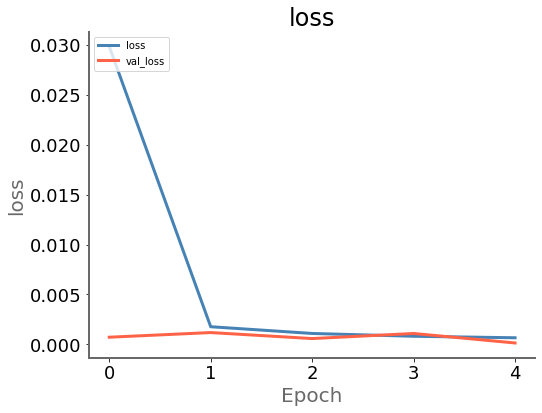

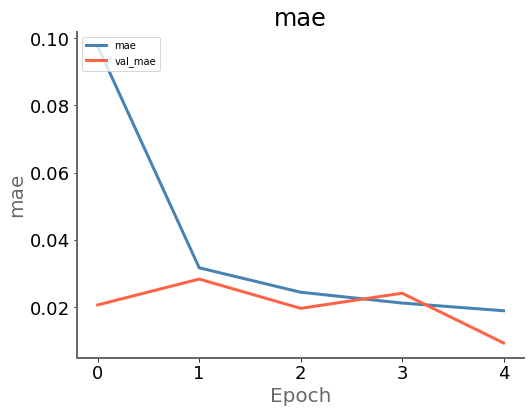

In [13]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='03-history')

## Step 5 - Predict

### 5.1 - Load model

In [14]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
print('Loaded.')

Loaded.


### 5.2 - Make a 1-step prediction
A simple prediction on a single iteration

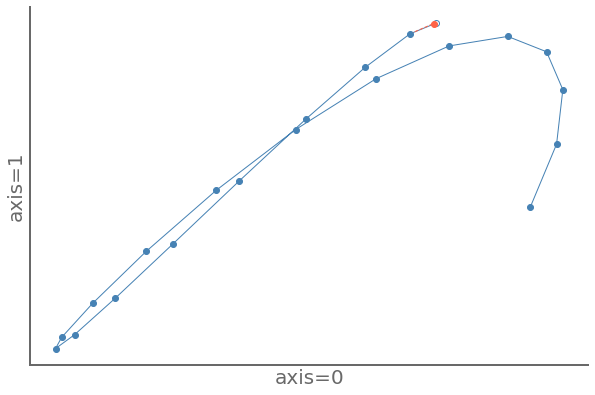

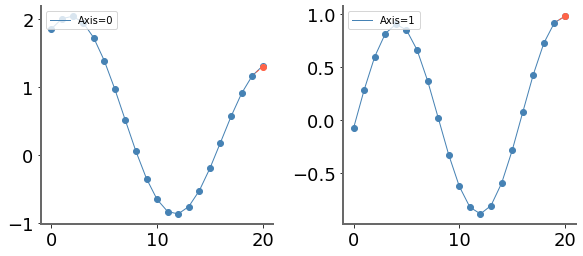

In [15]:
s=random.randint(0,len(x_test)-sequence_len)

sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len+1]

sequence_pred = loaded_model.predict( np.array([sequence]) )

pwk.plot_2d_segment(sequence_true, sequence_pred)
pwk.plot_multivariate_serie(sequence_true, predictions=sequence_pred, labels=['Axis=0', 'Axis=1'],save_as='04-one-step-prediction')

### 5.3 - Make n-steps prediction
A longer term prediction, via a nice iteration function :

In [16]:
def get_prediction(dataset, model, iterations=4):

    # ---- Initial sequence
    #
    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate 
    #
    sequence_pred = list(sequence_pred)

    for i in range(iterations):
        sequence   = sequence_pred[-sequence_len:]
        prediction = model.predict( np.array([sequence]) )
        sequence_pred.append(prediction[0])

    # ---- Extract the predictions    
    #
    prediction = np.array(sequence_pred[-iterations:])

    return sequence_true,prediction

An n-steps prediction :

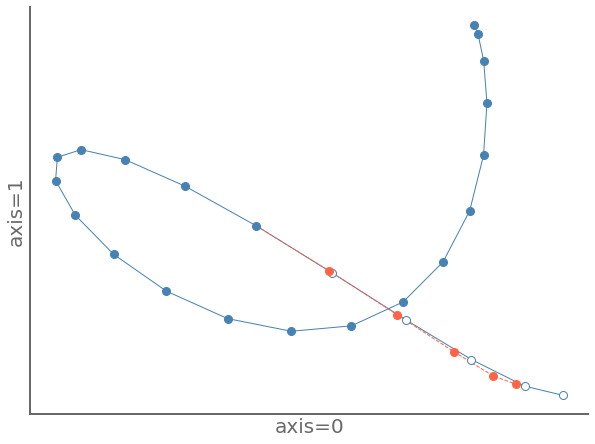

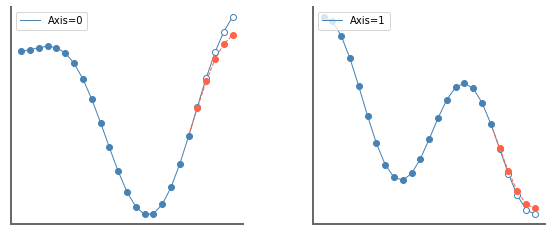

In [17]:
sequence_true, sequence_pred = get_prediction(x_test, loaded_model, iterations=5)

pwk.plot_2d_segment(sequence_true, sequence_pred, ms=8, save_as='02-prediction-norm')
pwk.plot_multivariate_serie(sequence_true, predictions=sequence_pred, hide_ticks=True, labels=['Axis=0', 'Axis=1'],save_as='02-prediction-norm')

In [18]:
pwk.end()

End time is : Tuesday 09 March 2021, 22:35:41
Duration is : 00:02:55 936ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>